In [ ]:
# !pip install timezonefinder

In [274]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pytz
import math
from datetime import timedelta
import holidays
from timezonefinder import TimezoneFinder
from geopy.geocoders import Nominatim
import warnings
import scipy
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler,FunctionTransformer,OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc,precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from scipy import stats
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns',None)

# Import Data and Data Type Mapping

- Based on the data description I understood how each feature datatype should be so mapped the columns along with the required dtype

In [3]:
col_dtype_dict = {'YEAR':'int', 'QUARTER':'int', 'MONTH':'int', 'DAY_OF_MONTH':'int', 'DAY_OF_WEEK':'int', 'FL_DATE':'string',
    'UNIQUE_CARRIER':'category','ORIGIN':'category','ORIGIN_CITY_NAME':'string', 'ORIGIN_STATE_ABR':'string',
    'DEST':'category','DEST_CITY_NAME':'string','DEST_STATE_ABR':'string','DEP_TIME':'string','ARR_TIME':'string',
    'ARR_DELAY':'float','AIR_TIME':'int','DISTANCE':'float','DISTANCE_GROUP':'category'}

In [4]:
# Import data using pandas read_csv with dtype to set column dtype
data = pd.read_csv("./Data/Flight Delay Dataset.csv", dtype = col_dtype_dict)

In [5]:
data.head(10)

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK     FL_DATE UNIQUE_CARRIER  \
0  2017        3      7            11            2   7/11/2017             DL   
1  2018        1      3            14            3   3/14/2018             DL   
2  2017        4     11            12            7  11/12/2017             WN   
3  2017        3      8            22            2   8/22/2017             EV   
4  2018        1      3             2            5    3/2/2018             DL   
5  2017        4     10            12            4  10/12/2017             DL   
6  2017        3      7            15            6   7/15/2017             DL   
7  2017        3      9            28            4   9/28/2017             AA   
8  2017        3      7            23            7   7/23/2017             WN   
9  2018        1      1            14            7   1/14/2018             DL   

  ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR DEST    DEST_CITY_NAME  \
0    LIT  Little Rock, AR               AR  ATL       Atlanta, GA   
1    BOS       Boston, MA               MA  ATL       Atlanta, GA   
2    ATL      Atlanta, GA               GA  DAL        Dallas, TX   
3    ATL      Atlanta, GA               GA  HPN  White Plains, NY   
4    MSY  New Orleans, LA               LA  ATL       Atlanta, GA   
5    SAN    San Diego, CA               CA  ATL       Atlanta, GA   
6    MKE    Milwaukee, WI               WI  ATL       Atlanta, GA   
7    ATL      Atlanta, GA               GA  PHL  Philadelphia, PA   
8    ATL      Atlanta, GA               GA  PIT    Pittsburgh, PA   
9    DTW      Detroit, MI               MI  ATL       Atlanta, GA   

  DEST_STATE_ABR DEP_TIME ARR_TIME  ARR_DELAY  AIR_TIME  DISTANCE  \
0             GA      538      757      -11.0        64     453.0   
1             GA     1829     2108      -23.0       127     946.0   
2             TX     1345     1451       -9.0       106     721.0   
3             NY     1158     1408      -21.0       113     780.0   
4             GA      522      737      -19.0        59     425.0   
5             GA      818     1513      -16.0       212    1892.0   
6             GA      601      856       -2.0        97     669.0   
7             PA     1520     1727       -2.0       102     666.0   
8             PA      904     1039        4.0        75     526.0   
9             GA     2028     2224      -24.0        89     594.0   

  DISTANCE_GROUP  
0              2  
1              4  
2              3  
3              4  
4              2  
5              8  
6              3  
7              3  
8              3  
9              3

#### Validating datatypes of all the columns in the dataframe

In [6]:
data.info() #Validating based on the column dtype dictionary

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148052 entries, 0 to 148051
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   YEAR              148052 non-null  int64   
 1   QUARTER           148052 non-null  int64   
 2   MONTH             148052 non-null  int64   
 3   DAY_OF_MONTH      148052 non-null  int64   
 4   DAY_OF_WEEK       148052 non-null  int64   
 5   FL_DATE           148052 non-null  string  
 6   UNIQUE_CARRIER    148052 non-null  category
 7   ORIGIN            148052 non-null  category
 8   ORIGIN_CITY_NAME  148052 non-null  string  
 9   ORIGIN_STATE_ABR  148052 non-null  string  
 10  DEST              148052 non-null  category
 11  DEST_CITY_NAME    148052 non-null  string  
 12  DEST_STATE_ABR    148052 non-null  string  
 13  DEP_TIME          148052 non-null  string  
 14  ARR_TIME          148052 non-null  string  
 15  ARR_DELAY         147985 non-null  float64 
 16  AI

In [7]:
data.shape # understanding the shape of the data to know how many datapoints and features are there

(148052, 19)

# Data Exploration and Data Cleaning

#### Checking if any duplicate records are present

In [8]:
data[data.duplicated()==True].shape

(0, 19)

#### Checking missing values

In [9]:
data.isna().sum()

YEAR                 0
QUARTER              0
MONTH                0
DAY_OF_MONTH         0
DAY_OF_WEEK          0
FL_DATE              0
UNIQUE_CARRIER       0
ORIGIN               0
ORIGIN_CITY_NAME     0
ORIGIN_STATE_ABR     0
DEST                 0
DEST_CITY_NAME       0
DEST_STATE_ABR       0
DEP_TIME             0
ARR_TIME             0
ARR_DELAY           67
AIR_TIME             0
DISTANCE             0
DISTANCE_GROUP       0
dtype: int64

- Observed missing values in `ARR_DELAY` column

In [10]:
total_missing = (data.isna().sum().sum()/data.shape[0])
print(f"Total Missing: {total_missing:.3%}")

Total Missing: 0.045%


- 0.045% of the data has missing values

In [11]:
data[data['ARR_DELAY'].isna()] #checking the datapoints having nan values

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK    FL_DATE  \
4026    2018        2      4             8            7   4/8/2018   
8699    2018        1      2            19            1  2/19/2018   
12382   2018        1      3            28            3  3/28/2018   
12504   2018        1      1            12            5  1/12/2018   
12545   2018        2      4             1            7   4/1/2018   
13112   2018        2      4             6            5   4/6/2018   
17207   2018        1      2            24            6  2/24/2018   
17249   2018        2      4            11            3  4/11/2018   
19268   2018        1      3             3            6   3/3/2018   
19620   2018        1      3            25            7  3/25/2018   
23374   2018        1      3             3            6   3/3/2018   
28862   2018        2      4            16            1  4/16/2018   
31799   2018        2      4            26            4  4/26/2018   
33309   2018        1      3            15            4  3/15/2018   
36394   2018        1      2             9            5   2/9/2018   
36678   2018        1      3             6            2   3/6/2018   
39651   2018        1      2            28            3  2/28/2018   
41843   2018        1      3             8            4   3/8/2018   
44507   2018        1      2             8            4   2/8/2018   
46582   2018        1      1             9            2   1/9/2018   
49532   2018        1      2             2            5   2/2/2018   
49970   2018        2      4             6            5   4/6/2018   
51883   2018        2      4            15            7  4/15/2018   
53726   2018        1      3            15            4  3/15/2018   
60459   2018        1      3            31            6  3/31/2018   
61701   2018        1      3            22            4  3/22/2018   
62502   2018        1      3             7            3   3/7/2018   
62562   2018        2      4             2            1   4/2/2018   
66194   2018        1      2            15            4  2/15/2018   
70665   2018        2      4            26            4  4/26/2018   
74301   2018        2      4             4            3   4/4/2018   
74420   2018        2      4            24            2  4/24/2018   
78068   2018        2      4             8            7   4/8/2018   
79774   2018        1      3            15            4  3/15/2018   
80427   2018        1      3            24            6  3/24/2018   
85797   2018        1      3            11            7  3/11/2018   
86127   2018        1      2            14            3  2/14/2018   
88551   2018        1      3            16            5  3/16/2018   
90278   2018        1      1            18            4  1/18/2018   
91551   2018        1      3             7            3   3/7/2018   
92866   2018        2      4            27            5  4/27/2018   
93447   2018        1      2            14            3  2/14/2018   
93765   2018        1      3             2            5   3/2/2018   
94023   2018        1      1            18            4  1/18/2018   
94766   2018        1      3            18            7  3/18/2018   
95987   2018        1      2            15            4  2/15/2018   
99243   2018        1      2            16            5  2/16/2018   
99702   2018        1      2            20            2  2/20/2018   
103708  2018        1      3            22            4  3/22/2018   
109361  2018        1      3            14            3  3/14/2018   
111842  2018        2      4            22            7  4/22/2018   
112931  2018        1      2            21            3  2/21/2018   
113465  2018        1      3            22            4  3/22/2018   
113911  2018        2      4             9            1   4/9/2018   
115018  2018        1      3            23            5  3/23/2018   
116432  2018        1      2            26            1  2/26/2018   
116679  2018      

- Based on this dataframe I observed that the missing values are related to UNIQUE_CARRIER 9E

In [12]:
data.loc[data['UNIQUE_CARRIER'] == '9E'].shape # Finding number of datapoints related to UNIQUE_CARRIER 9E

(3551, 19)

In [13]:
data[data['ARR_DELAY'].isna()].shape # Considering only ARR_DELAY checking the shape of data with nan values

(67, 19)

In [14]:
data.loc[(data['UNIQUE_CARRIER'] == '9E') & (data['ARR_DELAY'].isna())].shape # Considering ARR_DELAY and UNIQUE_CARRIER

(67, 19)

- Based on the above dataframe we can observe that `UNIQUE_CARRIER` `9E` has the `ARR_DELAY` missing

    - Evidence is that when we consider only arrival delay the number of missing records are 67; and when we consider both arrival delay and unique carrier, then also the number of records are 67

In [15]:
missing_ratio_9e = (data.loc[data['UNIQUE_CARRIER'] == '9E', 'ARR_DELAY'].isna().mean())
print(f"Missing ratio for 9E: {missing_ratio_9e:.2%}")

Missing ratio for 9E: 1.89%


In [16]:
data = data.dropna() # dropping nan values

- There are total 67 rows with nan values specifically related to `UNIQUE_CARRIER` `9E`. In total, the datapoints related to `9E` are 3551 so the missinginess related to 9E carrier is 1.89%
- Based on the above analysis overall missing percentage is 0.045%. This should be removed due to missingness in target variable `ARR_DELAY`. Imputation can cause bias into the data

In [17]:
data.isna().sum() # Checking if all the missing values are dropped or not

YEAR                0
QUARTER             0
MONTH               0
DAY_OF_MONTH        0
DAY_OF_WEEK         0
FL_DATE             0
UNIQUE_CARRIER      0
ORIGIN              0
ORIGIN_CITY_NAME    0
ORIGIN_STATE_ABR    0
DEST                0
DEST_CITY_NAME      0
DEST_STATE_ABR      0
DEP_TIME            0
ARR_TIME            0
ARR_DELAY           0
AIR_TIME            0
DISTANCE            0
DISTANCE_GROUP      0
dtype: int64

### Checking data inconsistencies

#### Validating `YEAR` feature

In [18]:
data['YEAR'].value_counts()

YEAR
2017    97252
2018    50733
Name: count, dtype: int64

- Based on the value counts we can infer that the data is of 2017 and 2018 and doesn't have any other values

#### Validating `QUARTER`, `MONTH`,`DAY_OF_MONTH`,`DAY_OF_WEEK`

In [19]:
data['QUARTER'].value_counts()

QUARTER
2    39269
1    37312
3    37030
4    34374
Name: count, dtype: int64

- Based on the `QUARTER` feature we can infer that the data consists of 4 quarters
- Every year will have 4 quarters based on the above value counts we can understand that there is no issue with the `QUARTER` data

In [20]:
data['MONTH'].value_counts()

MONTH
3     13731
4     13421
7     13053
6     12959
5     12889
8     12808
1     12166
10    12084
11    11464
2     11415
9     11169
12    10826
Name: count, dtype: int64

In [21]:
np.sort(data['MONTH'].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

- Based on the `MONTH` feature we can infer that the data consists of 12 months
- The sequence is from 1- 12 which fits the range of month

In [22]:
np.sort(data['DAY_OF_MONTH'].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [23]:
data.groupby(by=['MONTH'], as_index=False, observed=True)['DAY_OF_MONTH'].nunique()

MONTH  DAY_OF_MONTH
0       1            31
1       2            28
2       3            31
3       4            30
4       5            31
5       6            30
6       7            31
7       8            31
8       9            30
9      10            31
10     11            30
11     12            31

-⁠ ⁠Based on the `⁠DAY_OF_MONTH⁠` feature we can infer that it ranges 1-31 across all the months except February because February can contain 28 or 29 days.

In [24]:
data['DAY_OF_WEEK'].value_counts()

DAY_OF_WEEK
1    22551
4    22167
5    22079
3    21929
2    21616
7    20455
6    17188
Name: count, dtype: int64

In [25]:
np.sort(data['DAY_OF_WEEK'].unique())

array([1, 2, 3, 4, 5, 6, 7])

- `DAY_OF_WEEK` ranges from 1-7. There are no misleading entries in this column

#### Validating `FL_DATE` feature

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 147985 entries, 0 to 148051
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   YEAR              147985 non-null  int64   
 1   QUARTER           147985 non-null  int64   
 2   MONTH             147985 non-null  int64   
 3   DAY_OF_MONTH      147985 non-null  int64   
 4   DAY_OF_WEEK       147985 non-null  int64   
 5   FL_DATE           147985 non-null  string  
 6   UNIQUE_CARRIER    147985 non-null  category
 7   ORIGIN            147985 non-null  category
 8   ORIGIN_CITY_NAME  147985 non-null  string  
 9   ORIGIN_STATE_ABR  147985 non-null  string  
 10  DEST              147985 non-null  category
 11  DEST_CITY_NAME    147985 non-null  string  
 12  DEST_STATE_ABR    147985 non-null  string  
 13  DEP_TIME          147985 non-null  string  
 14  ARR_TIME          147985 non-null  string  
 15  ARR_DELAY         147985 non-null  float64 
 16  AIR_TIM

- Converting date column `FL_DATE` datatype from string to datetype datatype

In [27]:
data['FL_DATE'] = pd.to_datetime(data['FL_DATE'])

- Checking the datatype of all the columns to verify the date column `FL_DATE` datatype change is reflected

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 147985 entries, 0 to 148051
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   YEAR              147985 non-null  int64         
 1   QUARTER           147985 non-null  int64         
 2   MONTH             147985 non-null  int64         
 3   DAY_OF_MONTH      147985 non-null  int64         
 4   DAY_OF_WEEK       147985 non-null  int64         
 5   FL_DATE           147985 non-null  datetime64[ns]
 6   UNIQUE_CARRIER    147985 non-null  category      
 7   ORIGIN            147985 non-null  category      
 8   ORIGIN_CITY_NAME  147985 non-null  string        
 9   ORIGIN_STATE_ABR  147985 non-null  string        
 10  DEST              147985 non-null  category      
 11  DEST_CITY_NAME    147985 non-null  string        
 12  DEST_STATE_ABR    147985 non-null  string        
 13  DEP_TIME          147985 non-null  string        
 14  ARR_TIME 

#### Validating `UNIQUE_CARRIER` feature

In [29]:
data['UNIQUE_CARRIER'].value_counts()

UNIQUE_CARRIER
DL    95931
WN    16370
EV     9922
OO     7387
AA     4666
9E     3484
NK     2924
UA     2409
F9     1387
B6     1283
OH      739
YX      676
YV      348
AS      262
MQ      106
G4       91
Name: count, dtype: int64

- the `UNIQUE_CARRIER` follows based on the given data description

#### Validating Time related features `ARR_TIME` and `DEP_TIME`

In [30]:
# Funtion to check if ARR_TIME and DEP_TIME follows the format hhmm
def check_time_format(row, columns):
  """
  This function checks if the hhmm format is maintained across all the time related columns based on the data description or not
  Args:
    row -> Contains all the required time columns which needs to verified
    columns -> List of columns to check for time format

  Returns:
    output(pd.Series(results)) -> containing boolean values corresponding to all the columns based on the time format verification
  """
  output = []
  for col in columns:
    if len(row[col]) <= 2:
      output.append(False)
    else:
      output.append(True)
  return pd.Series(output)

In [31]:
# applying check_time_format function on time related features
data[['ARR_TIME_FORMAT_FLG', 'DEP_TIME_FORMAT_FLG']] = data[['ARR_TIME','DEP_TIME']].apply(check_time_format, axis=1, args=(['ARR_TIME','DEP_TIME'],))

In [32]:
# Checking against random 5 samples if the logic for correct format works or not for `False scenario`
data.loc[(data['ARR_TIME_FORMAT_FLG']==False) | (data['DEP_TIME_FORMAT_FLG']==False),:].sample(5, random_state=20)

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK    FL_DATE  \
105959  2017        4     12            19            2 2017-12-19   
120257  2017        3      7            30            7 2017-07-30   
139499  2017        4     10            27            5 2017-10-27   
83277   2018        2      4            28            6 2018-04-28   
15370   2017        2      5             4            4 2017-05-04   

       UNIQUE_CARRIER ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR DEST  \
105959             DL    ATL      Atlanta, GA               GA  TPA   
120257             DL    ATL      Atlanta, GA               GA  BNA   
139499             DL    ATL      Atlanta, GA               GA  CHS   
83277              DL    ATL      Atlanta, GA               GA  MSP   
15370              DL    ATL      Atlanta, GA               GA  AVL   

         DEST_CITY_NAME DEST_STATE_ABR DEP_TIME ARR_TIME  ARR_DELAY  AIR_TIME  \
105959        Tampa, FL             FL     2249        7       -8.0        60   
120257    Nashville, TN             TN        7     2359       19.0        35   
139499   Charleston, SC             SC     2331       25      -16.0        39   
83277   Minneapolis, MN             MN     2237       12       15.0       135   
15370     Asheville, NC             NC     2326       16       25.0        33   

        DISTANCE DISTANCE_GROUP  ARR_TIME_FORMAT_FLG  DEP_TIME_FORMAT_FLG  
105959     406.0              2                False                 True  
120257     214.0              1                 True                False  
139499     259.0              2                False                 True  
83277      907.0              4                False                 True  
15370      164.0              1                False                 True

- From the above dataframe we can see that when `ARR_TIME` or `DEP_TIME` is `less than or equal to 2 digit` the `ARR_TIME_FORMAT_FLG` and `DEP_TIME_FORMAT_FLG` is `False`

In [33]:
# Checking against random 5 samples if the logic for correct format works or not for `True scenario`
data.loc[(data['ARR_TIME_FORMAT_FLG']==True) & (data['DEP_TIME_FORMAT_FLG']==True),:].sample(5, random_state=20)

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK    FL_DATE  \
117157  2018        2      4            10            2 2018-04-10   
94763   2018        1      1            24            3 2018-01-24   
50584   2017        4     10            12            4 2017-10-12   
106527  2017        4     12            22            5 2017-12-22   
87315   2018        1      2            26            1 2018-02-26   

       UNIQUE_CARRIER ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR DEST  \
117157             DL    ATL      Atlanta, GA               GA  MKE   
94763              AA    ATL      Atlanta, GA               GA  LAX   
50584              DL    LAS    Las Vegas, NV               NV  ATL   
106527             EV    ATL      Atlanta, GA               GA  LEX   
87315              DL    ATL      Atlanta, GA               GA  BOS   

         DEST_CITY_NAME DEST_STATE_ABR DEP_TIME ARR_TIME  ARR_DELAY  AIR_TIME  \
117157    Milwaukee, WI             WI     1644     1745       -2.0        92   
94763   Los Angeles, CA             CA     1548     1734      -32.0       267   
50584       Atlanta, GA             GA     1014     1706        2.0       200   
106527    Lexington, KY             KY     2227     2336      -19.0        51   
87315        Boston, MA             MA     1345     1557      -23.0       111   

        DISTANCE DISTANCE_GROUP  ARR_TIME_FORMAT_FLG  DEP_TIME_FORMAT_FLG  
117157     669.0              3                 True                 True  
94763     1947.0              8                 True                 True  
50584     1747.0              7                 True                 True  
106527     304.0              2                 True                 True  
87315      946.0              4                 True                 True

- From the above dataframe we can see that when `ARR_TIME` or `DEP_TIME` is following `hhmm` format so the `ARR_TIME_FORMAT_FLG` and `DEP_TIME_FORMAT_FLG` is `True`

*   Analyzing the False cases for DEP_TIME aand ARR_TIME



In [34]:
# Number of data points which does not follow Time Format based on data description
data.loc[(data['ARR_TIME_FORMAT_FLG']==False) | (data['DEP_TIME_FORMAT_FLG']==False),:].shape

(2880, 21)

*   Based on the above result 2880 datapoints have time format issue which can be wrong, or can be hours or can be minutes.

*   Validating if the time with less than equal to 2 digits as hours

In [35]:
# Validating datapoints with ARR_TIME_FORMAT_FLG or DEP_TIME_FORMAT_FLG False and ARR_TIME or DEPT_TIME greater than 24 hours
data.loc[((data['ARR_TIME_FORMAT_FLG']==False) | (data['DEP_TIME_FORMAT_FLG']==False)) & ((data['ARR_TIME'].astype('int')>24) | (data['DEP_TIME'].astype('int')>24)),:].sample(10, random_state=20)

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK    FL_DATE  \
8753    2017        2      6            23            5 2017-06-23   
115510  2017        2      6            13            2 2017-06-13   
117504  2017        3      7            11            2 2017-07-11   
80844   2017        4     10             9            1 2017-10-09   
74969   2017        2      6            25            7 2017-06-25   
120328  2017        2      5            21            7 2017-05-21   
90102   2017        2      5             4            4 2017-05-04   
138341  2017        3      7            14            5 2017-07-14   
90792   2017        3      7            14            5 2017-07-14   
63766   2017        3      8            14            1 2017-08-14   

       UNIQUE_CARRIER ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR DEST  \
8753               EV    ORD      Chicago, IL               IL  SAV   
115510             DL    ATL      Atlanta, GA               GA  DAB   
117504             DL    ATL      Atlanta, GA               GA  ABE   
80844              DL    ATL      Atlanta, GA               GA  DCA   
74969              DL    ATL      Atlanta, GA               GA  MKE   
120328             DL    ATL      Atlanta, GA               GA  BDL   
90102              WN    ATL      Atlanta, GA               GA  MCI   
138341             DL    ATL      Atlanta, GA               GA  SFO   
90792              WN    ATL      Atlanta, GA               GA  MSP   
63766              DL    ATL      Atlanta, GA               GA  SAV   

                        DEST_CITY_NAME DEST_STATE_ABR DEP_TIME ARR_TIME  \
8753                      Savannah, GA             GA     2122       38   
115510               Daytona Beach, FL             FL     2233        1   
117504  Allentown/Bethlehem/Easton, PA             PA     2247       48   
80844                   Washington, DC             VA       44      212   
74969                    Milwaukee, WI             WI       27      121   
120328                    Hartford, CT             CT     2216       21   
90102                  Kansas City, MO             MO     2318       15   
138341               San Francisco, CA             CA     2229       23   
90792                  Minneapolis, MN             MN     2259       51   
63766                     Savannah, GA             GA     2328       33   

        ARR_DELAY  AIR_TIME  DISTANCE DISTANCE_GROUP  ARR_TIME_FORMAT_FLG  \
8753         -7.0       105     773.0              4                False   
115510        6.0        54     366.0              2                False   
117504       58.0        92     692.0              3                False   
80844       146.0        74     547.0              3                 True   
74969        93.0        89     669.0              3                 True   
120328      -29.0       107     859.0              4                False   
90102        45.0        96     692.0              3                False   
138341       28.0       253    2139.0              9                False   
90792        41.0       125     907.0              4                False   
63766        -2.0        42     214.0              1                False   

        DEP_TIME_FORMAT_FLG  
8753                   True  
115510                 True  
117504                 True  
80844                 False  
74969                 False  
120328                 True  
90102                  True  
138341                 True  
90792                  True  
63766                  True

*   The above dataframe shows that time with less than 2 digits can never be hours, because in a day there can be only 24 hours

*   Validating time with less than equal to 2 digits as minutes

In [36]:
data.loc[(data['ARR_TIME_FORMAT_FLG']==False) & (data['ARR_TIME'].astype('int')>59),:] # For `ARR_TIME` we observe none of the records are greater than 59

Empty DataFrame
Columns: [YEAR, QUARTER, MONTH, DAY_OF_MONTH, DAY_OF_WEEK, FL_DATE, UNIQUE_CARRIER, ORIGIN, ORIGIN_CITY_NAME, ORIGIN_STATE_ABR, DEST, DEST_CITY_NAME, DEST_STATE_ABR, DEP_TIME, ARR_TIME, ARR_DELAY, AIR_TIME, DISTANCE, DISTANCE_GROUP, ARR_TIME_FORMAT_FLG, DEP_TIME_FORMAT_FLG]
Index: []

In [37]:
data.loc[(data['DEP_TIME_FORMAT_FLG']==False) & (data['DEP_TIME'].astype('int')>59),:] # For `DEP_TIME` we observe none of the records are greater than 59

Empty DataFrame
Columns: [YEAR, QUARTER, MONTH, DAY_OF_MONTH, DAY_OF_WEEK, FL_DATE, UNIQUE_CARRIER, ORIGIN, ORIGIN_CITY_NAME, ORIGIN_STATE_ABR, DEST, DEST_CITY_NAME, DEST_STATE_ABR, DEP_TIME, ARR_TIME, ARR_DELAY, AIR_TIME, DISTANCE, DISTANCE_GROUP, ARR_TIME_FORMAT_FLG, DEP_TIME_FORMAT_FLG]
Index: []

*   Based on the above observations the time less than equal to 2 digits, it can be minutes.
*   Doing further analysis to see if there is any correlation between `AIR_TIME` and the difference between `DEP_TIME` and `AIR_TIME`, by considering such values as minutes
*   If there is correlation it means that the values can be considered as minutes




In [38]:
#  Filtered records where datapoints do not follow hhmm format
filtered_df = data.loc[(data['ARR_TIME_FORMAT_FLG']==False) | (data['DEP_TIME_FORMAT_FLG']==False),:].copy(deep=True)

In [39]:
filtered_df.head()

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK    FL_DATE  \
78   2018        1      2             1            4 2018-02-01   
93   2018        1      3            20            2 2018-03-20   
192  2017        4     11            12            7 2017-11-12   
229  2018        1      3            30            5 2018-03-30   
354  2017        4     12             5            2 2017-12-05   

    UNIQUE_CARRIER ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR DEST  \
78              DL    ATL      Atlanta, GA               GA  SFO   
93              DL    ATL      Atlanta, GA               GA  BHM   
192             DL    ATL      Atlanta, GA               GA  SDF   
229             DL    SAT  San Antonio, TX               TX  ATL   
354             DL    ATL      Atlanta, GA               GA  FLL   

          DEST_CITY_NAME DEST_STATE_ABR DEP_TIME ARR_TIME  ARR_DELAY  \
78     San Francisco, CA             CA     2159       43       48.0   
93        Birmingham, AL             AL        2     2348       18.0   
192       Louisville, KY             KY     2231        5       10.0   
229          Atlanta, GA             GA       50      348      160.0   
354  Fort Lauderdale, FL             FL     2232       17       -8.0   

     AIR_TIME  DISTANCE DISTANCE_GROUP  ARR_TIME_FORMAT_FLG  \
78        296    2139.0              9                False   
93         28     134.0              1                 True   
192        53     321.0              2                False   
229       102     874.0              4                 True   
354        85     581.0              3                False   

     DEP_TIME_FORMAT_FLG  
78                  True  
93                 False  
192                 True  
229                False  
354                 True

In [40]:
# Updating the values in place based on the assumption that such time features are minutes
filtered_df.loc[filtered_df['ARR_TIME_FORMAT_FLG'] == False, 'ARR_TIME'] = filtered_df.loc[filtered_df['ARR_TIME_FORMAT_FLG']==False,'ARR_TIME'].apply(lambda cell: '000'+cell if len(cell)==1 else '00'+cell)
filtered_df.loc[filtered_df['DEP_TIME_FORMAT_FLG'] == False, 'DEP_TIME'] = filtered_df.loc[filtered_df['DEP_TIME_FORMAT_FLG']==False,'DEP_TIME'].apply(lambda cell: '000'+cell if len(cell)==1 else '00'+cell)

In [41]:
filtered_df.head() # Checking if the `ARR_TIME` and `DEP_TIME` is updated

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK    FL_DATE  \
78   2018        1      2             1            4 2018-02-01   
93   2018        1      3            20            2 2018-03-20   
192  2017        4     11            12            7 2017-11-12   
229  2018        1      3            30            5 2018-03-30   
354  2017        4     12             5            2 2017-12-05   

    UNIQUE_CARRIER ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR DEST  \
78              DL    ATL      Atlanta, GA               GA  SFO   
93              DL    ATL      Atlanta, GA               GA  BHM   
192             DL    ATL      Atlanta, GA               GA  SDF   
229             DL    SAT  San Antonio, TX               TX  ATL   
354             DL    ATL      Atlanta, GA               GA  FLL   

          DEST_CITY_NAME DEST_STATE_ABR DEP_TIME ARR_TIME  ARR_DELAY  \
78     San Francisco, CA             CA     2159     0043       48.0   
93        Birmingham, AL             AL     0002     2348       18.0   
192       Louisville, KY             KY     2231     0005       10.0   
229          Atlanta, GA             GA     0050      348      160.0   
354  Fort Lauderdale, FL             FL     2232     0017       -8.0   

     AIR_TIME  DISTANCE DISTANCE_GROUP  ARR_TIME_FORMAT_FLG  \
78        296    2139.0              9                False   
93         28     134.0              1                 True   
192        53     321.0              2                False   
229       102     874.0              4                 True   
354        85     581.0              3                False   

     DEP_TIME_FORMAT_FLG  
78                  True  
93                 False  
192                 True  
229                False  
354                 True

- Based on the data description, the time is given in local time format to standardize time I used `Universal Time Coordinated (UTC)` format to maintain consistency across different time zones which is essential for further analysis

In [42]:
def convert_hhmm_to_datetime(row, columns):
    """
    Converts hhmm to datetime format
    Args:
        time (int): Time value which should be splitted into Hours and Minutes

    Returns:
        datetime pd.Series: converts time to datetime format
    """
    output = []
    for col in columns:
      try:
          time = row[col]
          if time != '2400':
              # Convert to string and pad with leading zeros
              time_str = str(time).zfill(4)
          else:
              time_str = '0000'
          # Parse the string to a datetime object
          output.append(pd.to_datetime(time_str, format='%H%M').time())
      except:
          output.append(None)
    return pd.Series(output)

In [43]:
# Converting time format 'HHMM' to 'HH:MM'
filtered_df[['ARR_TIME_FRMT','DEP_TIME_FRMT']] = filtered_df[['ARR_TIME','DEP_TIME']].apply(convert_hhmm_to_datetime, args=(['ARR_TIME','DEP_TIME'],), axis = 1)

In [44]:
# Checking if any of the new time format related columns are null or not
filtered_df.loc[filtered_df['ARR_TIME_FRMT'].isna() | filtered_df['DEP_TIME_FRMT'].isna(),:]

Empty DataFrame
Columns: [YEAR, QUARTER, MONTH, DAY_OF_MONTH, DAY_OF_WEEK, FL_DATE, UNIQUE_CARRIER, ORIGIN, ORIGIN_CITY_NAME, ORIGIN_STATE_ABR, DEST, DEST_CITY_NAME, DEST_STATE_ABR, DEP_TIME, ARR_TIME, ARR_DELAY, AIR_TIME, DISTANCE, DISTANCE_GROUP, ARR_TIME_FORMAT_FLG, DEP_TIME_FORMAT_FLG, ARR_TIME_FRMT, DEP_TIME_FRMT]
Index: []

In [45]:
# Creating TimeZoneFinder and GeoLocator object as global variables
geolocator = Nominatim(user_agent="timezone")
tf = TimezoneFinder()

In [46]:
# Get time zone based on particular location name
def get_time_zone(location_name):
    """Get time zone of location

    Args:
        location_name (str): Location Name to get time zone

    Returns:
        str: Time zone eg:- America/Chicago, America/New York
    """
    try:
        location_name = location_name.strip()
        state = location_name.split(',')[-1]
        place = location_name.split(',')[0].split('/')[0]
        coords = geolocator.geocode(place+' , '+state,timeout=5)
        timezone = tf.timezone_at(lng=coords.longitude, lat=coords.latitude)
        return timezone
    except:
        return None

In [47]:
# Fetching all the locations from Origin and Destination and taking unique set
def get_unique_locations(df):
  """
  This function retrieves the unique location from origin and destination.

  Args:
      df : The dataframe is the input

  Returns:
      set: Set of unique locations
  """
  return set(list(df['DEST_CITY_NAME'].unique())+list(df['ORIGIN_CITY_NAME'].unique()))

In [48]:
unique_locations = get_unique_locations(filtered_df)
print(unique_locations)

{'Des Moines, IA', 'Sioux Falls, SD', 'Denver, CO', 'Evansville, IN', 'Fort Wayne, IN', 'Louisville, KY', 'Los Angeles, CA', 'Charleston/Dunbar, WV', 'New Bern/Morehead/Beaufort, NC', 'Philadelphia, PA', 'Savannah, GA', 'Manchester, NH', 'Columbia, SC', 'Moline, IL', 'Norfolk, VA', 'Lexington, KY', 'Charlotte, NC', 'Bristol/Johnson City/Kingsport, TN', 'Washington, DC', 'Dallas, TX', 'Fort Smith, AR', 'Rochester, NY', 'San Francisco, CA', 'Newark, NJ', 'Greer, SC', 'Detroit, MI', 'Dayton, OH', 'Huntsville, AL', 'San Juan, PR', 'Kansas City, MO', 'Chattanooga, TN', 'Omaha, NE', 'Jacksonville/Camp Lejeune, NC', 'Dallas/Fort Worth, TX', 'Baton Rouge, LA', 'Madison, WI', 'Allentown/Bethlehem/Easton, PA', 'Phoenix, AZ', 'Buffalo, NY', 'Fort Myers, FL', 'Cincinnati, OH', 'Cleveland, OH', 'Raleigh/Durham, NC', 'San Antonio, TX', 'Wichita, KS', 'Gainesville, FL', 'Minneapolis, MN', 'Newport News/Williamsburg, VA', 'Albany, GA', 'Panama City, FL', 'Atlanta, GA', 'Birmingham, AL', 'Jacksonville,

In [49]:
# Created a dictionary with key as location and value as timezone
def map_loc_to_timezone(unique_locations):
    """
    This function maps time zone to location

    Args:
        unique_locations (set): List of unique locations

    Returns:
        location_timezone_map (dict): Dictionary with key as location and value as timezone
    """
    location_timezone_map = dict()
    for location in unique_locations:
        if location not in location_timezone_map:
            location_timezone_map[location] = get_time_zone(location)
    return location_timezone_map

In [50]:
# Mapping timezones to the unique locations
location_timezone_map = map_loc_to_timezone(unique_locations)

In [51]:
location_timezone_map

{'Des Moines, IA': 'America/Chicago',
 'Sioux Falls, SD': 'America/Chicago',
 'Denver, CO': 'America/Denver',
 'Evansville, IN': 'America/Chicago',
 'Fort Wayne, IN': 'America/Indiana/Indianapolis',
 'Louisville, KY': 'America/Kentucky/Louisville',
 'Los Angeles, CA': 'America/Los_Angeles',
 'Charleston/Dunbar, WV': 'America/New_York',
 'New Bern/Morehead/Beaufort, NC': 'America/New_York',
 'Philadelphia, PA': 'America/New_York',
 'Savannah, GA': 'America/New_York',
 'Manchester, NH': 'America/New_York',
 'Columbia, SC': 'America/New_York',
 'Moline, IL': 'America/Chicago',
 'Norfolk, VA': 'America/New_York',
 'Lexington, KY': 'America/New_York',
 'Charlotte, NC': 'America/New_York',
 'Bristol/Johnson City/Kingsport, TN': 'America/New_York',
 'Washington, DC': 'America/New_York',
 'Dallas, TX': 'America/Chicago',
 'Fort Smith, AR': 'America/Chicago',
 'Rochester, NY': 'America/New_York',
 'San Francisco, CA': 'America/Los_Angeles',
 'Newark, NJ': 'America/New_York',
 'Greer, SC': 'Amer

In [52]:
# Mapping origin city and destination city to corresponding time zones
filtered_df['ORIGIN_CITY_TIME_ZONE'] = filtered_df['ORIGIN_CITY_NAME'].map(location_timezone_map)
filtered_df['DEST_CITY_TIME_ZONE'] = filtered_df['DEST_CITY_NAME'].map(location_timezone_map)

In [53]:
# Checking if time zones are ssigned to the time zone related features
filtered_df.sample(5, random_state=20)

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK    FL_DATE  \
105959  2017        4     12            19            2 2017-12-19   
120257  2017        3      7            30            7 2017-07-30   
139499  2017        4     10            27            5 2017-10-27   
83277   2018        2      4            28            6 2018-04-28   
15370   2017        2      5             4            4 2017-05-04   

       UNIQUE_CARRIER ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR DEST  \
105959             DL    ATL      Atlanta, GA               GA  TPA   
120257             DL    ATL      Atlanta, GA               GA  BNA   
139499             DL    ATL      Atlanta, GA               GA  CHS   
83277              DL    ATL      Atlanta, GA               GA  MSP   
15370              DL    ATL      Atlanta, GA               GA  AVL   

         DEST_CITY_NAME DEST_STATE_ABR DEP_TIME ARR_TIME  ARR_DELAY  AIR_TIME  \
105959        Tampa, FL             FL     2249     0007       -8.0        60   
120257    Nashville, TN             TN     0007     2359       19.0        35   
139499   Charleston, SC             SC     2331     0025      -16.0        39   
83277   Minneapolis, MN             MN     2237     0012       15.0       135   
15370     Asheville, NC             NC     2326     0016       25.0        33   

        DISTANCE DISTANCE_GROUP  ARR_TIME_FORMAT_FLG  DEP_TIME_FORMAT_FLG  \
105959     406.0              2                False                 True   
120257     214.0              1                 True                False   
139499     259.0              2                False                 True   
83277      907.0              4                False                 True   
15370      164.0              1                False                 True   

       ARR_TIME_FRMT DEP_TIME_FRMT ORIGIN_CITY_TIME_ZONE DEST_CITY_TIME_ZONE  
105959      00:07:00      22:49:00      America/New_York    America/New_York  
120257      23:59:00      00:07:00      America/New_York     America/Chicago  
139499      00:25:00      23:31:00      America/New_York    America/New_York  
83277       00:12:00      22:37:00      America/New_York     America/Chicago  
15370       00:16:00      23:26:00      America/New_York    America/New_York

In [54]:
# Checking if any of the datapoints are missing time zones
filtered_df.loc[filtered_df['ORIGIN_CITY_TIME_ZONE'].isna() | filtered_df['DEST_CITY_TIME_ZONE'].isna(),:]

Empty DataFrame
Columns: [YEAR, QUARTER, MONTH, DAY_OF_MONTH, DAY_OF_WEEK, FL_DATE, UNIQUE_CARRIER, ORIGIN, ORIGIN_CITY_NAME, ORIGIN_STATE_ABR, DEST, DEST_CITY_NAME, DEST_STATE_ABR, DEP_TIME, ARR_TIME, ARR_DELAY, AIR_TIME, DISTANCE, DISTANCE_GROUP, ARR_TIME_FORMAT_FLG, DEP_TIME_FORMAT_FLG, ARR_TIME_FRMT, DEP_TIME_FRMT, ORIGIN_CITY_TIME_ZONE, DEST_CITY_TIME_ZONE]
Index: []

In [55]:
filtered_df[filtered_df["DEST_CITY_TIME_ZONE"].isna()]

Empty DataFrame
Columns: [YEAR, QUARTER, MONTH, DAY_OF_MONTH, DAY_OF_WEEK, FL_DATE, UNIQUE_CARRIER, ORIGIN, ORIGIN_CITY_NAME, ORIGIN_STATE_ABR, DEST, DEST_CITY_NAME, DEST_STATE_ABR, DEP_TIME, ARR_TIME, ARR_DELAY, AIR_TIME, DISTANCE, DISTANCE_GROUP, ARR_TIME_FORMAT_FLG, DEP_TIME_FORMAT_FLG, ARR_TIME_FRMT, DEP_TIME_FRMT, ORIGIN_CITY_TIME_ZONE, DEST_CITY_TIME_ZONE]
Index: []

In [56]:
# Convert ARR_TIME_FRMT(HH:MM) to UTC Format
filtered_df["ARR_TIME_UTC"] = filtered_df.apply(
    lambda row: (pd.to_datetime(row["FL_DATE"].strftime('%m/%d/%Y') + " " + row["ARR_TIME_FRMT"].strftime('%H:%M'),format="%m/%d/%Y %H:%M")
        .tz_localize(row["DEST_CITY_TIME_ZONE"])
        .tz_convert("UTC")
    ),
    axis=1
)

In [57]:
# Checking if the arrival time is converted to UTC
filtered_df.sample(5, random_state=20)

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK    FL_DATE  \
105959  2017        4     12            19            2 2017-12-19   
120257  2017        3      7            30            7 2017-07-30   
139499  2017        4     10            27            5 2017-10-27   
83277   2018        2      4            28            6 2018-04-28   
15370   2017        2      5             4            4 2017-05-04   

       UNIQUE_CARRIER ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR DEST  \
105959             DL    ATL      Atlanta, GA               GA  TPA   
120257             DL    ATL      Atlanta, GA               GA  BNA   
139499             DL    ATL      Atlanta, GA               GA  CHS   
83277              DL    ATL      Atlanta, GA               GA  MSP   
15370              DL    ATL      Atlanta, GA               GA  AVL   

         DEST_CITY_NAME DEST_STATE_ABR DEP_TIME ARR_TIME  ARR_DELAY  AIR_TIME  \
105959        Tampa, FL             FL     2249     0007       -8.0        60   
120257    Nashville, TN             TN     0007     2359       19.0        35   
139499   Charleston, SC             SC     2331     0025      -16.0        39   
83277   Minneapolis, MN             MN     2237     0012       15.0       135   
15370     Asheville, NC             NC     2326     0016       25.0        33   

        DISTANCE DISTANCE_GROUP  ARR_TIME_FORMAT_FLG  DEP_TIME_FORMAT_FLG  \
105959     406.0              2                False                 True   
120257     214.0              1                 True                False   
139499     259.0              2                False                 True   
83277      907.0              4                False                 True   
15370      164.0              1                False                 True   

       ARR_TIME_FRMT DEP_TIME_FRMT ORIGIN_CITY_TIME_ZONE DEST_CITY_TIME_ZONE  \
105959      00:07:00      22:49:00      America/New_York    America/New_York   
120257      23:59:00      00:07:00      America/New_York     America/Chicago   
139499      00:25:00      23:31:00      America/New_York    America/New_York   
83277       00:12:00      22:37:00      America/New_York     America/Chicago   
15370       00:16:00      23:26:00      America/New_York    America/New_York   

                    ARR_TIME_UTC  
105959 2017-12-19 05:07:00+00:00  
120257 2017-07-31 04:59:00+00:00  
139499 2017-10-27 04:25:00+00:00  
83277  2018-04-28 05:12:00+00:00  
15370  2017-05-04 04:16:00+00:00

In [58]:
# Convert DEP_TIME_UTC(HH:MM) to UTC Format
filtered_df["DEP_TIME_UTC"] = filtered_df.apply(
    lambda row: (pd.to_datetime(row["FL_DATE"].strftime('%m/%d/%Y') + " " + row["DEP_TIME_FRMT"].strftime('%H:%M'),format="%m/%d/%Y %H:%M")
        .tz_localize(row["ORIGIN_CITY_TIME_ZONE"])
        .tz_convert("UTC")
    ),
    axis=1
)

In [59]:
# Checking if the departure time is converted to UTC
filtered_df.sample(5, random_state=20)

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK    FL_DATE  \
105959  2017        4     12            19            2 2017-12-19   
120257  2017        3      7            30            7 2017-07-30   
139499  2017        4     10            27            5 2017-10-27   
83277   2018        2      4            28            6 2018-04-28   
15370   2017        2      5             4            4 2017-05-04   

       UNIQUE_CARRIER ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR DEST  \
105959             DL    ATL      Atlanta, GA               GA  TPA   
120257             DL    ATL      Atlanta, GA               GA  BNA   
139499             DL    ATL      Atlanta, GA               GA  CHS   
83277              DL    ATL      Atlanta, GA               GA  MSP   
15370              DL    ATL      Atlanta, GA               GA  AVL   

         DEST_CITY_NAME DEST_STATE_ABR DEP_TIME ARR_TIME  ARR_DELAY  AIR_TIME  \
105959        Tampa, FL             FL     2249     0007       -8.0        60   
120257    Nashville, TN             TN     0007     2359       19.0        35   
139499   Charleston, SC             SC     2331     0025      -16.0        39   
83277   Minneapolis, MN             MN     2237     0012       15.0       135   
15370     Asheville, NC             NC     2326     0016       25.0        33   

        DISTANCE DISTANCE_GROUP  ARR_TIME_FORMAT_FLG  DEP_TIME_FORMAT_FLG  \
105959     406.0              2                False                 True   
120257     214.0              1                 True                False   
139499     259.0              2                False                 True   
83277      907.0              4                False                 True   
15370      164.0              1                False                 True   

       ARR_TIME_FRMT DEP_TIME_FRMT ORIGIN_CITY_TIME_ZONE DEST_CITY_TIME_ZONE  \
105959      00:07:00      22:49:00      America/New_York    America/New_York   
120257      23:59:00      00:07:00      America/New_York     America/Chicago   
139499      00:25:00      23:31:00      America/New_York    America/New_York   
83277       00:12:00      22:37:00      America/New_York     America/Chicago   
15370       00:16:00      23:26:00      America/New_York    America/New_York   

                    ARR_TIME_UTC              DEP_TIME_UTC  
105959 2017-12-19 05:07:00+00:00 2017-12-20 03:49:00+00:00  
120257 2017-07-31 04:59:00+00:00 2017-07-30 04:07:00+00:00  
139499 2017-10-27 04:25:00+00:00 2017-10-28 03:31:00+00:00  
83277  2018-04-28 05:12:00+00:00 2018-04-29 02:37:00+00:00  
15370  2017-05-04 04:16:00+00:00 2017-05-05 03:26:00+00:00

In [60]:
# Converting UTC datetime format to UTC HH:MM format
filtered_df["ARR_TIME_UTC"] = filtered_df["ARR_TIME_UTC"].dt.strftime("%H:%M")
filtered_df["DEP_TIME_UTC"] = filtered_df["DEP_TIME_UTC"].dt.strftime("%H:%M")

In [61]:
# Checking if the arrival time is converted to UTC
filtered_df.sample(5, random_state=20)

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK    FL_DATE  \
105959  2017        4     12            19            2 2017-12-19   
120257  2017        3      7            30            7 2017-07-30   
139499  2017        4     10            27            5 2017-10-27   
83277   2018        2      4            28            6 2018-04-28   
15370   2017        2      5             4            4 2017-05-04   

       UNIQUE_CARRIER ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR DEST  \
105959             DL    ATL      Atlanta, GA               GA  TPA   
120257             DL    ATL      Atlanta, GA               GA  BNA   
139499             DL    ATL      Atlanta, GA               GA  CHS   
83277              DL    ATL      Atlanta, GA               GA  MSP   
15370              DL    ATL      Atlanta, GA               GA  AVL   

         DEST_CITY_NAME DEST_STATE_ABR DEP_TIME ARR_TIME  ARR_DELAY  AIR_TIME  \
105959        Tampa, FL             FL     2249     0007       -8.0        60   
120257    Nashville, TN             TN     0007     2359       19.0        35   
139499   Charleston, SC             SC     2331     0025      -16.0        39   
83277   Minneapolis, MN             MN     2237     0012       15.0       135   
15370     Asheville, NC             NC     2326     0016       25.0        33   

        DISTANCE DISTANCE_GROUP  ARR_TIME_FORMAT_FLG  DEP_TIME_FORMAT_FLG  \
105959     406.0              2                False                 True   
120257     214.0              1                 True                False   
139499     259.0              2                False                 True   
83277      907.0              4                False                 True   
15370      164.0              1                False                 True   

       ARR_TIME_FRMT DEP_TIME_FRMT ORIGIN_CITY_TIME_ZONE DEST_CITY_TIME_ZONE  \
105959      00:07:00      22:49:00      America/New_York    America/New_York   
120257      23:59:00      00:07:00      America/New_York     America/Chicago   
139499      00:25:00      23:31:00      America/New_York    America/New_York   
83277       00:12:00      22:37:00      America/New_York     America/Chicago   
15370       00:16:00      23:26:00      America/New_York    America/New_York   

       ARR_TIME_UTC DEP_TIME_UTC  
105959        05:07        03:49  
120257        04:59        04:07  
139499        04:25        03:31  
83277         05:12        02:37  
15370         04:16        03:26

In [62]:
# Ensure ARR_TIME and DEP_TIME are numeric (convert HHMM format to minutes)
def convert_to_minutes(row, columns, schd_flag = False):
    """
    Convert HHMM formatted string to total minutes.

    Args:
        time_str (str): Time string in HHMM format.
        columns (list): List of column names.
    Returns:
        int: Total minutes.
    """
    arr_time_utc = row[columns[0]]
    dep_time_utc = row[columns[1]]
    if pd.isna(arr_time_utc) or arr_time_utc == '' or pd.isna(dep_time_utc) or dep_time_utc == '':
        return None  # Handle missing values
    arr_time_str = str(arr_time_utc).zfill(4)  # Ensure it's in HHMM format
    dep_time_str = str(dep_time_utc).zfill(4)  # Ensure it's in HHMM format
    arr_hours, arr_minutes = int(arr_time_str[:2]), int(arr_time_str[3:])
    dep_hours, dep_minutes = int(dep_time_str[:2]), int(dep_time_str[3:])
    arr_mins = arr_hours * 60 + arr_minutes
    dep_mins = dep_hours * 60 + dep_minutes
    # The below condition checks if the arrival time is less than the departure time or not, this happens when flight departs at one day and arrives next day
    if arr_mins < dep_mins:
        arr_mins = arr_mins + 60*24
    if schd_flag:
      return arr_mins
    else:
      return pd.Series([arr_mins,dep_mins])

In [63]:
# Convert UTC times to minutes
filtered_df[['ARR_TIME_UTC_MINUTES','DEP_TIME_UTC_MINUTES']] = filtered_df.apply(convert_to_minutes, axis=1, args=(['ARR_TIME_UTC','DEP_TIME_UTC'],))

In [64]:
# Checking if the UTC time is converted to UTC minutes
filtered_df.sample(5, random_state=20)

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK    FL_DATE  \
105959  2017        4     12            19            2 2017-12-19   
120257  2017        3      7            30            7 2017-07-30   
139499  2017        4     10            27            5 2017-10-27   
83277   2018        2      4            28            6 2018-04-28   
15370   2017        2      5             4            4 2017-05-04   

       UNIQUE_CARRIER ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR DEST  \
105959             DL    ATL      Atlanta, GA               GA  TPA   
120257             DL    ATL      Atlanta, GA               GA  BNA   
139499             DL    ATL      Atlanta, GA               GA  CHS   
83277              DL    ATL      Atlanta, GA               GA  MSP   
15370              DL    ATL      Atlanta, GA               GA  AVL   

         DEST_CITY_NAME DEST_STATE_ABR DEP_TIME ARR_TIME  ARR_DELAY  AIR_TIME  \
105959        Tampa, FL             FL     2249     0007       -8.0        60   
120257    Nashville, TN             TN     0007     2359       19.0        35   
139499   Charleston, SC             SC     2331     0025      -16.0        39   
83277   Minneapolis, MN             MN     2237     0012       15.0       135   
15370     Asheville, NC             NC     2326     0016       25.0        33   

        DISTANCE DISTANCE_GROUP  ARR_TIME_FORMAT_FLG  DEP_TIME_FORMAT_FLG  \
105959     406.0              2                False                 True   
120257     214.0              1                 True                False   
139499     259.0              2                False                 True   
83277      907.0              4                False                 True   
15370      164.0              1                False                 True   

       ARR_TIME_FRMT DEP_TIME_FRMT ORIGIN_CITY_TIME_ZONE DEST_CITY_TIME_ZONE  \
105959      00:07:00      22:49:00      America/New_York    America/New_York   
120257      23:59:00      00:07:00      America/New_York     America/Chicago   
139499      00:25:00      23:31:00      America/New_York    America/New_York   
83277       00:12:00      22:37:00      America/New_York     America/Chicago   
15370       00:16:00      23:26:00      America/New_York    America/New_York   

       ARR_TIME_UTC DEP_TIME_UTC  ARR_TIME_UTC_MINUTES  DEP_TIME_UTC_MINUTES  
105959        05:07        03:49                   307                   229  
120257        04:59        04:07                   299                   247  
139499        04:25        03:31                   265                   211  
83277         05:12        02:37                   312                   157  
15370         04:16        03:26                   256                   206

In [65]:
# Compute time difference
filtered_df['UTC_TIME_DIFFERENCE'] = filtered_df['ARR_TIME_UTC_MINUTES'] - filtered_df['DEP_TIME_UTC_MINUTES']

In [66]:
# Checking if the UTC time difference in minutes
filtered_df.sample(5)

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK    FL_DATE  \
2599    2018        1      3            26            1 2018-03-26   
48275   2017        2      6            21            3 2017-06-21   
101609  2017        4     11             6            1 2017-11-06   
77113   2017        3      8            14            1 2017-08-14   
30341   2017        3      7            15            6 2017-07-15   

       UNIQUE_CARRIER ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR DEST  \
2599               DL    ATL      Atlanta, GA               GA  PVD   
48275              DL    ATL      Atlanta, GA               GA  SJC   
101609             DL    ATL      Atlanta, GA               GA  DTW   
77113              F9    LAS    Las Vegas, NV               NV  ATL   
30341              DL    ATL      Atlanta, GA               GA  FLL   

             DEST_CITY_NAME DEST_STATE_ABR DEP_TIME ARR_TIME  ARR_DELAY  \
2599         Providence, RI             RI     2234     0052       97.0   
48275          San Jose, CA             CA     2240     0031      114.0   
101609          Detroit, MI             MI     2237     0030       -5.0   
77113           Atlanta, GA             GA     0037      735       15.0   
30341   Fort Lauderdale, FL             FL     2258     0043       22.0   

        AIR_TIME  DISTANCE DISTANCE_GROUP  ARR_TIME_FORMAT_FLG  \
2599         120     903.0              4                False   
48275        272    2116.0              9                False   
101609        85     594.0              3                False   
77113        214    1747.0              7                 True   
30341         76     581.0              3                False   

        DEP_TIME_FORMAT_FLG ARR_TIME_FRMT DEP_TIME_FRMT ORIGIN_CITY_TIME_ZONE  \
2599                   True      00:52:00      22:34:00      America/New_York   
48275                  True      00:31:00      22:40:00      America/New_York   
101609                 True      00:30:00      22:37:00      America/New_York   
77113                 False      07:35:00      00:37:00   America/Los_Angeles   
30341                  True      00:43:00      22:58:00      America/New_York   

        DEST_CITY_TIME_ZONE ARR_TIME_UTC DEP_TIME_UTC  ARR_TIME_UTC_MINUTES  \
2599       America/New_York        04:52        02:34                   292   
48275   America/Los_Angeles        07:31        02:40                   451   
101609      America/Detroit        05:30        03:37                   330   
77113      America/New_York        11:35        07:37                   695   
30341      America/New_York        04:43        02:58                   283   

        DEP_TIME_UTC_MINUTES  UTC_TIME_DIFFERENCE  
2599                     154                  138  
48275                    160                  291  
101609                   217                  113  
77113                    457                  238  
30341                    178                  105

In [67]:
filtered_df.loc[filtered_df['UTC_TIME_DIFFERENCE']<=0,:]

Empty DataFrame
Columns: [YEAR, QUARTER, MONTH, DAY_OF_MONTH, DAY_OF_WEEK, FL_DATE, UNIQUE_CARRIER, ORIGIN, ORIGIN_CITY_NAME, ORIGIN_STATE_ABR, DEST, DEST_CITY_NAME, DEST_STATE_ABR, DEP_TIME, ARR_TIME, ARR_DELAY, AIR_TIME, DISTANCE, DISTANCE_GROUP, ARR_TIME_FORMAT_FLG, DEP_TIME_FORMAT_FLG, ARR_TIME_FRMT, DEP_TIME_FRMT, ORIGIN_CITY_TIME_ZONE, DEST_CITY_TIME_ZONE, ARR_TIME_UTC, DEP_TIME_UTC, ARR_TIME_UTC_MINUTES, DEP_TIME_UTC_MINUTES, UTC_TIME_DIFFERENCE]
Index: []

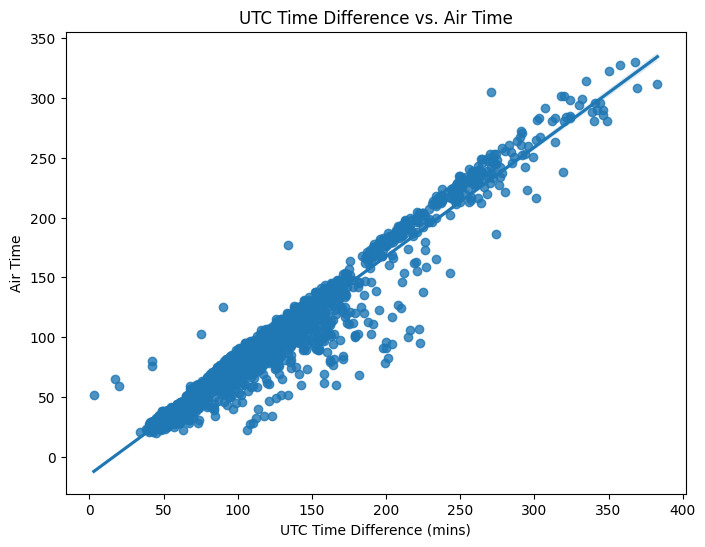

In [68]:
# Regression Plot between UTC Time Difference vs. Air Time
plt.figure(figsize=(8, 6))
sns.regplot(x='UTC_TIME_DIFFERENCE', y='AIR_TIME', data=filtered_df)
plt.title('UTC Time Difference vs. Air Time')
plt.xlabel('UTC Time Difference (mins)')
plt.ylabel('Air Time')
plt.show()

*   The above scatter plot shows clear linear trend between time difference and air time

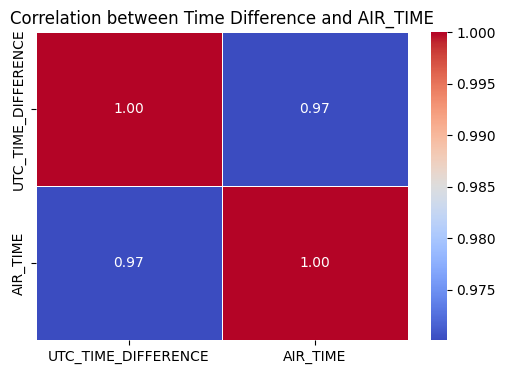

In [69]:
# Compute correlation matrix
correlation_matrix = filtered_df[['UTC_TIME_DIFFERENCE', 'AIR_TIME']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation between Time Difference and AIR_TIME")
plt.show()

*   This analysis proves that the values in time features `ARR_TIME` and `DEP_TIME` that are less than equal to 2 digits, shall be considered as minutes

-  Applying the time changes to the main dataframe

In [70]:
def apply_time_changes(data:pd.DataFrame):
  """
  This function corrects and standardize the time format to the dataframe to main consistency across all data points.

  Args:
    data: pd.DataFrame

  Returns:
    data: pd.DataFrame
  """

  # Converting time format 'HHMM' to 'HH:MM'
  data[['ARR_TIME_FRMT','DEP_TIME_FRMT']] = data[['ARR_TIME','DEP_TIME']].apply(convert_hhmm_to_datetime, args=(['ARR_TIME','DEP_TIME'],), axis = 1)

  # Fetching all the locations from Origin and Destination and taking unique set
  unique_locations = get_unique_locations(data)

  # Mapping timezones to the unique locations
  location_timezone_map = map_loc_to_timezone(unique_locations)


  # Mapping origin city and destination city to corresponding time zones
  data['ORIGIN_CITY_TIME_ZONE'] = data['ORIGIN_CITY_NAME'].map(location_timezone_map)
  data['DEST_CITY_TIME_ZONE'] = data['DEST_CITY_NAME'].map(location_timezone_map)

  # Convert ARR_TIME_FRMT(HH:MM) to UTC Format
  data["ARR_TIME_UTC"] = data.apply(
      lambda row: (
          pd.to_datetime(row["FL_DATE"].strftime('%m/%d/%Y') + " " + row["ARR_TIME_FRMT"].strftime('%H:%M'),format="%m/%d/%Y %H:%M")
          .tz_localize(row["DEST_CITY_TIME_ZONE"])
          .tz_convert("UTC")
      ),
      axis=1
  )

  # Convert DEP_TIME_UTC(HH:MM) to UTC Format
  data["DEP_TIME_UTC"] = data.apply(
      lambda row: (
          pd.to_datetime(row["FL_DATE"].strftime('%m/%d/%Y') + " " + row["DEP_TIME_FRMT"].strftime('%H:%M'),format="%m/%d/%Y %H:%M")
          .tz_localize(row["ORIGIN_CITY_TIME_ZONE"])
          .tz_convert("UTC")
      ),
      axis=1
  )

  # Converting UTC datetime format to UTC HH:MM format
  data["ARR_TIME_UTC"] = data["ARR_TIME_UTC"].dt.strftime("%H:%M")
  data["DEP_TIME_UTC"] = data["DEP_TIME_UTC"].dt.strftime("%H:%M")

  # Convert UTC times to minutes
  data[['ARR_TIME_UTC_MINUTES','DEP_TIME_UTC_MINUTES']] = data.apply(convert_to_minutes, axis=1, args=(['ARR_TIME_UTC','DEP_TIME_UTC'],))

  # Compute time difference
  data['UTC_TIME_DIFFERENCE'] = data['ARR_TIME_UTC_MINUTES'] - data['DEP_TIME_UTC_MINUTES']

  return data


In [71]:
# So, based on above observations on filtered_df, I'm replicating the steps for handling the time format features `ARR_TIME` and `DEP_TIME` into the original dataframe
data = apply_time_changes(data)

In [72]:
#validating if the time difference is in negatives
data.loc[data['UTC_TIME_DIFFERENCE']<=0,:]

Empty DataFrame
Columns: [YEAR, QUARTER, MONTH, DAY_OF_MONTH, DAY_OF_WEEK, FL_DATE, UNIQUE_CARRIER, ORIGIN, ORIGIN_CITY_NAME, ORIGIN_STATE_ABR, DEST, DEST_CITY_NAME, DEST_STATE_ABR, DEP_TIME, ARR_TIME, ARR_DELAY, AIR_TIME, DISTANCE, DISTANCE_GROUP, ARR_TIME_FORMAT_FLG, DEP_TIME_FORMAT_FLG, ARR_TIME_FRMT, DEP_TIME_FRMT, ORIGIN_CITY_TIME_ZONE, DEST_CITY_TIME_ZONE, ARR_TIME_UTC, DEP_TIME_UTC, ARR_TIME_UTC_MINUTES, DEP_TIME_UTC_MINUTES, UTC_TIME_DIFFERENCE]
Index: []

In [73]:
data.sample(10, random_state=20)

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK    FL_DATE  \
82913   2017        3      7            25            2 2017-07-25   
4881    2018        1      3            28            3 2018-03-28   
86366   2017        4     11            13            1 2017-11-13   
39890   2017        3      8            25            5 2017-08-25   
44316   2017        3      7            14            5 2017-07-14   
58963   2018        1      3             1            4 2018-03-01   
107686  2017        4     10            29            7 2017-10-29   
101571  2017        2      5            16            2 2017-05-16   
62854   2017        2      6            16            5 2017-06-16   
52266   2018        1      3            22            4 2018-03-22   

       UNIQUE_CARRIER ORIGIN                ORIGIN_CITY_NAME ORIGIN_STATE_ABR  \
82913              DL    BOS                      Boston, MA               MA   
4881               G4    PIT                  Pittsburgh, PA               PA   
86366              EV    ATL                     Atlanta, GA               GA   
39890              DL    PIT                  Pittsburgh, PA               PA   
44316              DL    OMA                       Omaha, NE               NE   
58963              AA    ATL                     Atlanta, GA               GA   
107686             DL    ABE  Allentown/Bethlehem/Easton, PA               PA   
101571             DL    SJU                    San Juan, PR               PR   
62854              DL    ATL                     Atlanta, GA               GA   
52266              DL    ATL                     Atlanta, GA               GA   

       DEST         DEST_CITY_NAME DEST_STATE_ABR DEP_TIME ARR_TIME  \
82913   ATL            Atlanta, GA             GA     1359     1636   
4881    SAV           Savannah, GA             GA      720      904   
86366   CRW  Charleston/Dunbar, WV             WV     1452     1612   
39890   ATL            Atlanta, GA             GA     1123     1303   
44316   ATL            Atlanta, GA             GA     1743     2118   
58963   CLT          Charlotte, NC             NC      545      647   
107686  ATL            Atlanta, GA             GA      556      800   
101571  ATL            Atlanta, GA             GA     1243     1618   
62854   DAL             Dallas, TX             TX      812      922   
52266   BWI          Baltimore, MD             MD     2107     2303   

        ARR_DELAY  AIR_TIME  DISTANCE DISTANCE_GROUP  ARR_TIME_FORMAT_FLG  \
82913       -11.0       126     946.0              4                 True   
4881         -8.0        81     579.0              3                 True   
86366       -12.0        57     363.0              2                 True   
39890        -2.0        84     526.0              3                 True   
44316        14.0       127     821.0              4                 True   
58963       -13.0        40     226.0              1                 True   
107686       -2.0       108     692.0              3                 True   
101571      -23.0       197    1547.0              7                 True   
62854         2.0        98     721.0              3                 True   
52266         3.0        84     577.0              3                 True   

        DEP_TIME_FORMAT_FLG ARR_TIME_FRMT DEP_TIME_FRMT ORIGIN_CITY_TIME_ZONE  \
82913                  True      16:36:00      13:59:00      America/New_York   
4881                   True      09:04:00      07:20:00      America/New_York   
86366                  True      16:12:00      14:52:00      America/New_York   
39890                  True      13:03:00      11:23:00      America/New_York   
44316                  True      21:18:00      17:43:00       America/Chicago   
58963                  True      06:47:00      05:45:00      America/New_York   
107686                 True      08:00:00      05:56:00      America/New_York   
101571                 True      16:18:00      12:43:00   America/P

#### Validating ORIGIN and DEST features

- Verify the consistency of `ORIGIN` and `DEST` codes to ensure they are unique and consistent across the United States. Each origin code and destination code should correspond to a single airport only, without being assigned to multiple airports. If chk_flag is 0, the data is correct; otherwise, it indicates inconsistency.

In [74]:
def origin_dest_chk(df:pd.DataFrame,columns:list):
    """
    Check if the origin or destination is uniques across all states

    args:
        df : original dataframe
        columns : list of columns to check for ambiguity
    returns:
        new dataframe with frequency counts from groupby and normal value counts with an additional column if both are matching or not
    """
    group_freq_chk_df = df.groupby(by = columns,observed=True, as_index=False).agg(frequency=(columns[0],"count")).sort_values(by="frequency", ascending = False)
    group_freq_chk_df.reset_index(inplace=True)
    origin_freq_df = df[columns[0]].value_counts().reset_index().sort_values(by="count",ascending=False)
    tmp_df = pd.merge(left=group_freq_chk_df, right=origin_freq_df, how = "inner", left_on=columns[0], right_on=columns[0])
    tmp_df['chk_flag'] = tmp_df.apply(lambda row: 0 if row['count'] == row['frequency'] else 1, axis = 1)
    tmp_df.drop(columns = 'index', inplace = True)
    return tmp_df

In [75]:
# Check if the origin codes are consistent and unique within the country
columns = ["ORIGIN","ORIGIN_CITY_NAME","ORIGIN_STATE_ABR"]
origin_chk_df = origin_dest_chk(data,columns)

In [76]:
origin_chk_df.head()

ORIGIN     ORIGIN_CITY_NAME ORIGIN_STATE_ABR  frequency  count  chk_flag
0    ATL          Atlanta, GA               GA      72525  72525         0
1    SAV         Savannah, GA               GA       1977   1977         0
2    LGA         New York, NY               NY       1798   1798         0
3    MCO          Orlando, FL               FL       1751   1751         0
4    FLL  Fort Lauderdale, FL               FL       1577   1577         0

In [77]:
# Validating if any of the origin codes are not consistent
origin_chk_df.loc[origin_chk_df['chk_flag'] == 1,:]

Empty DataFrame
Columns: [ORIGIN, ORIGIN_CITY_NAME, ORIGIN_STATE_ABR, frequency, count, chk_flag]
Index: []

- Based on the above analysis the origin codes are consistent across the united states

In [78]:
# Check if destination codes are consistent and unique within the country
columns = ["DEST",	"DEST_CITY_NAME",	"DEST_STATE_ABR"]
dest_chk_df = origin_dest_chk(data,columns)

In [79]:
dest_chk_df.head()

DEST DEST_CITY_NAME DEST_STATE_ABR  frequency  count  chk_flag
0  ATL    Atlanta, GA             GA      72704  72704         0
1  SAV   Savannah, GA             GA       1932   1932         0
2  LGA   New York, NY             NY       1859   1859         0
3  MCO    Orlando, FL             FL       1818   1818         0
4  ORD    Chicago, IL             IL       1619   1619         0

In [80]:
# Validating if any of the destination codes are not consistent
dest_chk_df.loc[dest_chk_df['chk_flag'] == 1,:]

Empty DataFrame
Columns: [DEST, DEST_CITY_NAME, DEST_STATE_ABR, frequency, count, chk_flag]
Index: []

- The above codes verifies that `ORIGIN` and `DEST` related values are unique and consistent across the country, so these columns does not require any data cleaning

#### Validating `DISTANCE` and `DISTANCE_GROUP`

- Verify `Distance` and `Distance_Group` are consistent or not based on data description: Distance Intervals, every 250 Miles, for Flight Segment

In [81]:
def distance_grp_chk(row):
    """
    Checks if distance group and distance are consistent
    args:
        row -> row containing distance column and distance_group column
    returns:
        if distance group matches with grouping based on Distance Intervals, every 250 Miles, for Flight Segment return True else return False
    """
    if row['DISTANCE'] % 250 == 0:
        if row['DISTANCE']/250 + 1 == int(row['DISTANCE_GROUP']):
            return True
        else:
            return False
    else:
        if math.ceil(row['DISTANCE']/250)==int(row['DISTANCE_GROUP']):
            return True
        else:
            return False

In [82]:
# applying distance_grp_chk function to identify distances which follow and do not follow data description
data['DISTANCE_GROUP_CHK_FLG'] = data[['DISTANCE', 'DISTANCE_GROUP']].apply(distance_grp_chk, axis = 1)

In [83]:
data.loc[data['DISTANCE_GROUP_CHK_FLG']==False,:]

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK    FL_DATE  \
4508    2018        2      4            26            4 2018-04-26   
4752    2017        3      9            14            4 2017-09-14   
5382    2017        2      5            14            7 2017-05-14   
8187    2017        3      7            24            1 2017-07-24   
10058   2017        3      8            17            4 2017-08-17   
10715   2017        3      8             5            6 2017-08-05   
13033   2018        1      3            30            5 2018-03-30   
14017   2017        3      8             4            5 2017-08-04   
14934   2018        1      3            15            4 2018-03-15   
16804   2017        2      6            21            3 2017-06-21   
17040   2017        3      7            18            2 2017-07-18   
17524   2017        4     12            27            3 2017-12-27   
17873   2017        2      5             6            6 2017-05-06   
17899   2018        1      2            27            2 2018-02-27   
19642   2017        3      7            13            4 2017-07-13   
19881   2017        3      7             5            3 2017-07-05   
23893   2018        2      4             4            3 2018-04-04   
24332   2017        2      6            18            7 2017-06-18   
24835   2017        2      5            26            5 2017-05-26   
26589   2017        3      8            14            1 2017-08-14   
26710   2018        2      4             6            5 2018-04-06   
26742   2018        1      1            24            3 2018-01-24   
26802   2017        2      6            25            7 2017-06-25   
26884   2017        4     12            15            5 2017-12-15   
27794   2017        4     10            21            6 2017-10-21   
28112   2017        4     12            26            2 2017-12-26   
28504   2017        4     11             5            7 2017-11-05   
28702   2018        1      2            10            6 2018-02-10   
29753   2018        1      2            27            2 2018-02-27   
30645   2017        4     12            30            6 2017-12-30   
31717   2017        2      6            30            5 2017-06-30   
32662   2017        3      8            19            6 2017-08-19   
33494   2017        3      8            23            3 2017-08-23   
35229   2018        1      2            26            1 2018-02-26   
38299   2017        3      8            21            1 2017-08-21   
38362   2018        1      2            22            4 2018-02-22   
41025   2017        3      8            31            4 2017-08-31   
41290   2018        1      1            28            7 2018-01-28   
41521   2017        3      8            15            2 2017-08-15   
41596   2018        2      4             3            2 2018-04-03   
42009   2017        2      5             2            2 2017-05-02   
42257   2017        3      7            20            4 2017-07-20   
43169   2017        4     10             2            1 2017-10-02   
44267   2017        3      9            17            7 2017-09-17   
45065   2018        1      1            12            5 2018-01-12   
45094   2017        3      9             2            6 2017-09-02   
45207   2017        4     10            28            6 2017-10-28   
45708   2017        3      8            10            4 2017-08-10   
45789   2017        3      8            20            7 2017-08-20   
46015   2017        3      7            12            3 2017-07-12   
46687   2017        4     11            26            7 2017-11-26   
46927   2017        2      5            29            1 2017-05-29   
48287   2017        3      8            22            2 2017-08-22   
48312   2018        1      3            12            1 2018-03-12   
48724   2017        2      6            29            4 2017-06-29   
49085   2018        1      1            11            4 2018-01-11   
53074   2018      

In [84]:
data.loc[data['DISTANCE_GROUP_CHK_FLG']==False,:].shape

(185, 31)

- Based on the above observation and data description `DISTANCE_GROUP` is wrongly calculated for 185 datapoints which have `DISTANCE_GROUP` as `11`

In [85]:
# getting distances related to distance group 11
data[data['DISTANCE_GROUP']=='11']['DISTANCE'].unique()

array([4502., 3417.])

- Based on the above observation, we see that there are only 2 different `DISTANCE` i.e. 4502 and 3417 fall in `DISTANCE_GROUP` 11

In [86]:
# getting value counts of distance groups
data['DISTANCE_GROUP'].value_counts()

DISTANCE_GROUP
3     53749
2     39433
1     18951
4     18855
7      5580
9      3908
8      3900
5      2634
6       790
11      185
Name: count, dtype: int64

In [87]:
data['DISTANCE'].max()

np.float64(4502.0)

- Based on the above observation the maximum distance covered by a flight is 4502

In [88]:
data.loc[data['DISTANCE_GROUP']=='11',['UNIQUE_CARRIER','ORIGIN', 'DEST', 'DISTANCE', 'DISTANCE_GROUP' ,'DISTANCE_GROUP_CHK_FLG']].value_counts()

UNIQUE_CARRIER  ORIGIN  DEST  DISTANCE  DISTANCE_GROUP  DISTANCE_GROUP_CHK_FLG
DL              ATL     HNL   4502.0    11              False                     88
                HNL     ATL   4502.0    11              False                     61
                ANC     ATL   3417.0    11              False                     18
                ATL     ANC   3417.0    11              False                     18
Name: count, dtype: int64

- Based on the above observation there is only one unique carrier i.e. DL which travel between 2 pair of origins and destinations which falls under `DISTANCE_GROUP` 11

In [89]:
# getting count of distance groups for DL Carrier
dl_dist_grp_freq_df = data.loc[data['UNIQUE_CARRIER']=='DL',['DISTANCE_GROUP']].value_counts().reset_index()

In [90]:
dl_dist_grp_freq_df

DISTANCE_GROUP  count
0              3  31575
1              2  28501
2              4  12829
3              1  10552
4              7   4085
5              9   3188
6              8   2750
7              5   1509
8              6    757
9             11    185

In [91]:
#  calculating percentage that distance group occupies in DL carrier
dl_dist_grp_freq_df['percent'] = round((dl_dist_grp_freq_df['count']/dl_dist_grp_freq_df['count'].sum())*100,2)

In [92]:
dl_dist_grp_freq_df

DISTANCE_GROUP  count  percent
0              3  31575    32.91
1              2  28501    29.71
2              4  12829    13.37
3              1  10552    11.00
4              7   4085     4.26
5              9   3188     3.32
6              8   2750     2.87
7              5   1509     1.57
8              6    757     0.79
9             11    185     0.19

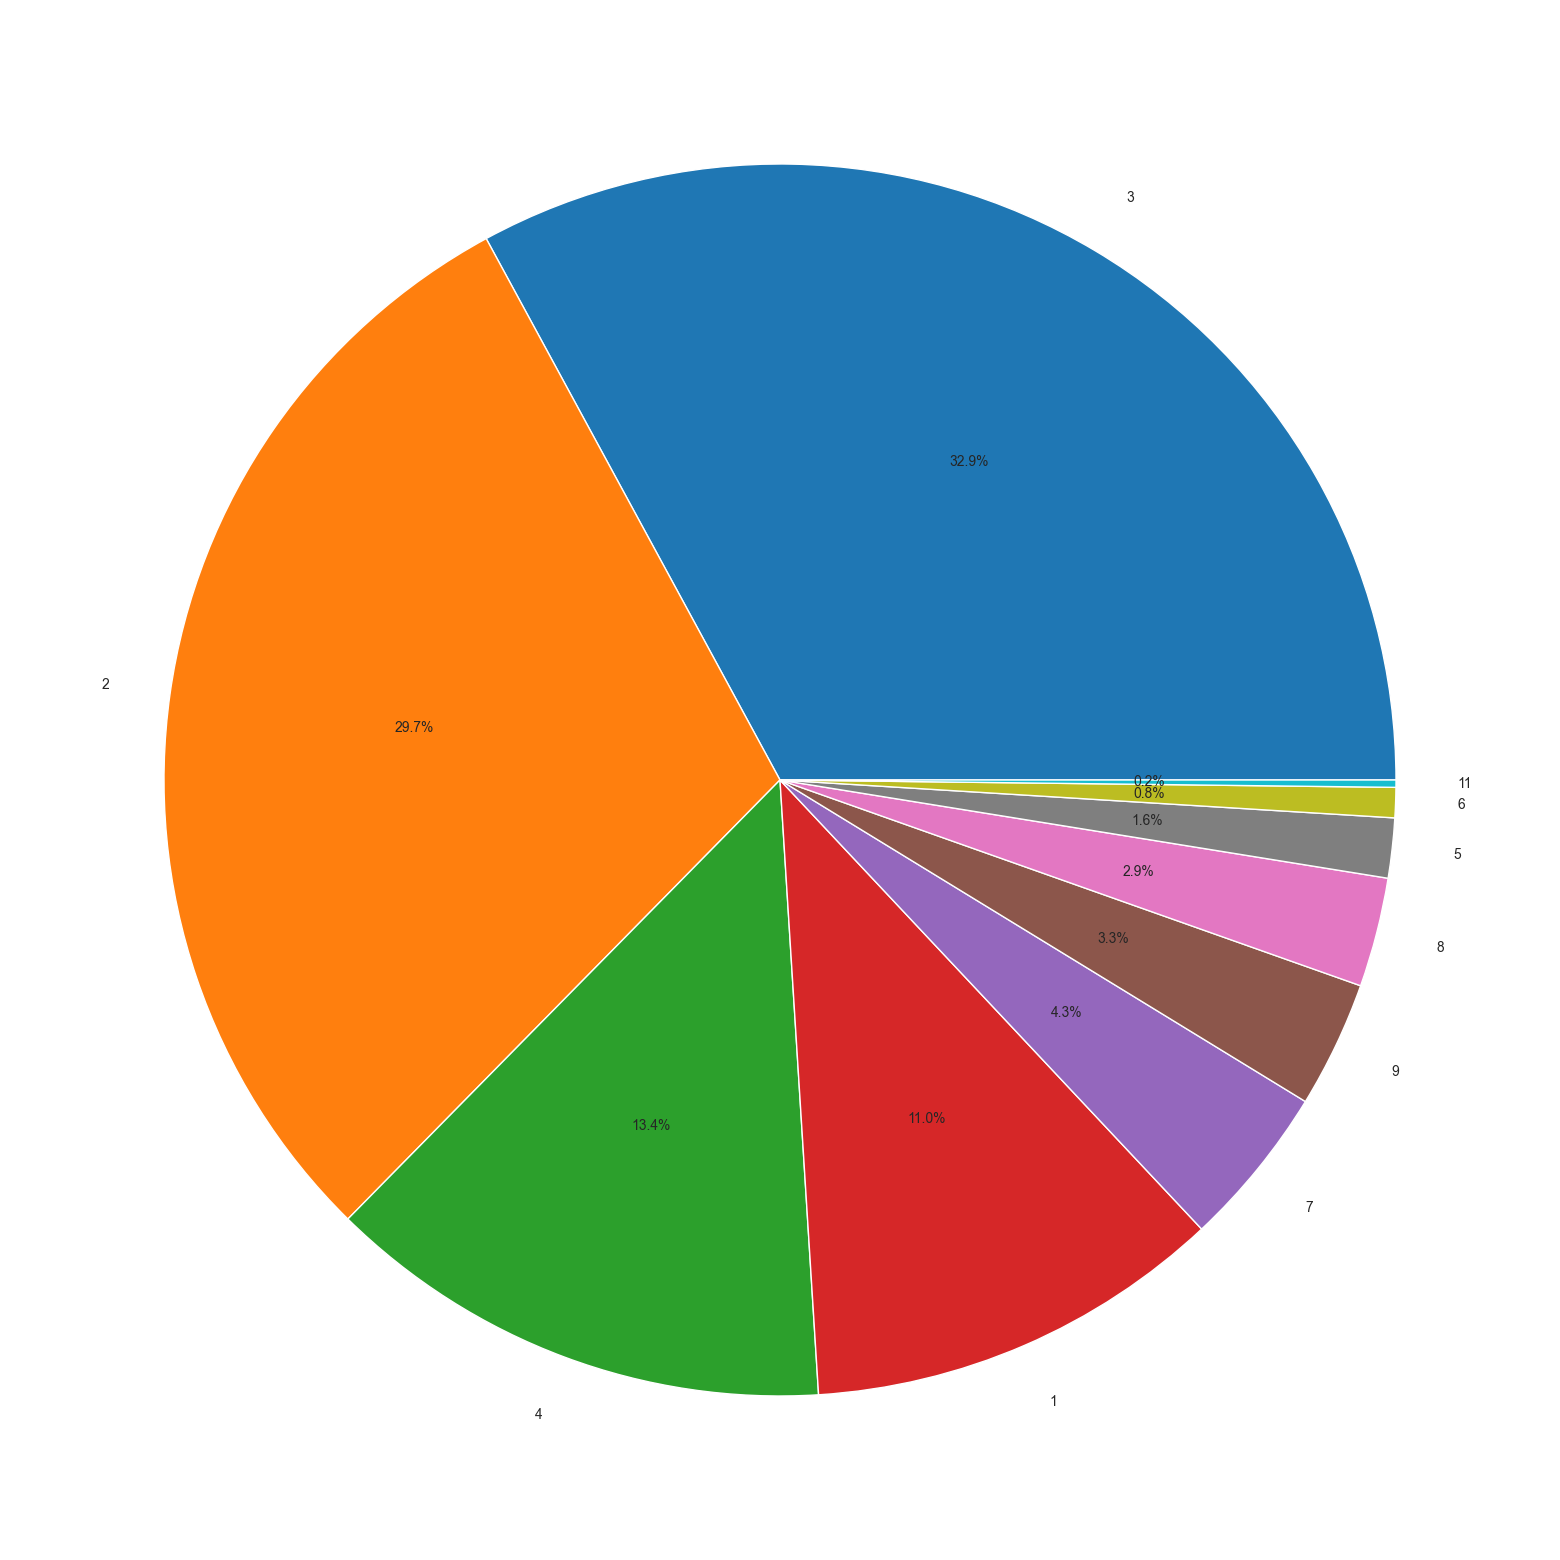

In [93]:
#  Plotted pie plot to visualize the percentage of each distance group in DL
sns.set_style("whitegrid")
plt.figure(figsize=(20,20))
plt.pie(dl_dist_grp_freq_df['percent'], labels=dl_dist_grp_freq_df['DISTANCE_GROUP'], autopct='%1.1f%%')
plt.show()

- Based on the above visualization 0.2% of DL (`UNIQUE_CARRIER`) `DISTANCE_GROUP`(11) is calculated wrongly

In [94]:
def correct_distance_grps(cell):
    """
    Adjusts the distance group classification based on the distance value.
    Args:
        cell: The cell containing the DISTANCE column.
    Returns:
        The corresponding DISTANCE_GROUP.
    """
    if cell % 250 == 0:
        return int(cell/250 + 1)
    else:
        return int(math.ceil(cell/250))

In [95]:
# Correcting the distance group for distance group 11
data['DISTANCE_GROUP'] = data['DISTANCE_GROUP'].astype(int)
data.loc[data['DISTANCE_GROUP_CHK_FLG']==False,'DISTANCE_GROUP'] = data.loc[data['DISTANCE_GROUP_CHK_FLG']==False,'DISTANCE'].apply(correct_distance_grps)
data['DISTANCE_GROUP'] = data['DISTANCE_GROUP'].astype('category')

In [96]:
# Checking if all the distance group is fixed or not
data['DISTANCE_GROUP_CHK_FLG'] = data[['DISTANCE', 'DISTANCE_GROUP']].apply(distance_grp_chk, axis = 1)

In [97]:
data.loc[data['DISTANCE_GROUP_CHK_FLG']==False,:]

Empty DataFrame
Columns: [YEAR, QUARTER, MONTH, DAY_OF_MONTH, DAY_OF_WEEK, FL_DATE, UNIQUE_CARRIER, ORIGIN, ORIGIN_CITY_NAME, ORIGIN_STATE_ABR, DEST, DEST_CITY_NAME, DEST_STATE_ABR, DEP_TIME, ARR_TIME, ARR_DELAY, AIR_TIME, DISTANCE, DISTANCE_GROUP, ARR_TIME_FORMAT_FLG, DEP_TIME_FORMAT_FLG, ARR_TIME_FRMT, DEP_TIME_FRMT, ORIGIN_CITY_TIME_ZONE, DEST_CITY_TIME_ZONE, ARR_TIME_UTC, DEP_TIME_UTC, ARR_TIME_UTC_MINUTES, DEP_TIME_UTC_MINUTES, UTC_TIME_DIFFERENCE, DISTANCE_GROUP_CHK_FLG]
Index: []

In [98]:
data['DISTANCE_GROUP'].value_counts().reset_index().sort_values(by='count', ascending=False)

DISTANCE_GROUP  count
0               3  53749
1               2  39433
2               1  18951
3               4  18855
4               7   5580
5               9   3908
6               8   3900
7               5   2634
8               6    790
9              19    149
10             14     36

- Based on the above changes `DISTANCE_GROUP` values are corrected by recalculating based on data description where it is Distance Intervals, every 250 Miles, for Flight Segment

#### Handling Target class ARR_DELAY

- ARR_DELAY less than equal to 0 is considered as on-time and greater than 0 is considered as delay

In [99]:
def convert_arr_delay_to_class(delay_num):
    """Classify arrival delays into categorical classes.

    Args:
        delay_num (int): Arrival Delay in minutes

    Returns:
        str: class type for arrival time
            - "On-Time" for early or on-time arrivals.
            - "Delay" for delayed arrivals.

    """
    if delay_num<=0:
        return "On-Time"
    else:
        return "Delay"

In [100]:
#  applying convert_arr_delay_to_class to convert continous to categorical
data['ARR_DELAY_CLS'] = data['ARR_DELAY'].apply(convert_arr_delay_to_class)

- Created `ARR_DELAY_CLS` which has `On-Time` and `Delay` where greater than 0 minutes is `Delay` and less than or equal to 0 minutes is `On-Time`

In [101]:
data['ARR_DELAY_CLS'].value_counts()

ARR_DELAY_CLS
On-Time    103259
Delay       44726
Name: count, dtype: int64

In [102]:
data.shape

(147985, 32)

In [103]:
data.head(10)

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK    FL_DATE UNIQUE_CARRIER  \
0  2017        3      7            11            2 2017-07-11             DL   
1  2018        1      3            14            3 2018-03-14             DL   
2  2017        4     11            12            7 2017-11-12             WN   
3  2017        3      8            22            2 2017-08-22             EV   
4  2018        1      3             2            5 2018-03-02             DL   
5  2017        4     10            12            4 2017-10-12             DL   
6  2017        3      7            15            6 2017-07-15             DL   
7  2017        3      9            28            4 2017-09-28             AA   
8  2017        3      7            23            7 2017-07-23             WN   
9  2018        1      1            14            7 2018-01-14             DL   

  ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR DEST    DEST_CITY_NAME  \
0    LIT  Little Rock, AR               AR  ATL       Atlanta, GA   
1    BOS       Boston, MA               MA  ATL       Atlanta, GA   
2    ATL      Atlanta, GA               GA  DAL        Dallas, TX   
3    ATL      Atlanta, GA               GA  HPN  White Plains, NY   
4    MSY  New Orleans, LA               LA  ATL       Atlanta, GA   
5    SAN    San Diego, CA               CA  ATL       Atlanta, GA   
6    MKE    Milwaukee, WI               WI  ATL       Atlanta, GA   
7    ATL      Atlanta, GA               GA  PHL  Philadelphia, PA   
8    ATL      Atlanta, GA               GA  PIT    Pittsburgh, PA   
9    DTW      Detroit, MI               MI  ATL       Atlanta, GA   

  DEST_STATE_ABR DEP_TIME ARR_TIME  ARR_DELAY  AIR_TIME  DISTANCE  \
0             GA      538      757      -11.0        64     453.0   
1             GA     1829     2108      -23.0       127     946.0   
2             TX     1345     1451       -9.0       106     721.0   
3             NY     1158     1408      -21.0       113     780.0   
4             GA      522      737      -19.0        59     425.0   
5             GA      818     1513      -16.0       212    1892.0   
6             GA      601      856       -2.0        97     669.0   
7             PA     1520     1727       -2.0       102     666.0   
8             PA      904     1039        4.0        75     526.0   
9             GA     2028     2224      -24.0        89     594.0   

  DISTANCE_GROUP  ARR_TIME_FORMAT_FLG  DEP_TIME_FORMAT_FLG ARR_TIME_FRMT  \
0              2                 True                 True      07:57:00   
1              4                 True                 True      21:08:00   
2              3                 True                 True      14:51:00   
3              4                 True                 True      14:08:00   
4              2                 True                 True      07:37:00   
5              8                 True                 True      15:13:00   
6              3                 True                 True      08:56:00   
7              3                 True                 True      17:27:00   
8              3                 True                 True      10:39:00   
9              3                 True                 True      22:24:00   

  DEP_TIME_FRMT ORIGIN_CITY_TIME_ZONE DEST_CITY_TIME_ZONE ARR_TIME_UTC  \
0      05:38:00       America/Chicago    America/New_York        11:57   
1      18:29:00      America/New_York    America/New_York        01:08   
2      13:45:00      America/New_York     America/Chicago        20:51   
3      11:58:00      America/New_York    America/New_York        18:08   
4      05:22:00       America/Chicago    America/New_York        12:37   
5      08:18:00   America/Los_Angeles    America/New_York        19:13   
6      06:01:00       America/Chicago    America/New_York        12:56   
7      15:20:00      America/New_York    America/New_York        21:27   
8      09:04:00      America/New_York    America/New_York        14:39   
9      20:28:00       Ame

# Data Analysis

In [104]:
data.columns

Index(['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE',
       'UNIQUE_CARRIER', 'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR',
       'DEST', 'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEP_TIME', 'ARR_TIME',
       'ARR_DELAY', 'AIR_TIME', 'DISTANCE', 'DISTANCE_GROUP',
       'ARR_TIME_FORMAT_FLG', 'DEP_TIME_FORMAT_FLG', 'ARR_TIME_FRMT',
       'DEP_TIME_FRMT', 'ORIGIN_CITY_TIME_ZONE', 'DEST_CITY_TIME_ZONE',
       'ARR_TIME_UTC', 'DEP_TIME_UTC', 'ARR_TIME_UTC_MINUTES',
       'DEP_TIME_UTC_MINUTES', 'UTC_TIME_DIFFERENCE', 'DISTANCE_GROUP_CHK_FLG',
       'ARR_DELAY_CLS'],
      dtype='object')

In [105]:
data.describe(include=['int', 'float'])

YEAR        QUARTER          MONTH   DAY_OF_MONTH  \
count  147985.000000  147985.000000  147985.000000  147985.000000   
mean     2017.342825       2.462655       6.374187      15.775788   
std         0.474655       1.103377       3.380079       8.773347   
min      2017.000000       1.000000       1.000000       1.000000   
25%      2017.000000       1.000000       3.000000       8.000000   
50%      2017.000000       2.000000       6.000000      16.000000   
75%      2018.000000       3.000000       9.000000      23.000000   
max      2018.000000       4.000000      12.000000      31.000000   

         DAY_OF_WEEK     ARR_DELAY       AIR_TIME       DISTANCE  \
count  147985.000000  147985.00000  147985.000000  147985.000000   
mean        3.898679       1.87642      93.449208     658.072420   
std         1.987838      44.00414      55.386738     469.326366   
min         1.000000    -173.00000      15.000000      83.000000   
25%         2.000000     -15.00000      60.000000     373.000000   
50%         4.000000      -7.00000      83.000000     566.000000   
75%         6.000000       4.00000     106.000000     746.000000   
max         7.000000    1455.00000     631.000000    4502.000000   

       ARR_TIME_UTC_MINUTES  DEP_TIME_UTC_MINUTES  UTC_TIME_DIFFERENCE  
count         147985.000000          147985.00000        147985.000000  
mean            1000.729560             883.16157           117.567990  
std              398.628806             393.71616            57.090411  
min               40.000000               0.00000             3.000000  
25%              812.000000             711.00000            82.000000  
50%             1066.000000             947.00000           106.000000  
75%             1308.000000            1191.00000           132.000000  
max             1833.000000            1439.00000           660.000000

In [106]:
data.describe(include=['object', 'category', 'string'])

UNIQUE_CARRIER  ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR    DEST  \
count          147985  147985           147985           147985  147985   
unique             16     167              162               50     166   
top                DL     ATL      Atlanta, GA               GA     ATL   
freq            95931   72525            72525            75636   72704   

       DEST_CITY_NAME DEST_STATE_ABR DEP_TIME ARR_TIME  DISTANCE_GROUP  \
count          147985         147985   147985   147985          147985   
unique            161             50     1289     1381              11   
top       Atlanta, GA             GA      557     1120               3   
freq            72704          75769      629      219           53749   

       ARR_TIME_FRMT DEP_TIME_FRMT ORIGIN_CITY_TIME_ZONE DEST_CITY_TIME_ZONE  \
count         147985        147985                147985              147985   
unique          1381          1289                    12                  12   
top         11:20:00      05:57:00      America/New_York    America/New_York   
freq             219           629                112615              112665   

       ARR_TIME_UTC DEP_TIME_UTC ARR_DELAY_CLS  
count        147985       147985        147985  
unique         1418         1403             2  
top           22:05        10:55       On-Time  
freq            191          404        103259

In [107]:
color_mapping = {
    'Delay': '#ff7f0e',  # Orange for delays
    'On-Time': '#1f77b4'  # Blue for on-time flights
}

In [108]:
def get_count_plot(x,data,title,x_label,y_label,hue,total,figsize):
    """
        Plots a count plot with annotated percentages on each bar.

        Args:
            x: The name of the column in 'data' to be plotted on the x-axis.
            data: The DataFrame containing the data.
            title: The title of the plot.
            x_label: Label for the x-axis.
            y_label: Label for the y-axis.
            hue: (Optional) Name of the column in 'data' to color-code the bars.
            total: The total count used to calculate percentage of each bar.
            figsize: Tuple representing the figure size (width, height).
    """
    plt.figure(figsize=figsize)
    if hue:
        ax = sns.countplot(x=x,hue=hue, data=data,legend=True)
    else:
        ax = sns.countplot(x=x, data=data,legend=True)
    for p in ax.patches:
        percentage = 100 * p.get_height() / total
        if percentage>0.000000001:
            ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, p.get_height()),
                        ha='center', va='bottom', fontsize=12, fontweight='bold')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if hue:
        ax.legend(title=hue, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=0)
    plt.show()


In [109]:
def get_bar_plot(x,y,hue,data,order,palette,title,x_label,y_label,figsize):
    """
        Creates a bar plot with annotated percentage values on each bar.

        Args:
            x: The name of the column in 'data' to be used for the x-axis.
            y: The name of the column in 'data' to be used for the y-axis.
            hue: The name of the column in 'data' to use for color-coding (grouping).
            data: The DataFrame containing the data.
            order: The order in which to display the categorical levels on the x-axis.
            palette: The color palette to use for the bars.
            title: The title of the plot.
            x_label: The label for the x-axis.
            y_label: The label for the y-axis.
            figsize: Tuple representing the size of the figure (width, height).
    """

    plt.figure(figsize=figsize)
    ax = sns.barplot(
    x=x,
    y=y,
    hue=hue,
    data=data,
    order = order,
    palette= palette)

    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # exclude zeros
            ax.annotate(
                f'{height:.1f}%',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=10,fontweight='bold')

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    ax.legend(title=hue, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [110]:
def get_outlier_datapoints(data,col_name):
    """
    Identifies outlier datapoints in a specified column of a DataFrame using the Interquartile Range (IQR) method.
    Args:
        data(pd.DataFrame) - data to use for calculating outlier
        col_name (str) - column to apply outlier analysis on

    Return:
        lower_bound_outlier_datapoints (pd.DataFrame): datapoints which are less than lower bound
        upper_bound_outlier_datapoints (pd.DataFrame): datapoints which are more than upper bound
        lower_bound (float): lower bound value
        upper_bound (float): upper bound value

    """
    Q1 = data[col_name].quantile(0.25)
    Q3 = data[col_name].quantile(0.75)
    IQR = Q3-Q1
    lower_bound = Q1-1.5*IQR
    upper_bound = Q3+1.5*IQR
    lower_bound_outlier_datapoints = data[(data[col_name]<lower_bound)]
    upper_bound_outlier_datapoints = data[(data[col_name]>upper_bound)]
    return lower_bound_outlier_datapoints,upper_bound_outlier_datapoints, lower_bound, upper_bound

## `AIR_TIME` Analysis

In [111]:
data['AIR_TIME'].describe()

count    147985.000000
mean         93.449208
std          55.386738
min          15.000000
25%          60.000000
50%          83.000000
75%         106.000000
max         631.000000
Name: AIR_TIME, dtype: float64

##### Summary of `AIR_TIME`
- On an average the air time of flights are `93.45 minutes`
- `Standard Deviation` of the air time is `55.4 minutes`
- `Shortest` time flight taken is `15 minutes` and `longest` is `631 minutes`(approxiamtely 10.5 hrs)
- `25%` of the flights have air time of `60 minutes` or less
- `50%` of the flights have air time of `83 minutes` or less
- `75%` of the flights have air time of `106 minutes` or less
- Based on this summary statistics mean is greater than median(50 percentile) so, it is right skewed  

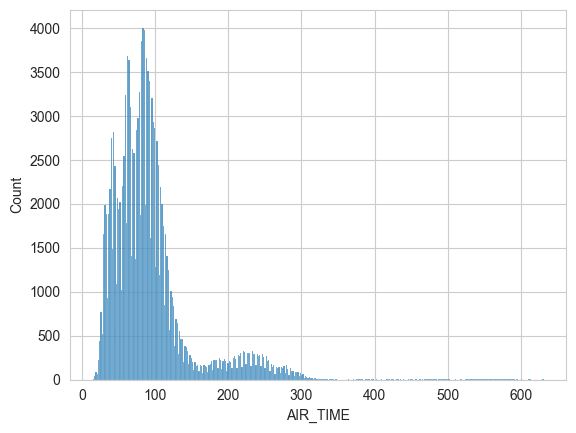

In [112]:
# visualization of the distribution of the AIR_TIME
sns.histplot(x='AIR_TIME', data=data)
plt.show()

- Based on the above visualization the data is right skewed which is confirmed

### Outlier Detection `AIR_TIME`

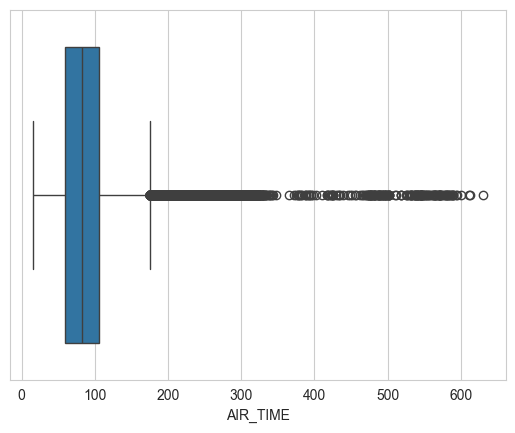

In [113]:
# box plot visualization of AIR_TIME
sns.boxplot(x='AIR_TIME', data=data)
plt.show()

- Based on the above visualization we can observe that there are outliers

In [114]:
# Retrieving the outlier datapoints
air_time_lower_outlier, air_time_upper_outlier, air_time_lower_bound, air_time_upper_bound = get_outlier_datapoints(data,'AIR_TIME')

In [115]:
# Outlier margin for lower and upper region
air_time_lower_bound, air_time_upper_bound

(np.float64(-9.0), np.float64(175.0))

In [116]:
air_time_lower_outlier.shape

(0, 32)

In [117]:
air_time_upper_outlier.shape

(13814, 32)

- Based on the outlier detection formula there are total `13814 outliers` for `AIR_TIME`.
- We need to verify if we these outliers are needed to be dropped or not. If these outliers are correct records, we need to proceed without dropping these outliers.
- Based on subjective knowledge, we believe `AIR_TIME` should be positively correlated with `DISTANCE`. For example, if distance increases, air time of the flight also should increase.
- Thats why `DISTANCE` is the next feature as part of the analysis

## `DISTANCE` Analysis

In [118]:
data['DISTANCE'].describe()

count    147985.000000
mean        658.072420
std         469.326366
min          83.000000
25%         373.000000
50%         566.000000
75%         746.000000
max        4502.000000
Name: DISTANCE, dtype: float64

##### Summary of `DISTANCE`
- On an average the distance between the airports is `658.07 miles`
- Standard Deviation of `469.33 miles` is huge
- Shortest distance between two airports is `83 miles` and longesr is `4502 miles`
- `25%` of the distance between airports are `373 miles` or less
- `50%` of the distance between airports are `566 miles` or less
- `75%` of the distance between airports are `746 miles` or less
- Based on this summary statistics mean is greater than median(50 percentile) so, it is right skewed  

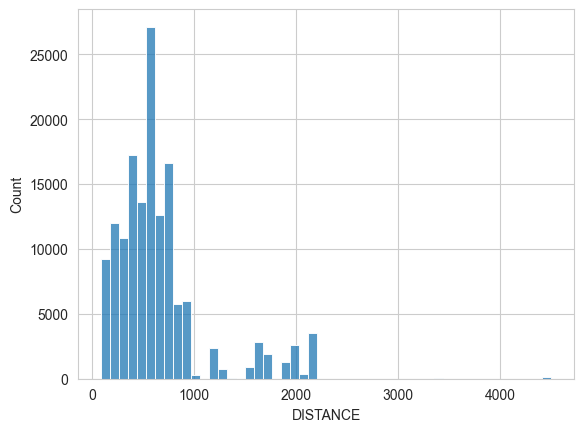

In [119]:
# visualization of the distribution of the DISTANCE
sns.histplot(x='DISTANCE', data=data,bins=50)
plt.show()

- Based on the above visualization the data is right skewed which is confirmed

### Outlier Detection for `DISTANCE`

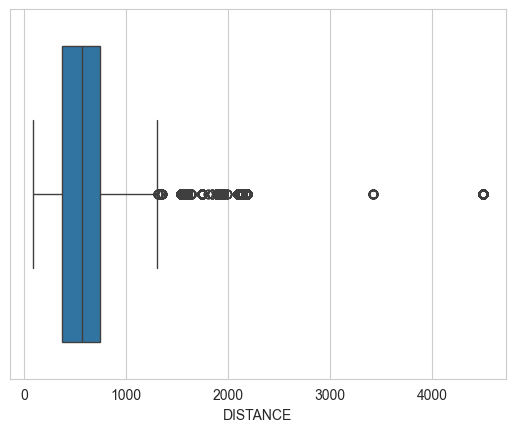

In [120]:
# box plot visualization of DISTANCE
sns.boxplot(x='DISTANCE', data=data)
plt.show()

- Based on the above visualization we can observe that there are outliers

In [121]:
distance_lower_outlier, distance_upper_outlier, distance_lower_bound, distance_upper_bound = get_outlier_datapoints(data,'DISTANCE')

In [122]:
# Outlier margin for lower and upper region
distance_lower_bound, distance_upper_bound

(np.float64(-186.5), np.float64(1305.5))

In [123]:
distance_lower_outlier.shape

(0, 32)

In [124]:
distance_upper_outlier.shape

(13673, 32)

- Based on the outlier detection formula there are total `13673 outliers` for `DISTANCE`
- We observe here that the number of outliers in `AIR_TIME` is greater than that of `DISTANCE`
- We need to check how many of these outliers are same datapoints and how many are not.
- So, now we need to conduct analysis considering both `AIR_TIME` and `DISTANCE`

#### Outlier Analysis using `AIR_TIME` and `DISTANCE`

In [125]:
# Convert each row to a tuple
set1 = set(air_time_upper_outlier.apply(tuple, axis=1))
set2 = set(distance_upper_outlier.apply(tuple, axis=1))

- Converting `AIR_TIME` and `DISTANCE` outliers to `SET` type to find the non overlapping and overlapping outliers

In [126]:
# Compute the symmetric difference to find the non-overlapping outliers between air_time and distance:
sym_diff = set1.symmetric_difference(set2) # This equals (set1 ∪ set2) - (set1 ∩ set2)

In [127]:
# Convert the result back to a DataFrame
df_diff = pd.DataFrame(list(sym_diff), columns=air_time_upper_outlier.columns)

In [128]:
df_diff.shape

(751, 32)

- There are 751 datapoints which are non overlapping outliers

In [129]:
# Get the common datapoints of air time outliers and distance outliers
common_set = set1.intersection(set2)

In [130]:
df_common_tuples = pd.DataFrame(list(common_set), columns=air_time_upper_outlier.columns)

In [131]:
df_common_tuples.shape

(13368, 32)

- There are 13368 datapoints which are overlapping outliers

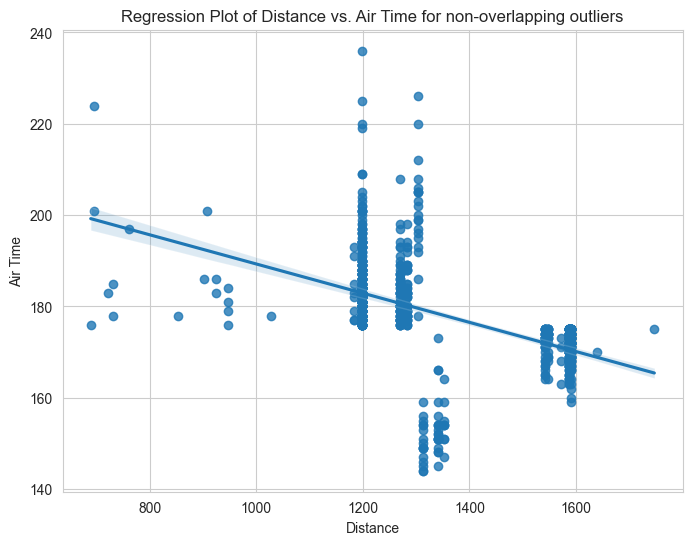

In [132]:
# Regression Plot with Distance versus Airtime for non-overlapping outliers
plt.figure(figsize=(8, 6))
sns.regplot(x='DISTANCE', y='AIR_TIME', data=df_diff)
plt.title('Regression Plot of Distance vs. Air Time for non-overlapping outliers')
plt.xlabel('Distance')
plt.ylabel('Air Time')
plt.show()

- Based on the above regression plot, we observe that non-overlapping outliers are negatively correlated with `DISTANCE` and `AIR_TIME`, which means that if distance increases then air time of the flight reduces, which is logically impossible
- We can also observe that the relation between `AIR_TIME` and `DISTANCE` is completely random.

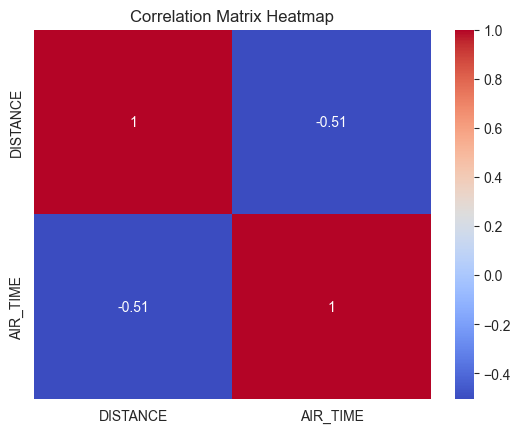

In [133]:
# Computing correlation between `DISTANCE` and `AIR_TIME` for non-overlapping outliers
corr_matrix = df_diff[['DISTANCE', 'AIR_TIME']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

 - In the above correlation heatmap, we observe that non-overlapping outliers are negatively correlated, which is logically impossible

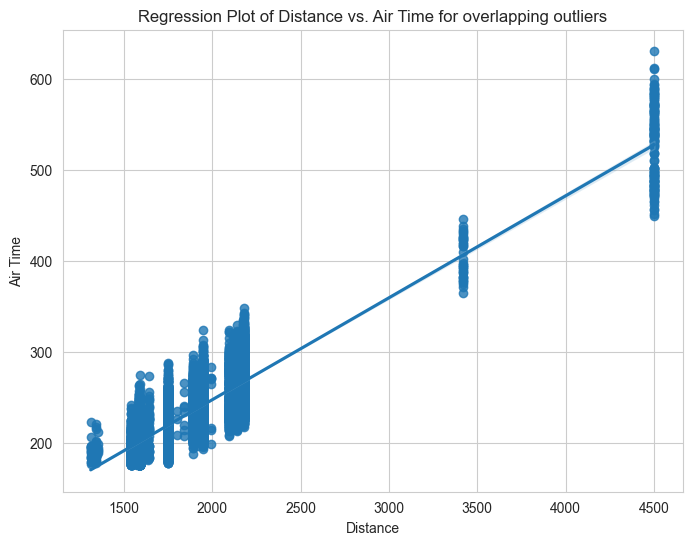

In [134]:
# Regression Plot with Distance versus Air_Time for overlapping outliers
plt.figure(figsize=(8, 6))
sns.regplot(x='DISTANCE', y='AIR_TIME', data=df_common_tuples)
plt.title('Regression Plot of Distance vs. Air Time for overlapping outliers')
plt.xlabel('Distance')
plt.ylabel('Air Time')
plt.show()

- From the above regression plot, we observe that the relation between `AIR_TIME` and `DISTANCE` is positively correlated, which is logically possible.

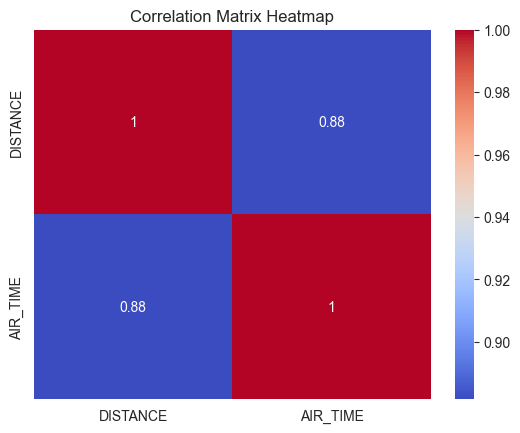

In [135]:
# Computing correlation between `DISTANCE` and `AIR_TIME` for overlapping outliers
corr_matrix = df_common_tuples[['DISTANCE', 'AIR_TIME']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

- In above correlation heatmap, I observed that there is strong positive correlation between `AIR_TIME` and `DISTANCE`, which is logically possible.

Based on the visualization of the above box plots and outlier detection analysis both the `AIR_TIME` and `DISTANCE` have different number of outlier data points

Non-Overlapping Outliers:
- To verify that these outliers are valid data points or not, I checked correlation for the datapoints which are non-overlapping between air time and distance outliers.
- Based on this I understood that they are negatively correlated and random.
- I observed that when distance is increasing then air time is decreasing which is logically wrong.

Overlapping Outliers:
- To verify that these outliers are valid data points or not, I checked correlation for the datapoints which are overlapping between air time and distance outliers.
- Based on this I understood that they have strong positive correlation between them.
- So, these data points which are overlapping are valid datapoints.

In [136]:
df_diff.shape

(751, 32)

In [137]:
data.shape

(147985, 32)

In [138]:
# dropping non-overlapping outliers
df_main_tuples = data.apply(tuple, axis=1)
df_outlier_tuples = set(df_diff.apply(tuple, axis=1))

# Keep only rows that are NOT in df_outlier
data = data[~df_main_tuples.isin(df_outlier_tuples)]

print("DataFrame without outliers:")
print(data.shape)


DataFrame without outliers:
(147234, 32)


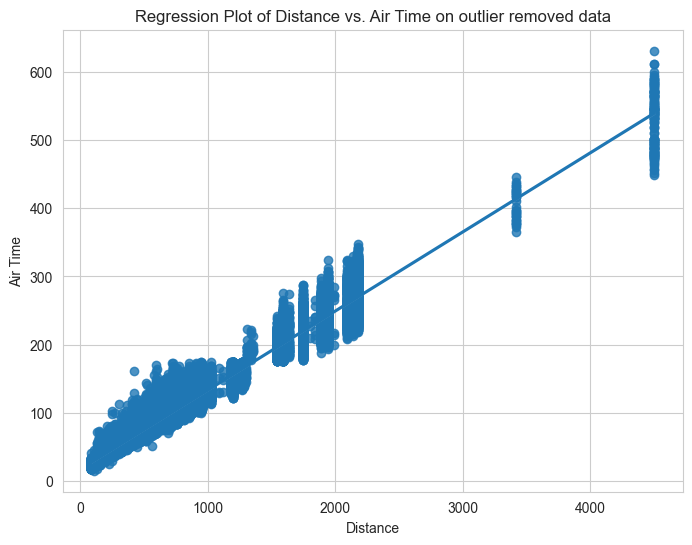

In [139]:
# Regression Plot between Distance and Airtime on outlier removed data
plt.figure(figsize=(8, 6))
sns.regplot(x='DISTANCE', y='AIR_TIME', data=data)
plt.title('Regression Plot of Distance vs. Air Time on outlier removed data')
plt.xlabel('Distance')
plt.ylabel('Air Time')
plt.show()

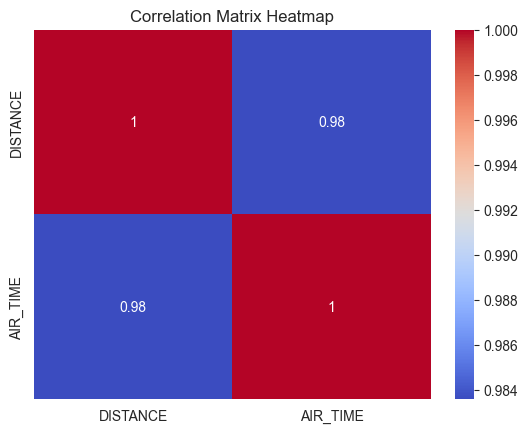

In [140]:
# Computing correlation between `DISTANCE` and `AIR_TIME` after removing outliers
corr_matrix = data[['DISTANCE', 'AIR_TIME']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

- Based on the Regression plot and correlation plot between DISTANCE and AIR_TIME we can understand that both are highly correlated and has strong upward linear trend implying longer distances having longer air times

## `SCHEDULED ARRIVAL` and `DEPARTURE` Analysis

In [141]:
data.head()

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK    FL_DATE UNIQUE_CARRIER  \
0  2017        3      7            11            2 2017-07-11             DL   
1  2018        1      3            14            3 2018-03-14             DL   
2  2017        4     11            12            7 2017-11-12             WN   
3  2017        3      8            22            2 2017-08-22             EV   
4  2018        1      3             2            5 2018-03-02             DL   

  ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR DEST    DEST_CITY_NAME  \
0    LIT  Little Rock, AR               AR  ATL       Atlanta, GA   
1    BOS       Boston, MA               MA  ATL       Atlanta, GA   
2    ATL      Atlanta, GA               GA  DAL        Dallas, TX   
3    ATL      Atlanta, GA               GA  HPN  White Plains, NY   
4    MSY  New Orleans, LA               LA  ATL       Atlanta, GA   

  DEST_STATE_ABR DEP_TIME ARR_TIME  ARR_DELAY  AIR_TIME  DISTANCE  \
0             GA      538      757      -11.0        64     453.0   
1             GA     1829     2108      -23.0       127     946.0   
2             TX     1345     1451       -9.0       106     721.0   
3             NY     1158     1408      -21.0       113     780.0   
4             GA      522      737      -19.0        59     425.0   

  DISTANCE_GROUP  ARR_TIME_FORMAT_FLG  DEP_TIME_FORMAT_FLG ARR_TIME_FRMT  \
0              2                 True                 True      07:57:00   
1              4                 True                 True      21:08:00   
2              3                 True                 True      14:51:00   
3              4                 True                 True      14:08:00   
4              2                 True                 True      07:37:00   

  DEP_TIME_FRMT ORIGIN_CITY_TIME_ZONE DEST_CITY_TIME_ZONE ARR_TIME_UTC  \
0      05:38:00       America/Chicago    America/New_York        11:57   
1      18:29:00      America/New_York    America/New_York        01:08   
2      13:45:00      America/New_York     America/Chicago        20:51   
3      11:58:00      America/New_York    America/New_York        18:08   
4      05:22:00       America/Chicago    America/New_York        12:37   

  DEP_TIME_UTC  ARR_TIME_UTC_MINUTES  DEP_TIME_UTC_MINUTES  \
0        10:38                   717                   638   
1        22:29                  1508                  1349   
2        18:45                  1251                  1125   
3        15:58                  1088                   958   
4        11:22                   757                   682   

   UTC_TIME_DIFFERENCE  DISTANCE_GROUP_CHK_FLG ARR_DELAY_CLS  
0                   79                    True       On-Time  
1                  159                    True       On-Time  
2                  126                    True       On-Time  
3                  130                    True       On-Time  
4                   75                    True       On-Time

In [142]:
def generate_schd_arrival_time(row, columns):
  """
  This function generates scheduled arrival time from arrival delay and actula arrival time based on the logic provided in data description.

  Args:
    row: pd.Series
    columns: list of column names

  Returns:
    pd.to_datetime
  """

  # Convert to total minutes from midnight
  arr_time = row[columns[0]]
  if isinstance(arr_time, str):
    hrs, mins = map(int, arr_time.split(':'))
  else:
    hrs, mins = map(int, arr_time.strftime('%H:%M').split(':'))
  delay = int(row[columns[1]])
  total_minutes = hrs * 60 + mins

  # Apply delay (this can be negative)
  new_total_minutes = (total_minutes + delay) % (24 * 60)

  # Convert back to hours and minutes
  new_hours = new_total_minutes // 60
  new_minutes = new_total_minutes % 60

  return pd.to_datetime(str(new_hours).zfill(2)+str(new_minutes).zfill(2), format='%H%M').time()


In [143]:
data.head()

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK    FL_DATE UNIQUE_CARRIER  \
0  2017        3      7            11            2 2017-07-11             DL   
1  2018        1      3            14            3 2018-03-14             DL   
2  2017        4     11            12            7 2017-11-12             WN   
3  2017        3      8            22            2 2017-08-22             EV   
4  2018        1      3             2            5 2018-03-02             DL   

  ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR DEST    DEST_CITY_NAME  \
0    LIT  Little Rock, AR               AR  ATL       Atlanta, GA   
1    BOS       Boston, MA               MA  ATL       Atlanta, GA   
2    ATL      Atlanta, GA               GA  DAL        Dallas, TX   
3    ATL      Atlanta, GA               GA  HPN  White Plains, NY   
4    MSY  New Orleans, LA               LA  ATL       Atlanta, GA   

  DEST_STATE_ABR DEP_TIME ARR_TIME  ARR_DELAY  AIR_TIME  DISTANCE  \
0             GA      538      757      -11.0        64     453.0   
1             GA     1829     2108      -23.0       127     946.0   
2             TX     1345     1451       -9.0       106     721.0   
3             NY     1158     1408      -21.0       113     780.0   
4             GA      522      737      -19.0        59     425.0   

  DISTANCE_GROUP  ARR_TIME_FORMAT_FLG  DEP_TIME_FORMAT_FLG ARR_TIME_FRMT  \
0              2                 True                 True      07:57:00   
1              4                 True                 True      21:08:00   
2              3                 True                 True      14:51:00   
3              4                 True                 True      14:08:00   
4              2                 True                 True      07:37:00   

  DEP_TIME_FRMT ORIGIN_CITY_TIME_ZONE DEST_CITY_TIME_ZONE ARR_TIME_UTC  \
0      05:38:00       America/Chicago    America/New_York        11:57   
1      18:29:00      America/New_York    America/New_York        01:08   
2      13:45:00      America/New_York     America/Chicago        20:51   
3      11:58:00      America/New_York    America/New_York        18:08   
4      05:22:00       America/Chicago    America/New_York        12:37   

  DEP_TIME_UTC  ARR_TIME_UTC_MINUTES  DEP_TIME_UTC_MINUTES  \
0        10:38                   717                   638   
1        22:29                  1508                  1349   
2        18:45                  1251                  1125   
3        15:58                  1088                   958   
4        11:22                   757                   682   

   UTC_TIME_DIFFERENCE  DISTANCE_GROUP_CHK_FLG ARR_DELAY_CLS  
0                   79                    True       On-Time  
1                  159                    True       On-Time  
2                  126                    True       On-Time  
3                  130                    True       On-Time  
4                   75                    True       On-Time

In [144]:
# Generating Scheduled Arrival Time for each unique carrier based on ARR_TIME and ARR_DELAY as mentioned in the data description
data['SCHD_ARR_TIME_FRMT'] = data.apply(generate_schd_arrival_time, axis =1, args=(['ARR_TIME_FRMT','ARR_DELAY'],))

In [145]:
data['SCHD_ARR_TIME_FRMT'].head()

0    07:46:00
1    20:45:00
2    14:42:00
3    13:47:00
4    07:18:00
Name: SCHD_ARR_TIME_FRMT, dtype: object

In [146]:
# Generating Scheduled Arrival Time in UTC format for each unique carrier based on ARR_TIME and ARR_DELAY
data['SCHD_ARR_UTC']=data.apply(generate_schd_arrival_time, axis =1, args=(['ARR_TIME_UTC','ARR_DELAY'],))

In [147]:
data.head()

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK    FL_DATE UNIQUE_CARRIER  \
0  2017        3      7            11            2 2017-07-11             DL   
1  2018        1      3            14            3 2018-03-14             DL   
2  2017        4     11            12            7 2017-11-12             WN   
3  2017        3      8            22            2 2017-08-22             EV   
4  2018        1      3             2            5 2018-03-02             DL   

  ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR DEST    DEST_CITY_NAME  \
0    LIT  Little Rock, AR               AR  ATL       Atlanta, GA   
1    BOS       Boston, MA               MA  ATL       Atlanta, GA   
2    ATL      Atlanta, GA               GA  DAL        Dallas, TX   
3    ATL      Atlanta, GA               GA  HPN  White Plains, NY   
4    MSY  New Orleans, LA               LA  ATL       Atlanta, GA   

  DEST_STATE_ABR DEP_TIME ARR_TIME  ARR_DELAY  AIR_TIME  DISTANCE  \
0             GA      538      757      -11.0        64     453.0   
1             GA     1829     2108      -23.0       127     946.0   
2             TX     1345     1451       -9.0       106     721.0   
3             NY     1158     1408      -21.0       113     780.0   
4             GA      522      737      -19.0        59     425.0   

  DISTANCE_GROUP  ARR_TIME_FORMAT_FLG  DEP_TIME_FORMAT_FLG ARR_TIME_FRMT  \
0              2                 True                 True      07:57:00   
1              4                 True                 True      21:08:00   
2              3                 True                 True      14:51:00   
3              4                 True                 True      14:08:00   
4              2                 True                 True      07:37:00   

  DEP_TIME_FRMT ORIGIN_CITY_TIME_ZONE DEST_CITY_TIME_ZONE ARR_TIME_UTC  \
0      05:38:00       America/Chicago    America/New_York        11:57   
1      18:29:00      America/New_York    America/New_York        01:08   
2      13:45:00      America/New_York     America/Chicago        20:51   
3      11:58:00      America/New_York    America/New_York        18:08   
4      05:22:00       America/Chicago    America/New_York        12:37   

  DEP_TIME_UTC  ARR_TIME_UTC_MINUTES  DEP_TIME_UTC_MINUTES  \
0        10:38                   717                   638   
1        22:29                  1508                  1349   
2        18:45                  1251                  1125   
3        15:58                  1088                   958   
4        11:22                   757                   682   

   UTC_TIME_DIFFERENCE  DISTANCE_GROUP_CHK_FLG ARR_DELAY_CLS  \
0                   79                    True       On-Time   
1                  159                    True       On-Time   
2                  126                    True       On-Time   
3                  130                    True       On-Time   
4                   75                    True       On-Time   

  SCHD_ARR_TIME_FRMT SCHD_ARR_UTC  
0           07:46:00     11:46:00  
1           20:45:00     00:45:00  
2           14:42:00     20:42:00  
3           13:47:00     17:47:00  
4           07:18:00     12:18:00

In [148]:
# Converting time format HH:MM:SS to HH:MM
data["SCHD_ARR_UTC"] = data["SCHD_ARR_UTC"].apply(lambda x: x.strftime('%H:%M'))

In [149]:
# Converting SCHD_ARR_UTC to Minutes
data['SCHD_ARR_TIME_UTC_MINUTES'] = data.apply(convert_to_minutes, axis = 1, args=(['SCHD_ARR_UTC','DEP_TIME_UTC'],True))

In [150]:
data.head()

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK    FL_DATE UNIQUE_CARRIER  \
0  2017        3      7            11            2 2017-07-11             DL   
1  2018        1      3            14            3 2018-03-14             DL   
2  2017        4     11            12            7 2017-11-12             WN   
3  2017        3      8            22            2 2017-08-22             EV   
4  2018        1      3             2            5 2018-03-02             DL   

  ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR DEST    DEST_CITY_NAME  \
0    LIT  Little Rock, AR               AR  ATL       Atlanta, GA   
1    BOS       Boston, MA               MA  ATL       Atlanta, GA   
2    ATL      Atlanta, GA               GA  DAL        Dallas, TX   
3    ATL      Atlanta, GA               GA  HPN  White Plains, NY   
4    MSY  New Orleans, LA               LA  ATL       Atlanta, GA   

  DEST_STATE_ABR DEP_TIME ARR_TIME  ARR_DELAY  AIR_TIME  DISTANCE  \
0             GA      538      757      -11.0        64     453.0   
1             GA     1829     2108      -23.0       127     946.0   
2             TX     1345     1451       -9.0       106     721.0   
3             NY     1158     1408      -21.0       113     780.0   
4             GA      522      737      -19.0        59     425.0   

  DISTANCE_GROUP  ARR_TIME_FORMAT_FLG  DEP_TIME_FORMAT_FLG ARR_TIME_FRMT  \
0              2                 True                 True      07:57:00   
1              4                 True                 True      21:08:00   
2              3                 True                 True      14:51:00   
3              4                 True                 True      14:08:00   
4              2                 True                 True      07:37:00   

  DEP_TIME_FRMT ORIGIN_CITY_TIME_ZONE DEST_CITY_TIME_ZONE ARR_TIME_UTC  \
0      05:38:00       America/Chicago    America/New_York        11:57   
1      18:29:00      America/New_York    America/New_York        01:08   
2      13:45:00      America/New_York     America/Chicago        20:51   
3      11:58:00      America/New_York    America/New_York        18:08   
4      05:22:00       America/Chicago    America/New_York        12:37   

  DEP_TIME_UTC  ARR_TIME_UTC_MINUTES  DEP_TIME_UTC_MINUTES  \
0        10:38                   717                   638   
1        22:29                  1508                  1349   
2        18:45                  1251                  1125   
3        15:58                  1088                   958   
4        11:22                   757                   682   

   UTC_TIME_DIFFERENCE  DISTANCE_GROUP_CHK_FLG ARR_DELAY_CLS  \
0                   79                    True       On-Time   
1                  159                    True       On-Time   
2                  126                    True       On-Time   
3                  130                    True       On-Time   
4                   75                    True       On-Time   

  SCHD_ARR_TIME_FRMT SCHD_ARR_UTC  SCHD_ARR_TIME_UTC_MINUTES  
0           07:46:00        11:46                        706  
1           20:45:00        00:45                       1485  
2           14:42:00        20:42                       1242  
3           13:47:00        17:47                       1067  
4           07:18:00        12:18                        738

In [151]:
# Extracting hour part of DEP_TIME_UTC
data['DEPT_UTC_HR'] = data['DEP_TIME_UTC'].apply(lambda x : pd.to_datetime(x).hour)

In [152]:
# Extracting hour part of SCHD_ARR_UTC_HR
data['SCHD_ARR_UTC_HR'] = data['SCHD_ARR_UTC'].apply(lambda x : pd.to_datetime(x).hour)

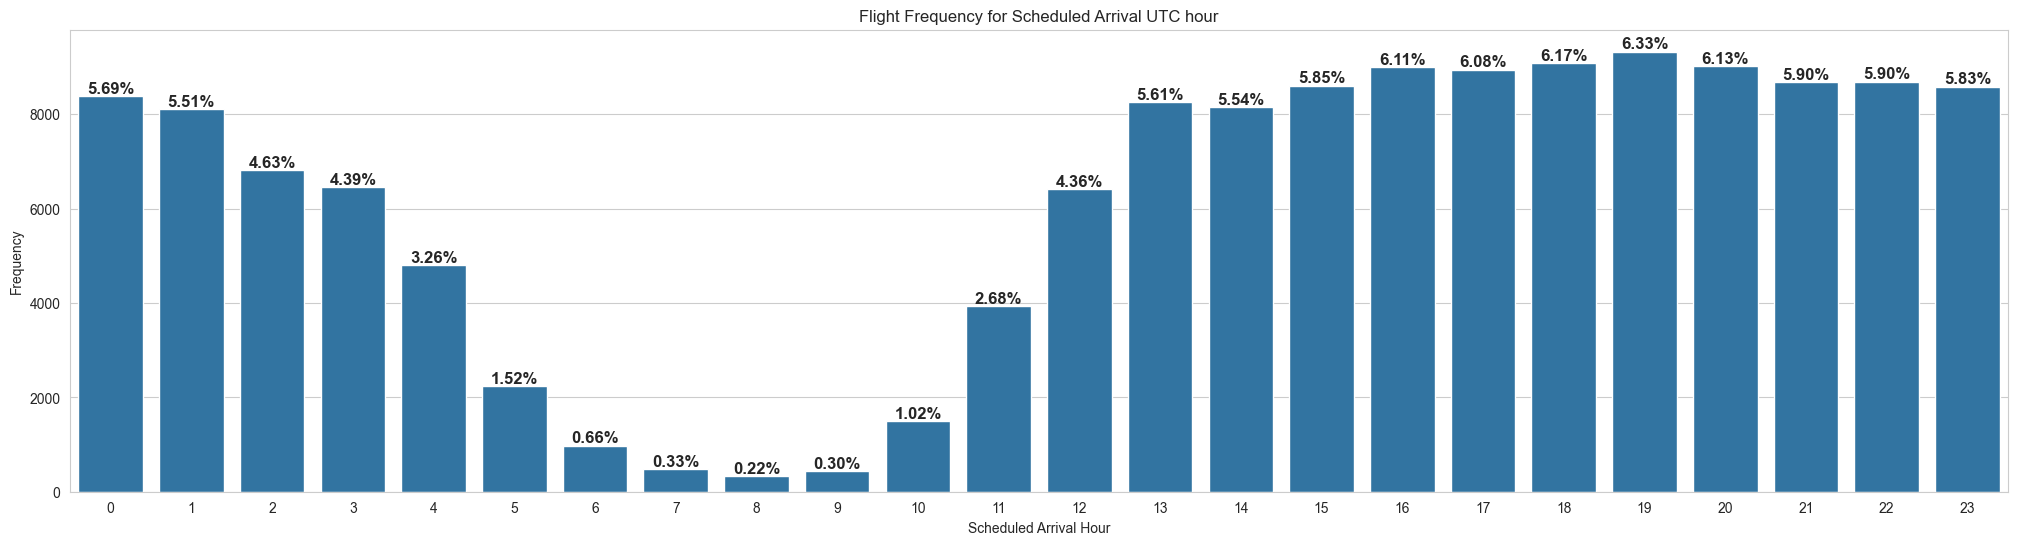

In [153]:
title = "Flight Frequency for Scheduled Arrival UTC hour"
x_label = 'Scheduled Arrival Hour'
y_label = 'Frequency'
total = len(data)
x = 'SCHD_ARR_UTC_HR'
hue=None
get_count_plot(x,data,title,x_label,y_label,hue,total,figsize=(25,6))

- Based on the above observation, the frequency of flights for each scheduled arrival hour, I observe that frequency of flights are less between 5a.m to 10a.m

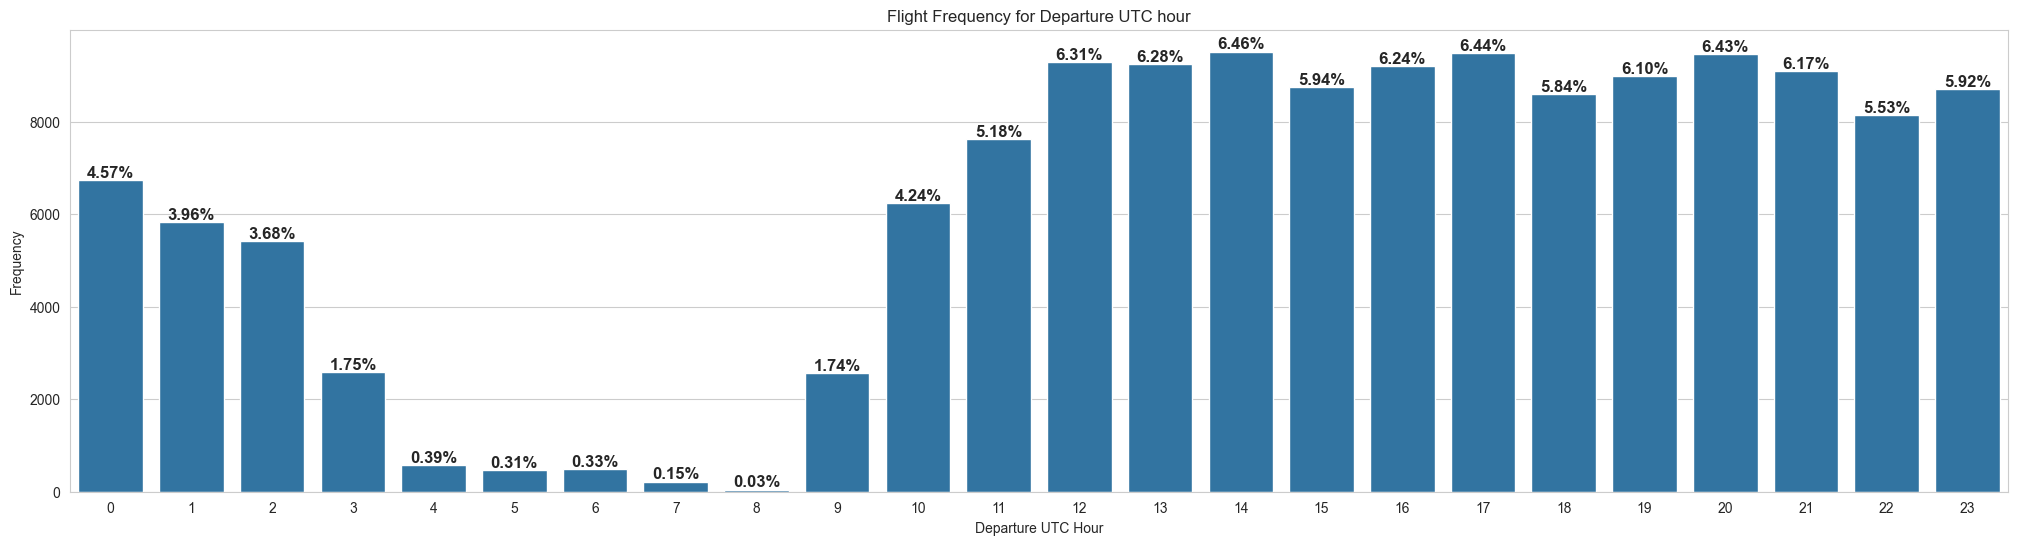

In [154]:
title = "Flight Frequency for Departure UTC hour"
x_label = 'Departure UTC Hour'
y_label = 'Frequency'
total = len(data)
x = 'DEPT_UTC_HR'
hue=None
get_count_plot(x,data,title,x_label,y_label,hue,total,figsize=(25,6))

- Based on the above observation, the frequency of flights for each scheduled arrival hour, I observe that frequency of flights are less between 3a.m to 9a.m

- The visualization of flight frequency on Scheduled Arrival and Departure time, both shows similar patterns and we also observe that the dip in lower flight frequency is consistent in both arrival annd departure time

In [155]:
# Retrieving the flight frequency based on SCHD_ARR_UTC_HR and ARR_DELAY_CLS
scd_hr_per_arr_cls_df = data.groupby(by=["SCHD_ARR_UTC_HR","ARR_DELAY_CLS"],as_index=False,observed=True)["SCHD_ARR_UTC_HR"].agg(SCHD_UTC_HR_CNT=("count"))
scd_hr_per_arr_cls_df['SCHD_UTC_HR_PERCENT'] = scd_hr_per_arr_cls_df.groupby("SCHD_ARR_UTC_HR",observed=True)['SCHD_UTC_HR_CNT'].transform(lambda x: 100*x/x.sum())

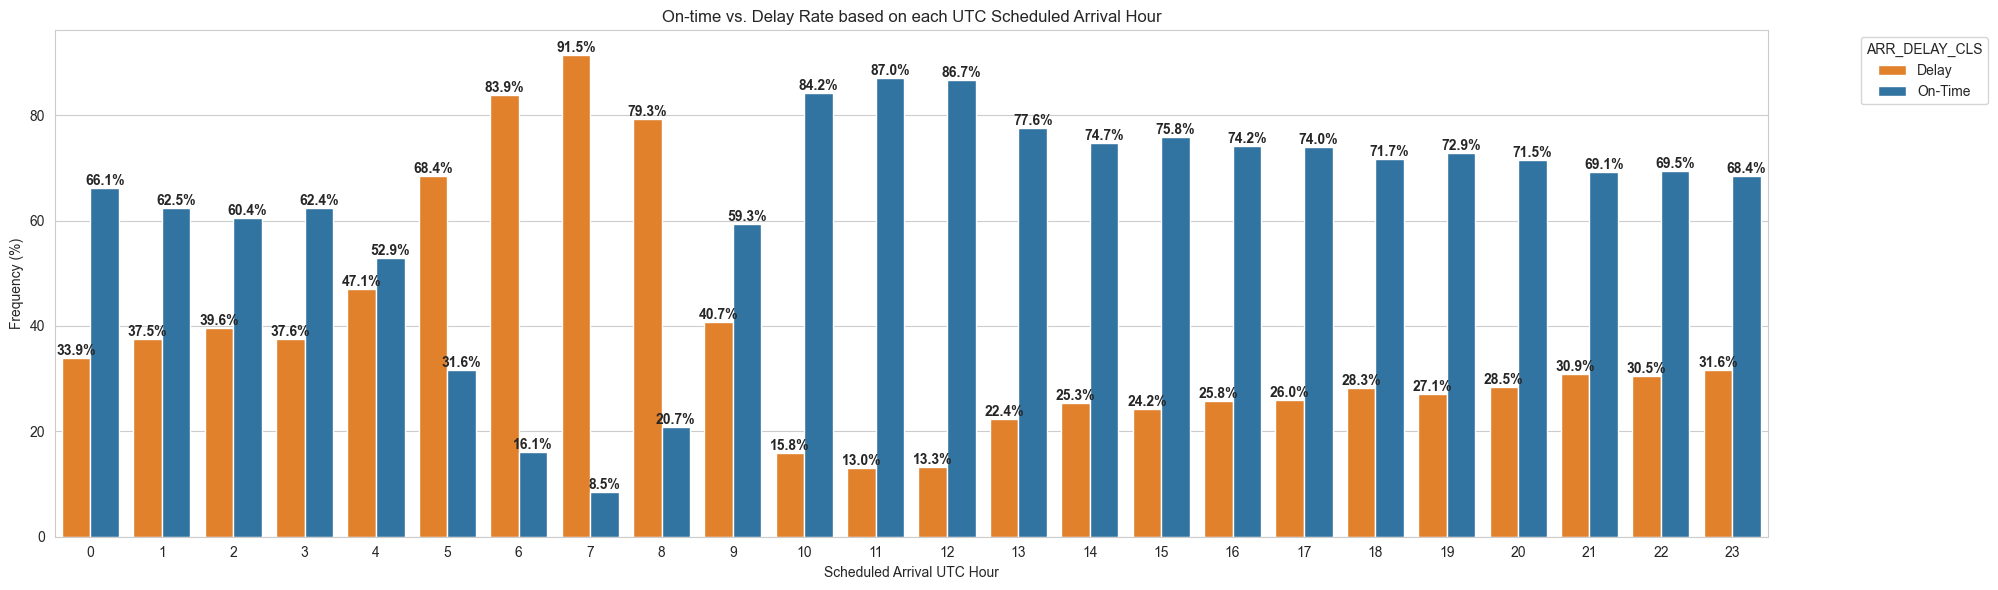

In [156]:
x='SCHD_ARR_UTC_HR'
y='SCHD_UTC_HR_PERCENT'
hue='ARR_DELAY_CLS'
order=scd_hr_per_arr_cls_df['SCHD_ARR_UTC_HR'].unique()
palette=color_mapping
figsize=(20, 6)
x_label = "Scheduled Arrival UTC Hour"
y_label = "Frequency (%)"
title = "On-time vs. Delay Rate based on each UTC Scheduled Arrival Hour"
get_bar_plot(x,y,hue,scd_hr_per_arr_cls_df,order,palette,title,x_label,y_label,figsize)

- Based on `SCHD_ARR_UTC_HR` and `ARR_DELAY_CLS`, chances of flights being delayed are higher from morning 12:00am to 9:00am
- And, based on the observation, we also see that `SCHD_ARR_UTC_HR` has association with Arrival Delay

- Hypothesis Testing - Chi-Square Test of Independence between SCHD_ARR_UTC_HR and ARR_DELAY_CLS
    - Null Hypothesis: SCHD_ARR_UTC_HR and ARR_DELAY_CLS are independent of each other.
    - Alternate Hypothesis: SCHD_ARR_UTC_HR and ARR_DELAY_CLS are dependent on each other


In [157]:
contingency_table = pd.crosstab(data['SCHD_ARR_UTC_HR'], data['ARR_DELAY_CLS'])

In [158]:
contingency_table

ARR_DELAY_CLS    Delay  On-Time
SCHD_ARR_UTC_HR                
0                 2841     5540
1                 3042     5064
2                 2697     4117
3                 2429     4029
4                 2263     2543
5                 1529      706
6                  818      157
7                  442       41
8                  260       68
9                  179      261
10                 237     1261
11                 512     3427
12                 850     5564
13                1847     6407
14                2063     6088
15                2085     6525
16                2319     6679
17                2327     6618
18                2569     6516
19                2526     6800
20                2572     6453
21                2681     6003
22                2654     6037
23                2716     5872

In [159]:
chi2, p, dof, expected = scipy.stats.chi2_contingency(contingency_table)

In [160]:
print(f"  chi2 = {chi2:.3f}, p = {p:.3f}, dof = {dof}")

  chi2 = 7797.176, p = 0.000, dof = 23


- As p-value (0.000) is less than 0.05, so SCHD_ARR_UTC_HR and ARR_DELAY_CLS are dependent on each other

In [161]:
# Retrieving the flight frequency based on DEPT_UTC_HR and ARR_DELAY_CLS
dep_hr_UTC_per_arr_cls_df = data.groupby(by=["DEPT_UTC_HR","ARR_DELAY_CLS"],as_index=False,observed=True)["DEPT_UTC_HR"].agg(DEP_UTC_HR_CNT=("count"))
dep_hr_UTC_per_arr_cls_df['DEP_UTC_HR_PERCENT'] = dep_hr_UTC_per_arr_cls_df.groupby("DEPT_UTC_HR",observed=True)['DEP_UTC_HR_CNT'].transform(lambda x: 100*x/x.sum())

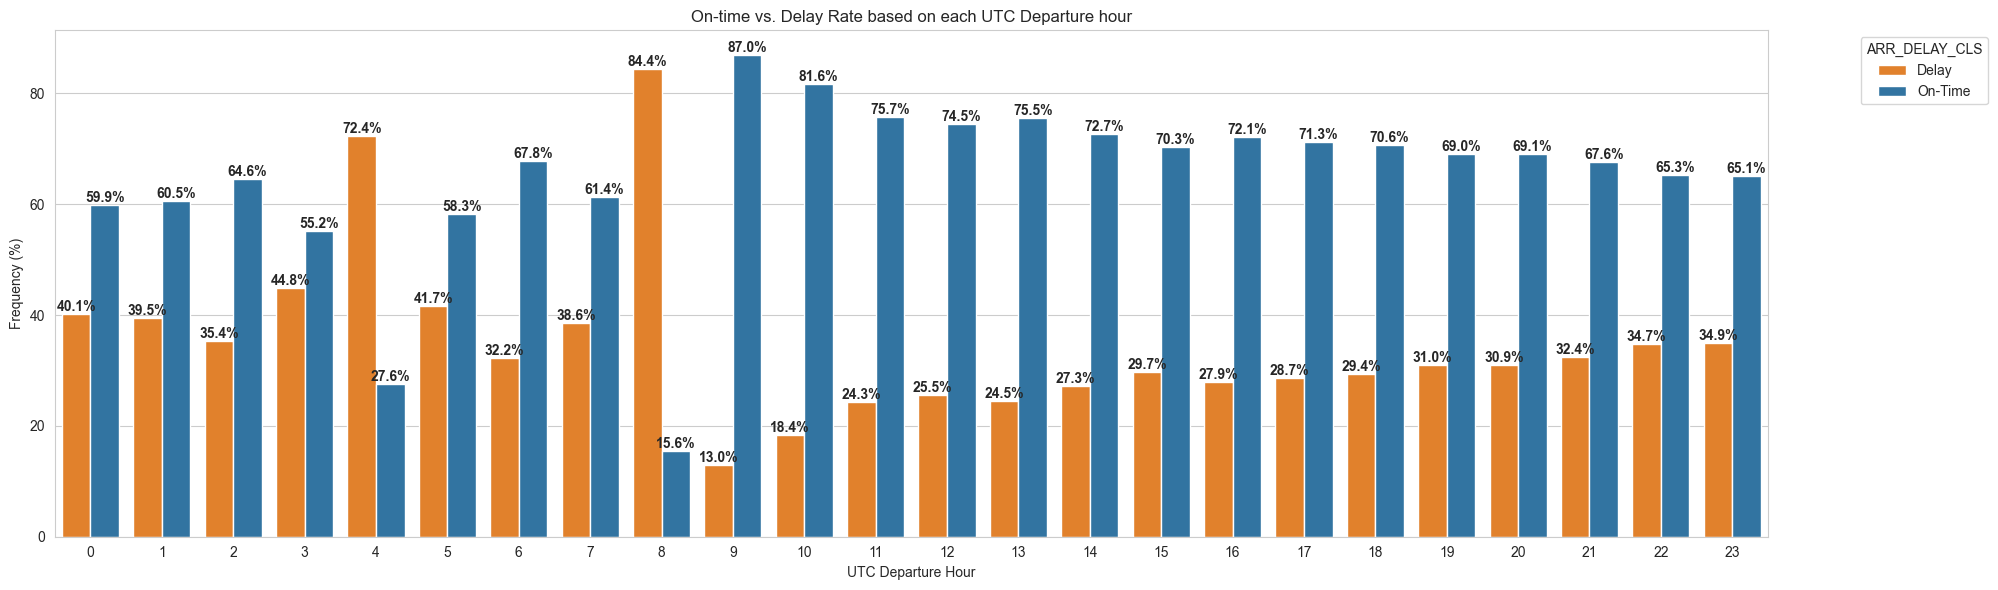

In [162]:
x='DEPT_UTC_HR'
y='DEP_UTC_HR_PERCENT'
hue='ARR_DELAY_CLS'
order=dep_hr_UTC_per_arr_cls_df['DEPT_UTC_HR']
palette=color_mapping
figsize=(20, 6)
title = "On-time vs. Delay Rate based on each UTC Departure hour"
x_label = "UTC Departure Hour"
y_label = "Frequency (%)"
get_bar_plot(x,y,hue,dep_hr_UTC_per_arr_cls_df,order,palette,title,x_label,y_label,figsize)

- Based on `DEP_UTC_HR` and `ARR_DELAY_CLS`, chances of flights being delayed are higher from morning 12:00am to 9:00am
- And, based on the observation, we can see that `DEP_UTC_HR` has association with Arrival Delay

- Hypothesis Testing - Chi-Square Test of Independence between `DEPT_UTC_HR` and `ARR_DELAY_CLS`
    - Null Hypothesis: DEPT_UTC_HR and ARR_DELAY_CLS are independent of each other.
    - Alternate Hypothesis: DEPT_UTC_HR and ARR_DELAY_CLS are dependent on each other

In [163]:
contingency_table = pd.crosstab(data['DEPT_UTC_HR'], data['ARR_DELAY_CLS'])

In [164]:
contingency_table

ARR_DELAY_CLS  Delay  On-Time
DEPT_UTC_HR                  
0               2703     4031
1               2300     3528
2               1918     3504
3               1157     1423
4                412      157
5                193      270
6                157      331
7                 83      132
8                 38        7
9                333     2234
10              1145     5093
11              1855     5770
12              2370     6915
13              2263     6981
14              2595     6918
15              2600     6142
16              2565     6629
17              2723     6765
18              2527     6072
19              2782     6203
20              2929     6537
21              2940     6147
22              2831     5317
23              3039     5670

In [165]:
chi2, p, dof, expected = scipy.stats.chi2_contingency(contingency_table)

In [166]:
print(f"  chi2 = {chi2:.3f}, p = {p:.3f}, dof = {dof}")

  chi2 = 2877.519, p = 0.000, dof = 23


- As p-value (0.000) is less than 0.05, so DEPT_UTC_HR and ARR_DELAY_CLS are dependent on each other

- Based on `DEP_UTC_HR` and `ARR_DELAY_CLS`, chances of flights being delayed are higher from morning 12:00am to 8:00am.

- The observations from the above visualizations based on Scheduled Arrival UTC hours and Departure UTC hours are consistent with each other from 10:00AM to 11:00pm.

- The early morning hour pattern from 12:00 am to 9:00 for both of the visualizations are quiet random.

- Based on the On-time vs Delay plots for Scheduled Arrival UTC and Departure Hour I can infer that Flight delay has association with Actual Scheduled Arrival hour and Departure Hour

<Figure size 3000x2000 with 0 Axes>

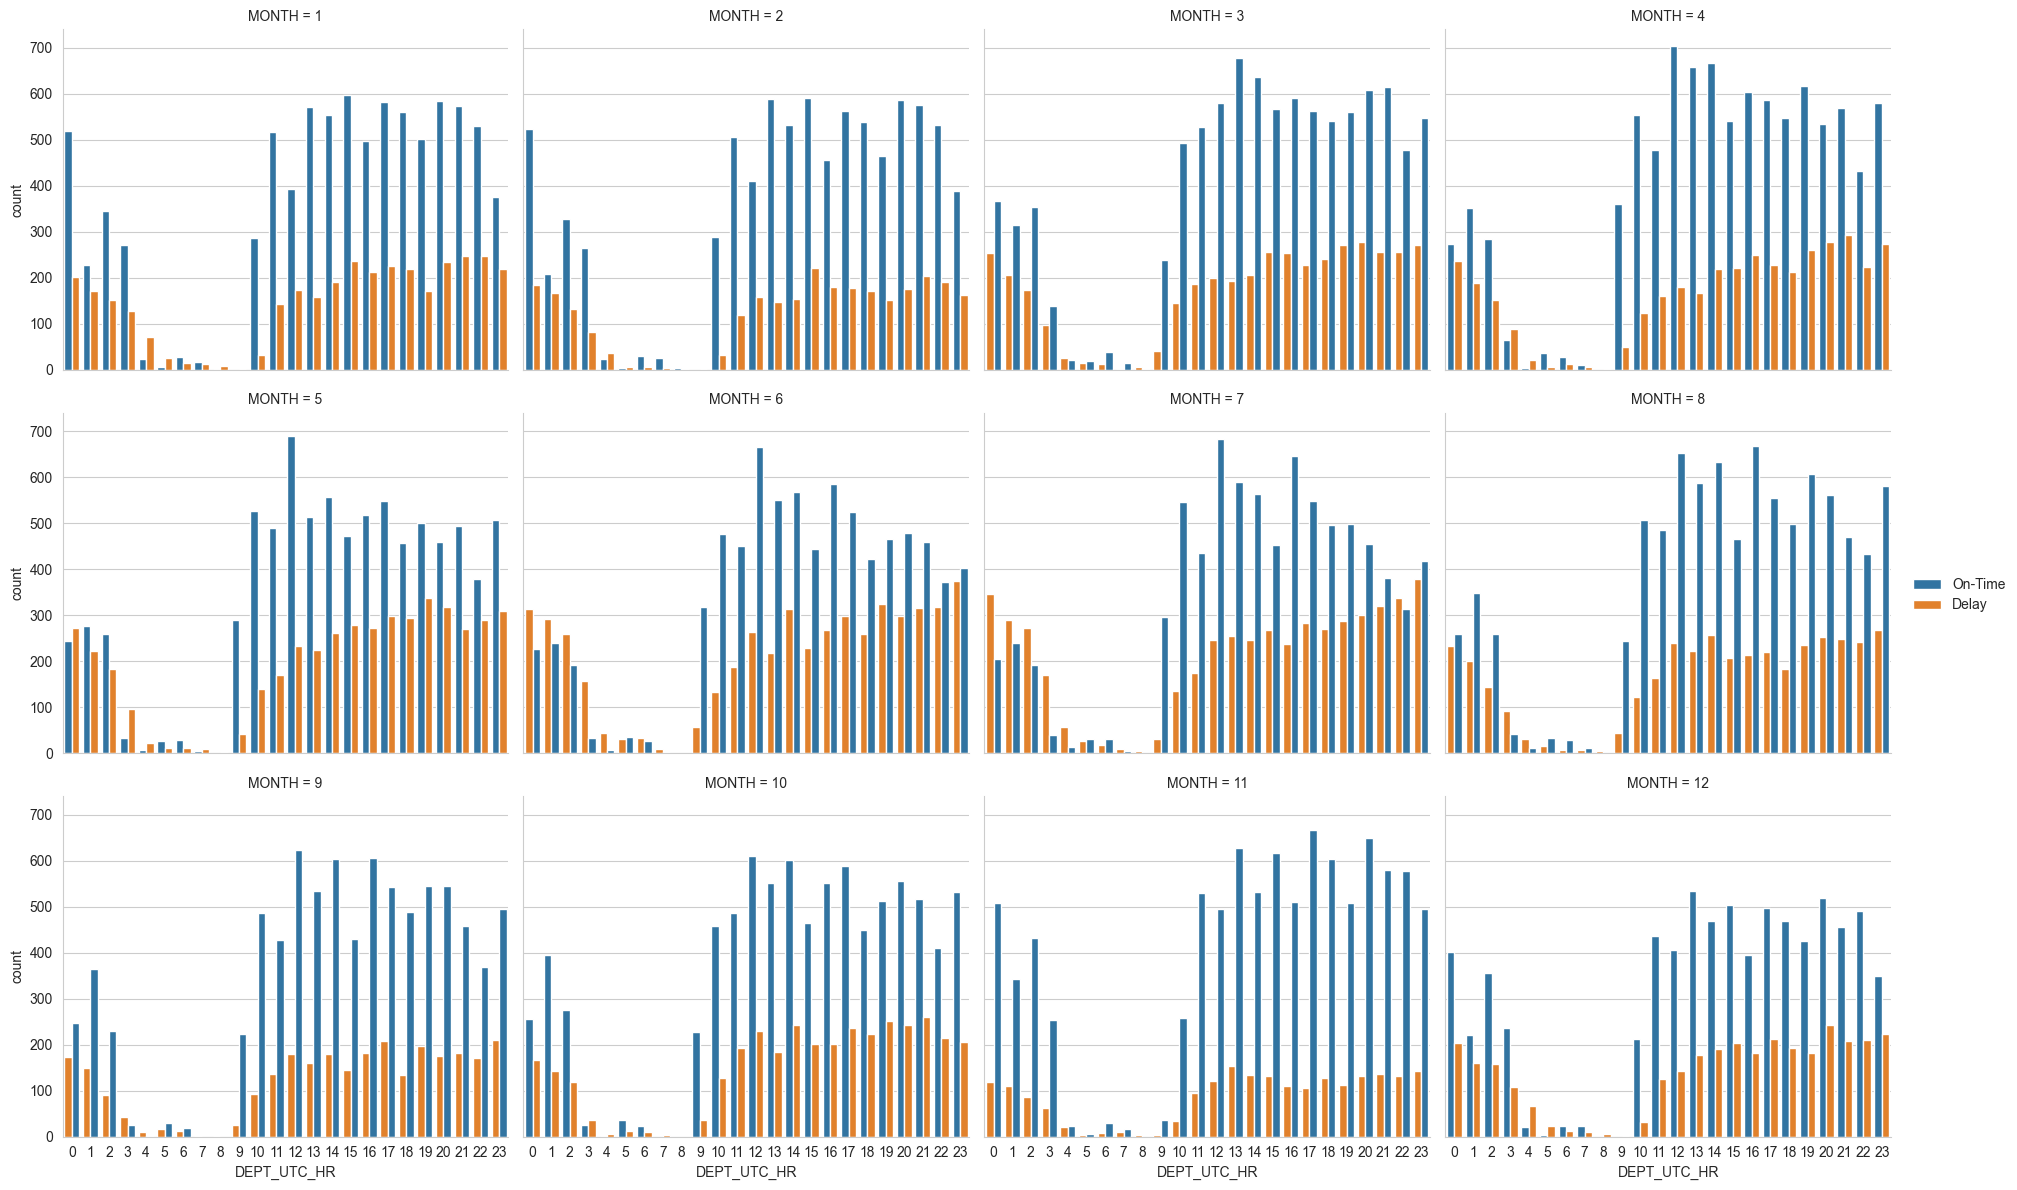

In [167]:
# Generating visualization for Departure Delay, Month and DEPT_UTC_HR
plt.figure(figsize=(30, 20))
hour_order = sorted(data["DEPT_UTC_HR"].unique())
g = sns.FacetGrid(
    data,
    col="MONTH",
    col_wrap=4,
    height=4,
    aspect=1.2
)
g.map_dataframe(
    sns.countplot,
    x="DEPT_UTC_HR",
    hue="ARR_DELAY_CLS",
    palette=color_mapping,
    order = hour_order
)
g.add_legend()
plt.show()

- Based on above visualization, the chance of flight delays are higher in the months 3, 4, 5, 6 and 7 with respect to month and departure UTC hour

<Figure size 3000x2000 with 0 Axes>

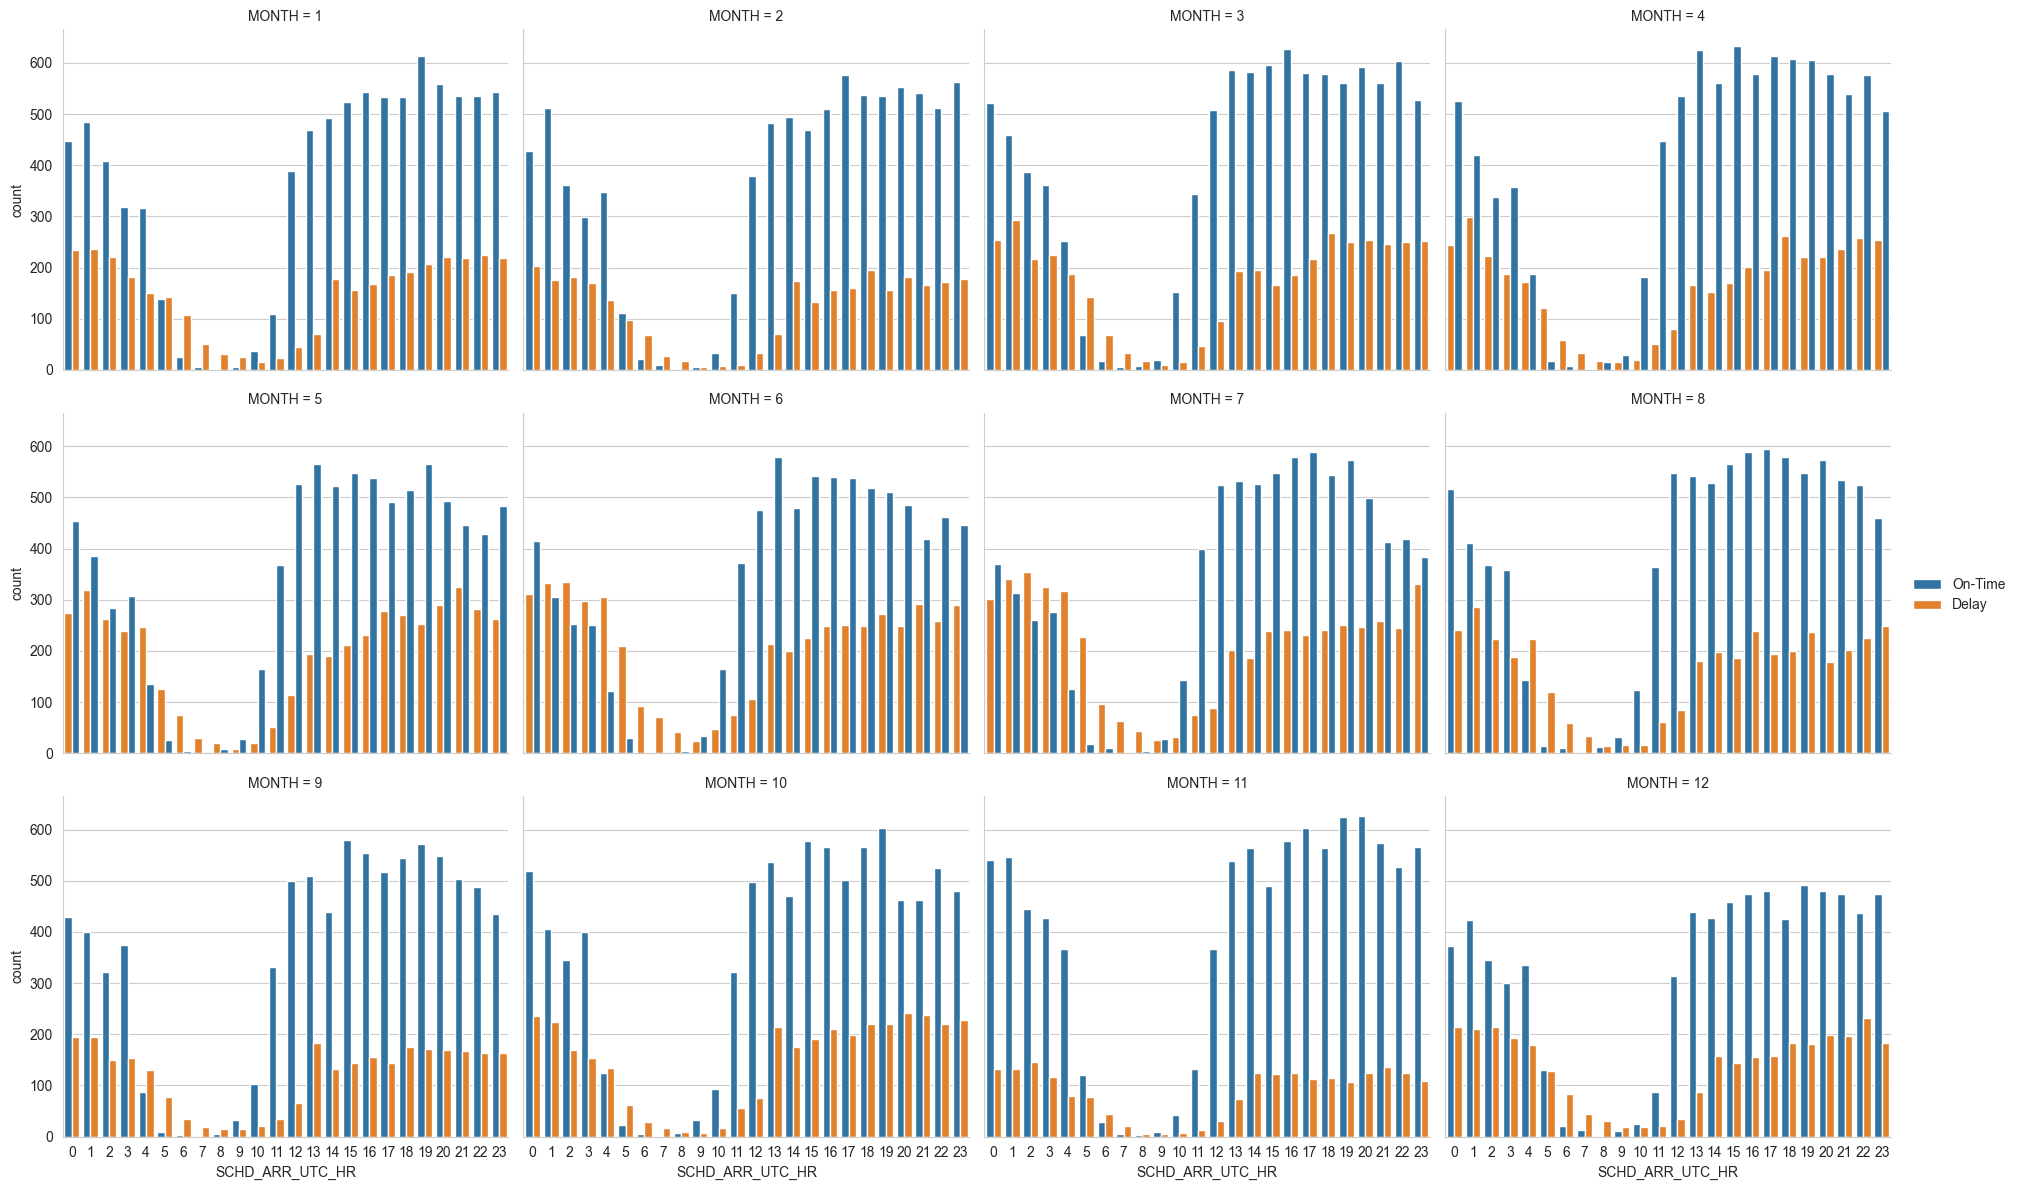

In [168]:
# Generating visualization for Scheduled Arrival Delay, Month and SCHD_ARR_UTC_HR
plt.figure(figsize=(30, 20))
hour_order = sorted(data["SCHD_ARR_UTC_HR"].unique())
g = sns.FacetGrid(
    data,
    col="MONTH",
    col_wrap=4,
    height=4,
    aspect=1.2
)
g.map_dataframe(
    sns.countplot,
    x="SCHD_ARR_UTC_HR",
    hue="ARR_DELAY_CLS",
    palette=color_mapping,
    order = hour_order
)
g.add_legend()
plt.show()

- Based on above visualization, the chance of flight delays are higher in the months 3, 4, 5, 6 and 7 with respect to month and scheduled arrival UTC hour

- Based on both the visualization for departure UTC hour and scheduled arrival UTC hour, I observed similar pattern for the months which are high likely for flight delays


## `YEAR` Analysis

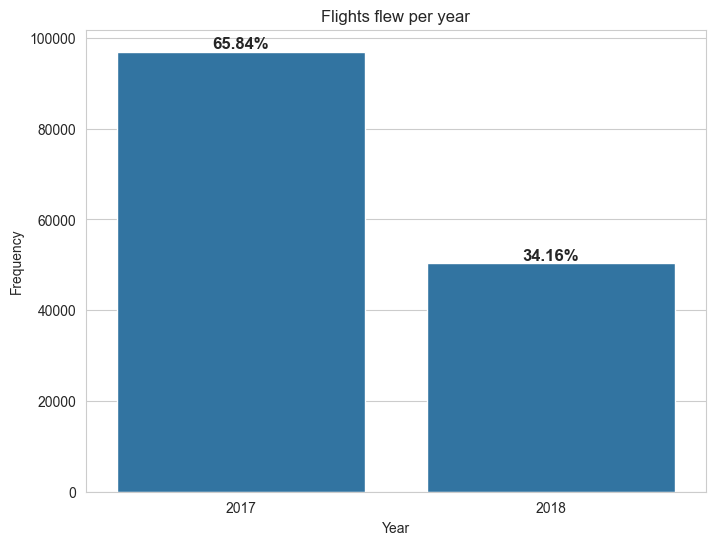

In [169]:
title = "Flights flew per year"
x = "YEAR"
x_label = 'Year'
y_label = 'Frequency'
total = len(data)
get_count_plot(x,data,title,x_label,y_label,None,total,figsize=(8,6))

In [170]:
year_and_month_df = data.groupby(by=['YEAR','MONTH'],as_index=False,observed=True)[['YEAR','MONTH']].first()

In [171]:
year_and_month_df

YEAR  MONTH
0   2017      5
1   2017      6
2   2017      7
3   2017      8
4   2017      9
5   2017     10
6   2017     11
7   2017     12
8   2018      1
9   2018      2
10  2018      3
11  2018      4

- Based on the above analysis we can understand that the data doesn't have complete year information for both 2017 and 2018.So, It's better to go for month or quarter wise analysis

## `QUARTER` Analysis

In [172]:
year_and_quarter_df = data.groupby(by=['YEAR','QUARTER'],as_index=False)[['YEAR','QUARTER']].first()

In [173]:
year_and_quarter_df

YEAR  QUARTER
0  2017        2
1  2017        3
2  2017        4
3  2018        1
4  2018        2

- Based on the above observations we can see that 2017 and 2018 both have Quarter 2 and Quarter 1 is missing in 2017. So, I am checking using `MONTH` and `YEAR`

In [174]:
year_and_month_df

YEAR  MONTH
0   2017      5
1   2017      6
2   2017      7
3   2017      8
4   2017      9
5   2017     10
6   2017     11
7   2017     12
8   2018      1
9   2018      2
10  2018      3
11  2018      4

- From the above observation we can see that 2017 doesn't have first 4 months and 2018 doesn't have last 8 months. So, it won't be right approach to do the analysis based on `QUARTER`. So, I am moving forward with analysis based on months.

## `MONTH` Analysis

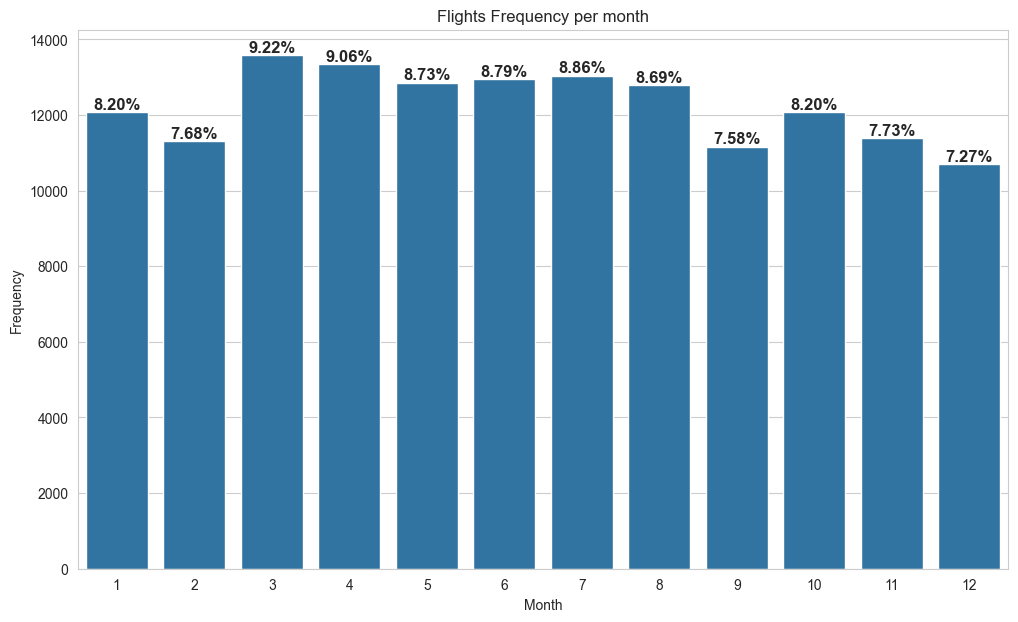

In [175]:
title = "Flights Frequency per month"
x = "MONTH"
x_label = 'Month'
y_label = 'Frequency'
total = len(data)
hue=None
get_count_plot(x,data,title,x_label,y_label,hue,total,figsize=(12,7))

- Based on the above graph we can understand that during `Month 3 to Month 8` more number of flights flying across the United States

In [176]:
# Extracting flights frequency based on aggregation by features Month and ARR_DELAY_CLS
cnt_arr_clss_per_month_df = data.groupby(by=['MONTH','ARR_DELAY_CLS'],as_index=False,observed=True)['MONTH'].agg(FLIGHT_COUNT=("count"))
cnt_arr_clss_per_month_df['FLIGHT_PERCENT'] = cnt_arr_clss_per_month_df.groupby(['MONTH'])['FLIGHT_COUNT'].transform(lambda x: 100*x/x.sum())

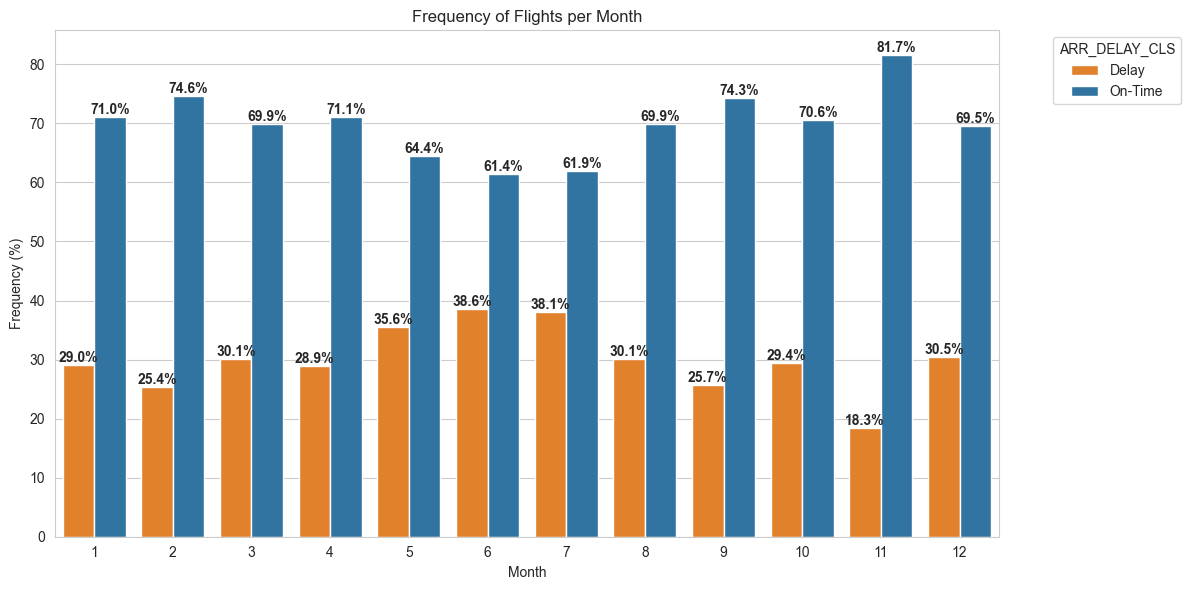

In [177]:
x='MONTH'
y='FLIGHT_PERCENT'
hue='ARR_DELAY_CLS'
order=cnt_arr_clss_per_month_df['MONTH'].unique()
palette=color_mapping
figsize=(12, 6)
x_label = "Month"
y_label = "Frequency (%)"
title = "Frequency of Flights per Month"
get_bar_plot(x,y,hue,cnt_arr_clss_per_month_df,order,palette,title,x_label,y_label,figsize)

- As, we observed in the Flights Frequency per month bargraphs that Month 3 to Month 8, more flights fly so based on the immediate above graph we can see that:

    - Month 5, Month 6 and Month 7 have more number of Delayed flights compared to other months (which are between Month 3 to Month 8)

        - So, we can understand from the visualization that out of the months 3 to 8 most of the delay happens in Month 5, Month 6 and Month 7
        
    - Month 11  has least number of Delayed flights compared to other months

- Out of curiosity I researched and understood that during month 5,6, and 7 it is Summer time so due to the bad weather condition the flights may get delayed

- Hypothesis Testing - Chi-Square Test of Independence between `MONTH` and `ARR_DELAY_CLS`
    - Null Hypothesis: MONTH and ARR_DELAY_CLS are independent of each other.
    - Alternate Hypothesis: MONTH and ARR_DELAY_CLS are dependent on each other

In [178]:
contingency_table = pd.crosstab(data['MONTH'], data['ARR_DELAY_CLS'])

In [179]:
contingency_table

ARR_DELAY_CLS  Delay  On-Time
MONTH                        
1               3500     8568
2               2873     8433
3               4080     9496
4               3851     9489
5               4572     8285
6               4995     7948
7               4963     8077
8               3855     8937
9               2874     8288
10              3543     8525
11              2087     9291
12              3265     7439

In [180]:
chi2, p, dof, expected = scipy.stats.chi2_contingency(contingency_table)

In [181]:
print(f"  chi2 = {chi2:.3f}, p = {p:.3f}, dof = {dof}")

  chi2 = 2001.010, p = 0.000, dof = 11


- As p-value (0.000) is less than 0.05, so MONTH and ARR_DELAY_CLS are dependent on each other

## UNIQUE_CARRIER Analysis

In [182]:
delay_per_carrier_df = data.groupby(by=["UNIQUE_CARRIER","ARR_DELAY_CLS"],observed=True,as_index=False)["UNIQUE_CARRIER"].first()

In [183]:
delay_per_carrier_df

ARR_DELAY_CLS UNIQUE_CARRIER
0          Delay             9E
1        On-Time             9E
2          Delay             AA
3        On-Time             AA
4          Delay             AS
5        On-Time             AS
6          Delay             B6
7        On-Time             B6
8          Delay             DL
9        On-Time             DL
10         Delay             EV
11       On-Time             EV
12         Delay             F9
13       On-Time             F9
14         Delay             G4
15       On-Time             G4
16         Delay             MQ
17       On-Time             MQ
18         Delay             NK
19       On-Time             NK
20         Delay             OH
21       On-Time             OH
22         Delay             OO
23       On-Time             OO
24         Delay             UA
25       On-Time             UA
26         Delay             WN
27       On-Time             WN
28         Delay             YV
29       On-Time             YV
30         Delay             YX
31       On-Time             YX

In [184]:
# Extracting frequenncy of Unique_Carrier based onn ARR_DELAY_CLS
carr_cnt_per_arr_cls_df = data.groupby(by=["UNIQUE_CARRIER","ARR_DELAY_CLS"],as_index=False,observed=True)["UNIQUE_CARRIER"].agg(CARRIER_COUNT=("count"))
carr_cnt_per_arr_cls_df['CARRIER_PERCENT'] = carr_cnt_per_arr_cls_df.groupby("UNIQUE_CARRIER",observed=True)['CARRIER_COUNT'].transform(lambda x: 100*x/x.sum())

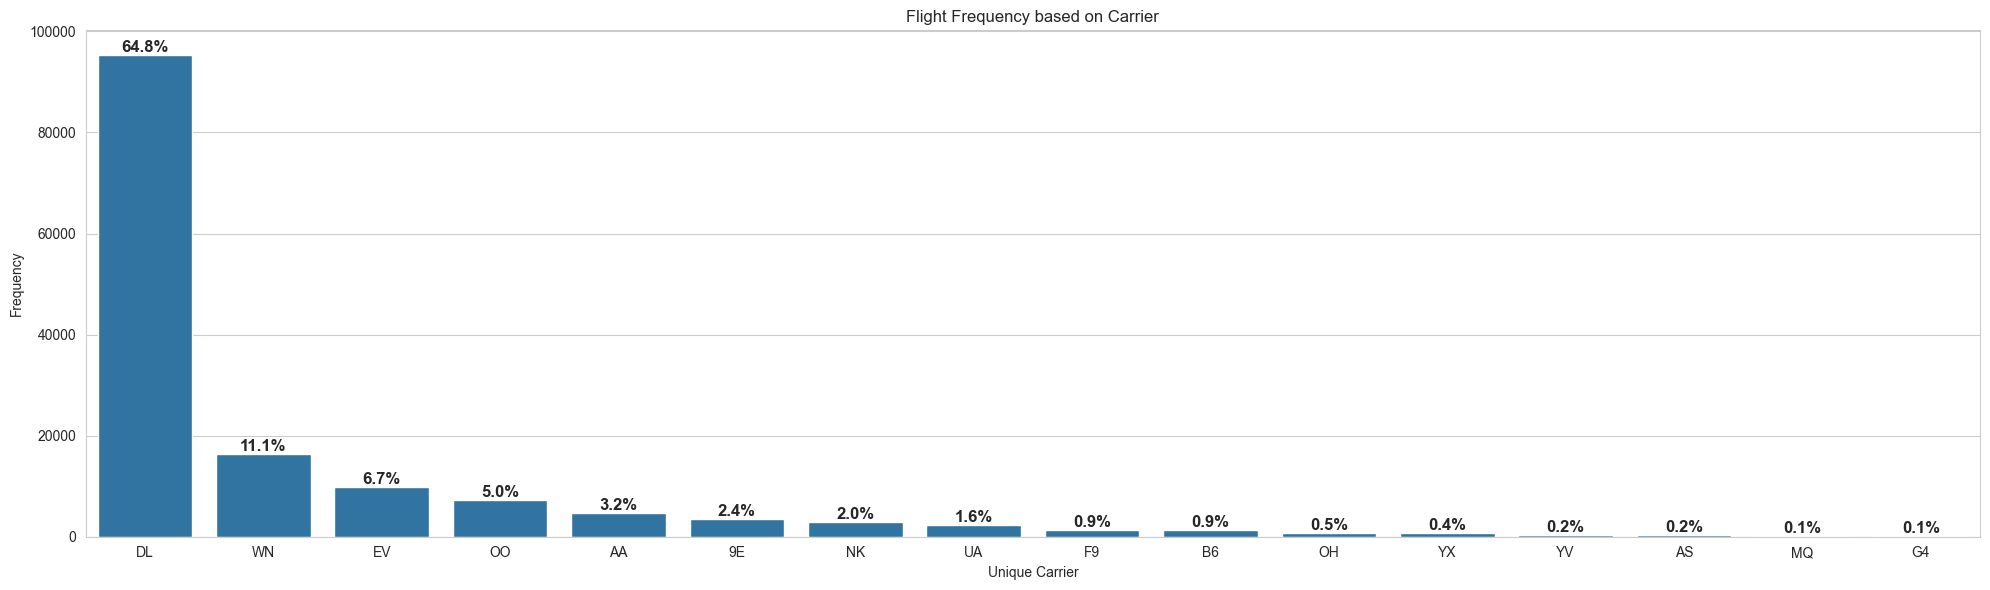

In [185]:
plt.figure(figsize=(20, 6))
ax=sns.countplot(x ='UNIQUE_CARRIER' ,data = data,order = data['UNIQUE_CARRIER'].value_counts().index)
total = len(data)
for p in ax.patches:
    percentage = 100 * p.get_height() / total
    if percentage > 0:
        percentage_text = f'{percentage:.1f}%'
        ax.annotate(percentage_text,
                   (p.get_x() + p.get_width() / 2, p.get_height()),
                   ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.title("Flight Frequency based on Carrier")
plt.xlabel("Unique Carrier")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

- We can see that 64.8% of flights belong to DL carrier followed by WN, EV and OO

In [186]:
order_list_carrier = carr_cnt_per_arr_cls_df.groupby(['UNIQUE_CARRIER'],observed=True)['CARRIER_COUNT'].sum().sort_values(ascending=False).keys()

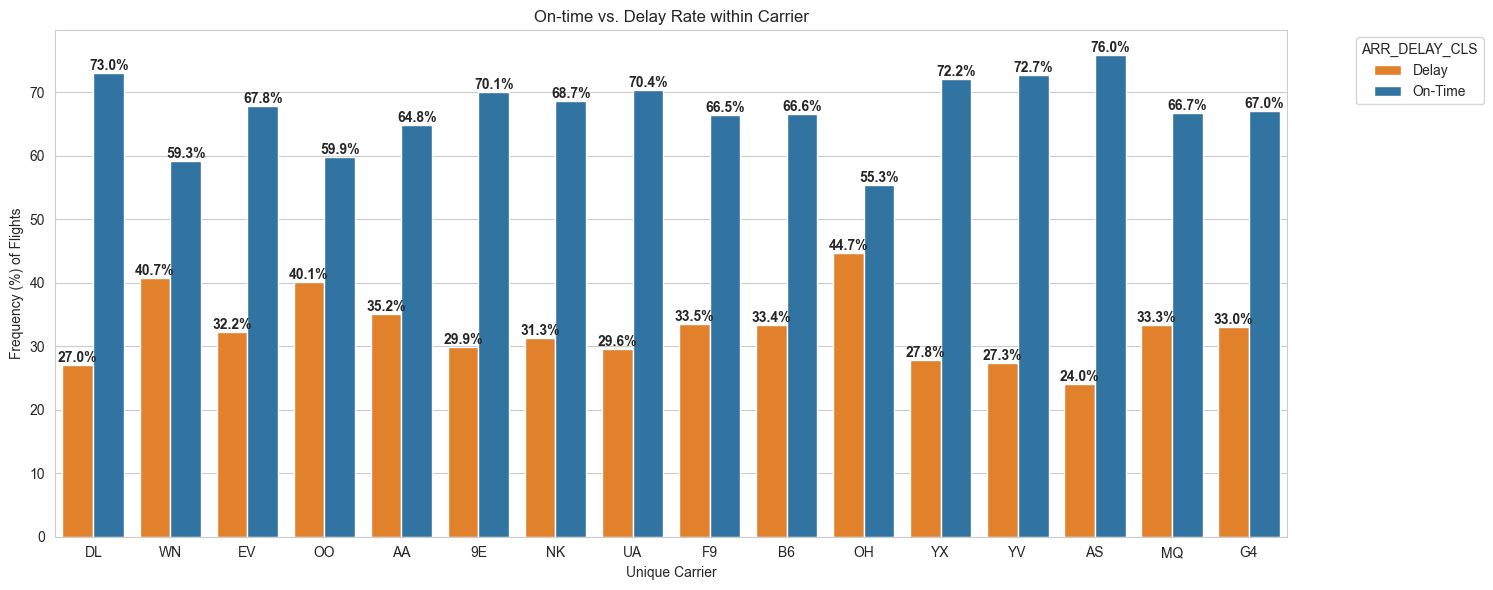

In [187]:
x='UNIQUE_CARRIER'
y='CARRIER_PERCENT'
hue='ARR_DELAY_CLS'
order = order_list_carrier
palette=color_mapping
figsize=(15, 6)
title = "On-time vs. Delay Rate within Carrier"
x_label = "Unique Carrier"
y_label = "Frequency (%) of Flights"
get_bar_plot(x,y,hue,carr_cnt_per_arr_cls_df,order,palette,title,x_label,y_label,figsize)

- Carrier `AS` has `0.2%` of flights where `76%` of the time we see that flight is `On-Time` which is highest compared to all with lowest `DELAY` of `24%`
- `DL` occupies `64.8%` of flights which flew where `73%` of the time the flight is `On-Time` and `27%` of the time it is `Delayed`
- Overall `OH` has the highest `DELAY` rate of `44.7%` followed by `WN` and `OO`.
- Carrier `WN` is the 2nd highest carrier `(11.0%)` having one of the highest `DELAY` rate of `40.8%`
- Carrier `OO` is the 4th highest carrier `(5.0%)` having `DELAY` rate of `40.2%` following `WN`
- So, based on this we can say that if the flight `OH`, `WN` or `OO` there is high chance of `Delay`
- We can understand that choice of carrier can be associated with `Delay`


- Hypothesis Testing - Chi-Square Test of Independence between `UNIQUE_CARRIER` and `ARR_DELAY_CLS`
    - Null Hypothesis: UNIQUE_CARRIER and ARR_DELAY_CLS are independent of each other.
    - Alternate Hypothesis: UNIQUE_CARRIER and ARR_DELAY_CLS are dependent on each other

In [188]:
contingency_table = pd.crosstab(data['UNIQUE_CARRIER'], data['ARR_DELAY_CLS'])

In [189]:
contingency_table

ARR_DELAY_CLS   Delay  On-Time
UNIQUE_CARRIER                
9E               1042     2442
AA               1633     3012
AS                 63      199
B6                428      853
DL              25775    69648
EV               3195     6727
F9                454      900
G4                 30       61
MQ                 35       70
NK                915     2009
OH                330      409
OO               2942     4393
UA                704     1676
WN               6633     9647
YV                 95      253
YX                184      477

In [190]:
chi2, p, dof, expected = scipy.stats.chi2_contingency(contingency_table)

In [191]:
print(f"  chi2 = {chi2:.3f}, p = {p:.3f}, dof = {dof}")

  chi2 = 1831.112, p = 0.000, dof = 15


- As p-value (0.000) is less than 0.05, so UNIQUE_CARRIER and ARR_DELAY_CLS are dependent on each other

<Figure size 3000x2000 with 0 Axes>

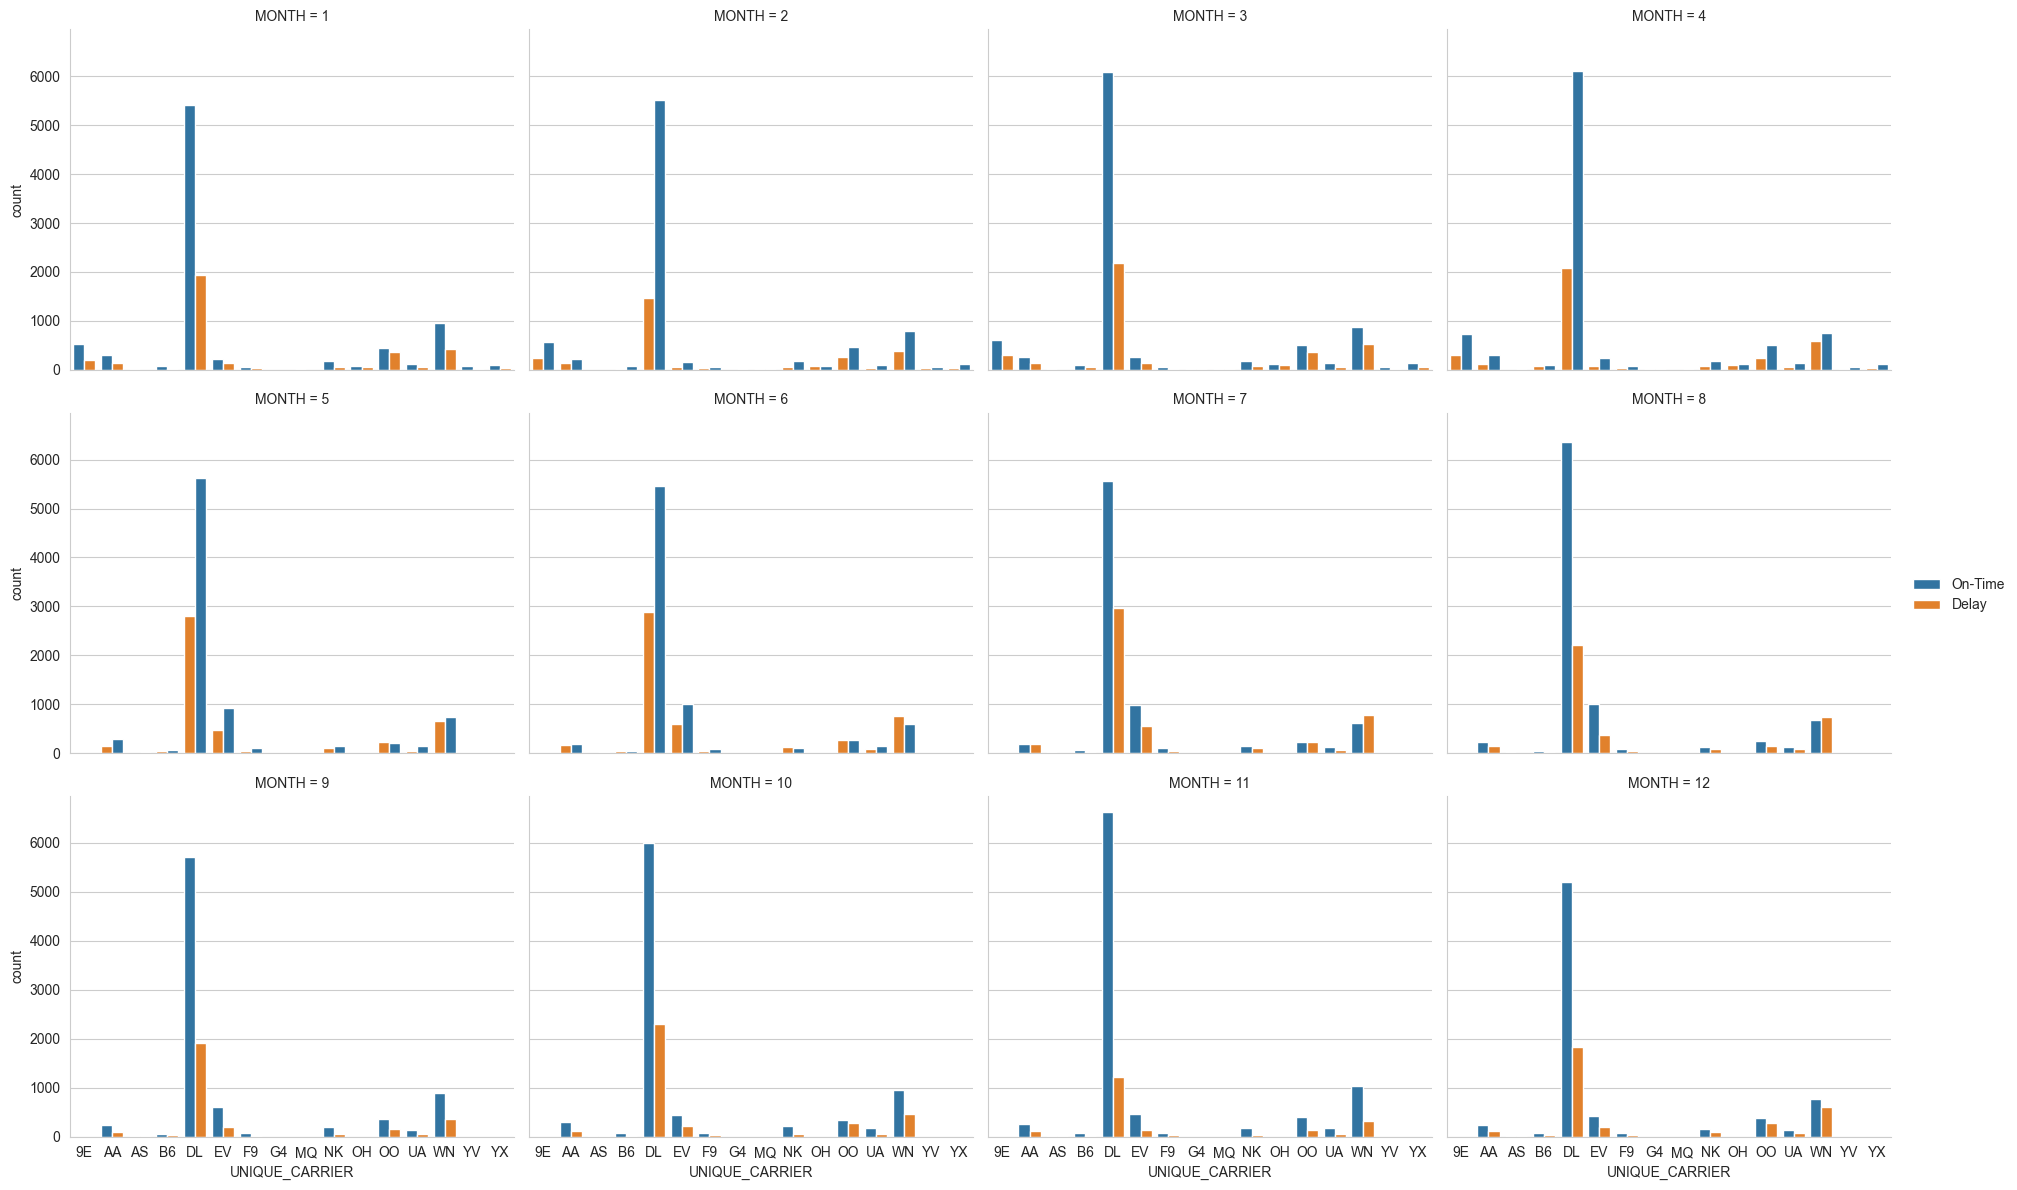

In [192]:
# Generating visualization for Arrival Delay, Month and UNIQUE_CARRIER
plt.figure(figsize=(30, 20))
hour_order = sorted(data["UNIQUE_CARRIER"].unique())
g = sns.FacetGrid(
    data,
    col="MONTH",
    col_wrap=4,
    height=4,
    aspect=1.2
)
g.map_dataframe(
    sns.countplot,
    x="UNIQUE_CARRIER",
    hue="ARR_DELAY_CLS",
    palette=color_mapping,
    order = hour_order
)
g.add_legend()
plt.show()

- Based on this we can see that Flight DL is dominating other carriers every month.

## DAY_OF_MONTH Analysis

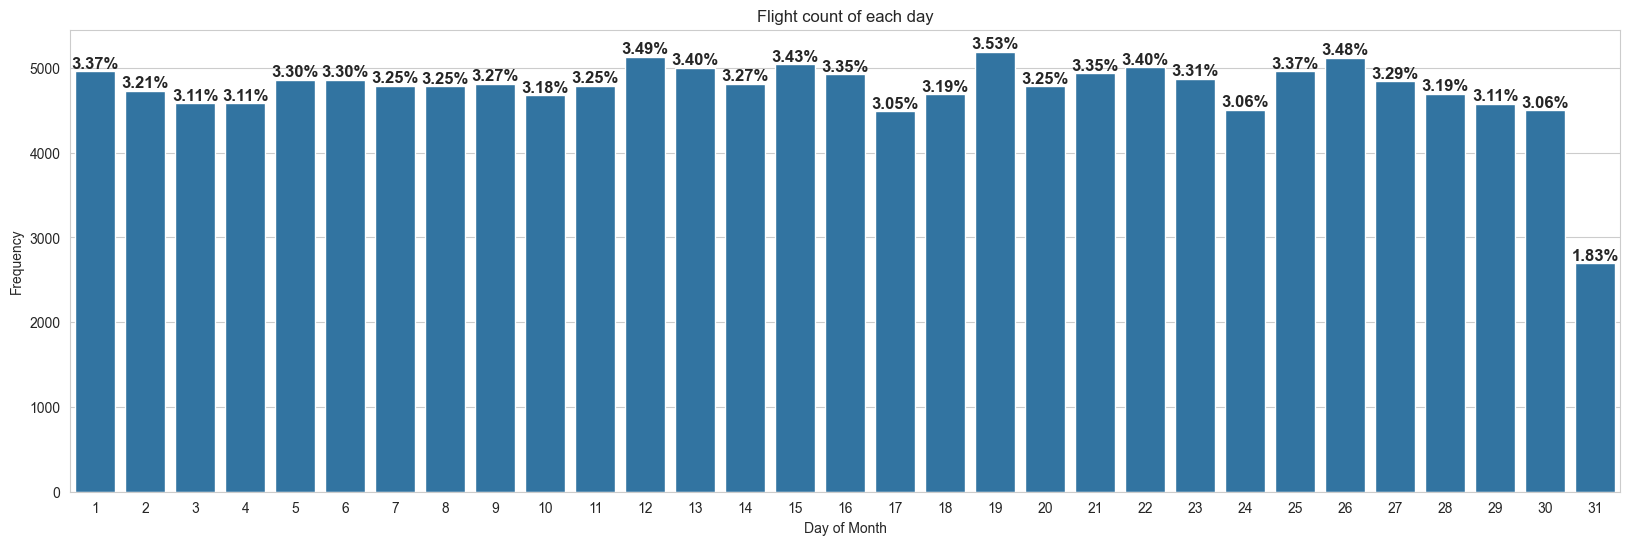

In [193]:
title = "Flight count of each day"
x = "DAY_OF_MONTH"
x_label = 'Day of Month'
y_label = 'Frequency'
total = len(data)
hue=None
get_count_plot(x,data,title,x_label,y_label,hue,total,figsize=(20,6))

- Almost all the days of each month the flight frequency is same
- Less flights flew on 31st due to few months having 31 days

In [194]:
# Extracting frequenncy of DAY_OF_MONTH based onn ARR_DELAY_CLS
dom_cnt_per_arr_cls_df = data.groupby(by=["DAY_OF_MONTH","ARR_DELAY_CLS"],as_index=False)["DAY_OF_MONTH"].agg(DOM_COUNT=("count"))
dom_cnt_per_arr_cls_df['DOM_PERCENT'] = dom_cnt_per_arr_cls_df.groupby("DAY_OF_MONTH")['DOM_COUNT'].transform(lambda x: 100*x/x.sum())

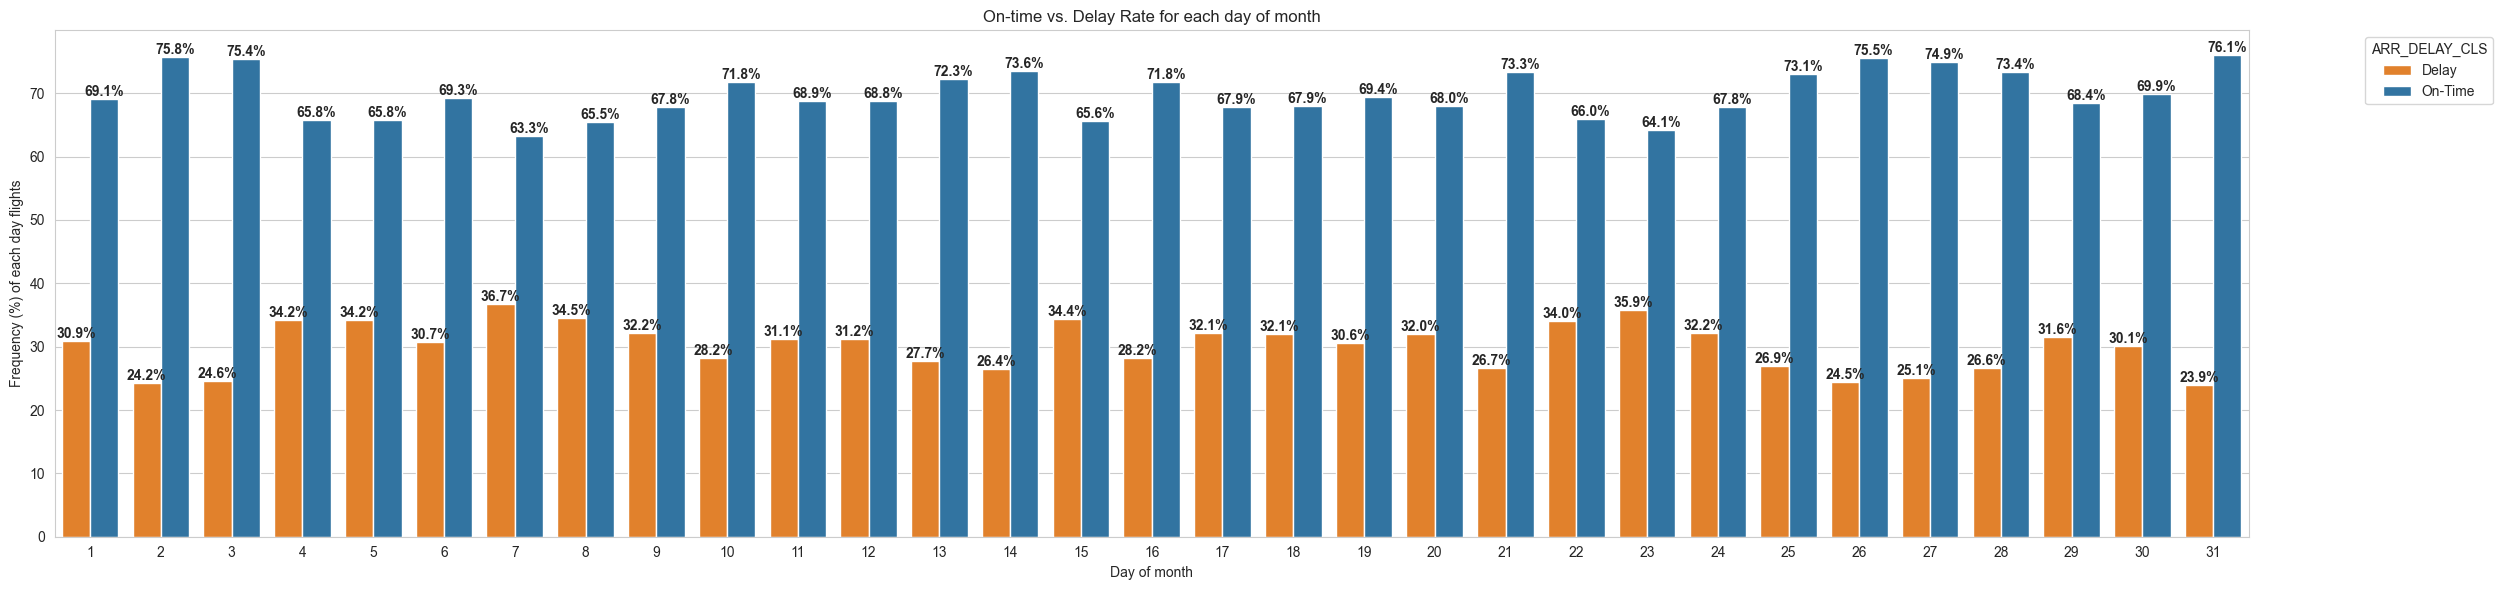

In [195]:
x='DAY_OF_MONTH'
y='DOM_PERCENT'
hue='ARR_DELAY_CLS'
order = dom_cnt_per_arr_cls_df['DAY_OF_MONTH'].unique()
palette=color_mapping
figsize=(25, 6)
title = "On-time vs. Delay Rate for each day of month"
x_label = "Day of month"
y_label = "Frequency (%) of each day flights"
get_bar_plot(x,y,hue,dom_cnt_per_arr_cls_df,order,palette,title,x_label,y_label,figsize)

- Days 2 (24.2%), 3 (24.6%), 26 (24.5%), and 31 (23.9%) show the lowest delay rate for each day of month
- Days 7 (36.7%), 23 (35.9%), and 15 (34.4%) show higher delay
- As we can see change of delay in almost all the day of month we can say that day of month influences flight delay

- Hypothesis Testing - Chi-Square Test of Independence between `DAY_OF_MONTH` and `ARR_DELAY_CLS`
    - Null Hypothesis: DAY_OF_MONTH and ARR_DELAY_CLS are independent of each other.
    - Alternate Hypothesis: DAY_OF_MONTH and ARR_DELAY_CLS are dependent on each other

In [196]:
contingency_table = pd.crosstab(data['DAY_OF_MONTH'], data['ARR_DELAY_CLS'])

In [197]:
contingency_table

ARR_DELAY_CLS  Delay  On-Time
DAY_OF_MONTH                 
1               1536     3427
2               1145     3587
3               1129     3454
4               1565     3017
5               1661     3199
6               1491     3369
7               1756     3033
8               1649     3137
9               1551     3264
10              1317     3359
11              1492     3300
12              1604     3530
13              1384     3619
14              1273     3541
15              1735     3309
16              1389     3536
17              1443     3049
18              1505     3189
19              1588     3603
20              1532     3251
21              1318     3618
22              1702     3307
23              1747     3126
24              1452     3055
25              1336     3627
26              1252     3868
27              1214     3629
28              1247     3448
29              1447     3132
30              1355     3143
31               643     2050

In [198]:
chi2, p, dof, expected = scipy.stats.chi2_contingency(contingency_table)

In [199]:
print(f"  chi2 = {chi2:.3f}, p = {p:.3f}, dof = {dof}")

  chi2 = 898.426, p = 0.000, dof = 30


- As p-value (0.000) is less than 0.05, so DAY_OF_MONTH and ARR_DELAY_CLS are dependent on each other

## DAY_OF_WEEK Analysis

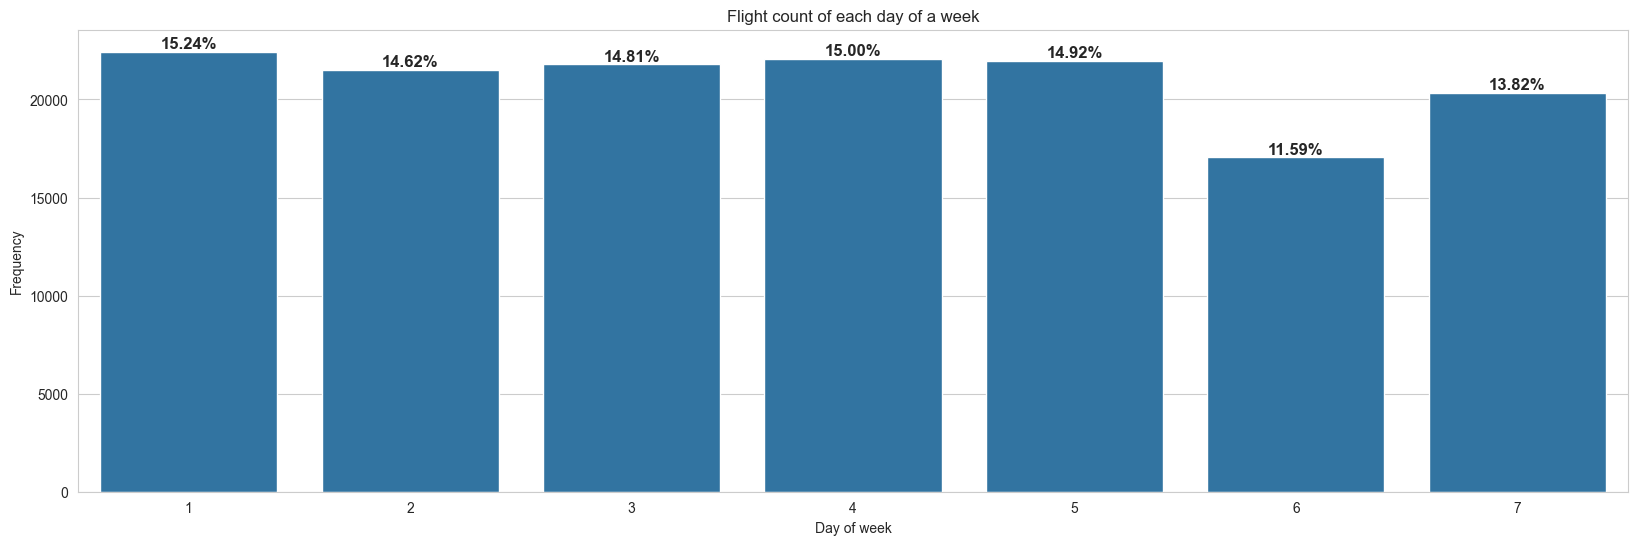

In [200]:
title = "Flight count of each day of a week"
x = "DAY_OF_WEEK"
x_label = 'Day of week'
y_label = 'Frequency'
total = len(data)
hue=None
get_count_plot(x,data,title,x_label,y_label,hue,total,figsize=(20,6))

- Weekdays have almost uniform distribution of flight frequency
- Weekends have lower frequency of flights

In [201]:
# Extracting frequency of DAY_OF_WEEK based onn ARR_DELAY_CLS
dow_cnt_per_arr_cls_df = data.groupby(by=["DAY_OF_WEEK","ARR_DELAY_CLS"],as_index=False)["DAY_OF_WEEK"].agg(DOW_COUNT=("count"))
dow_cnt_per_arr_cls_df['DOW_COUNT'] = dow_cnt_per_arr_cls_df.groupby("DAY_OF_WEEK")['DOW_COUNT'].transform(lambda x: 100*x/x.sum())

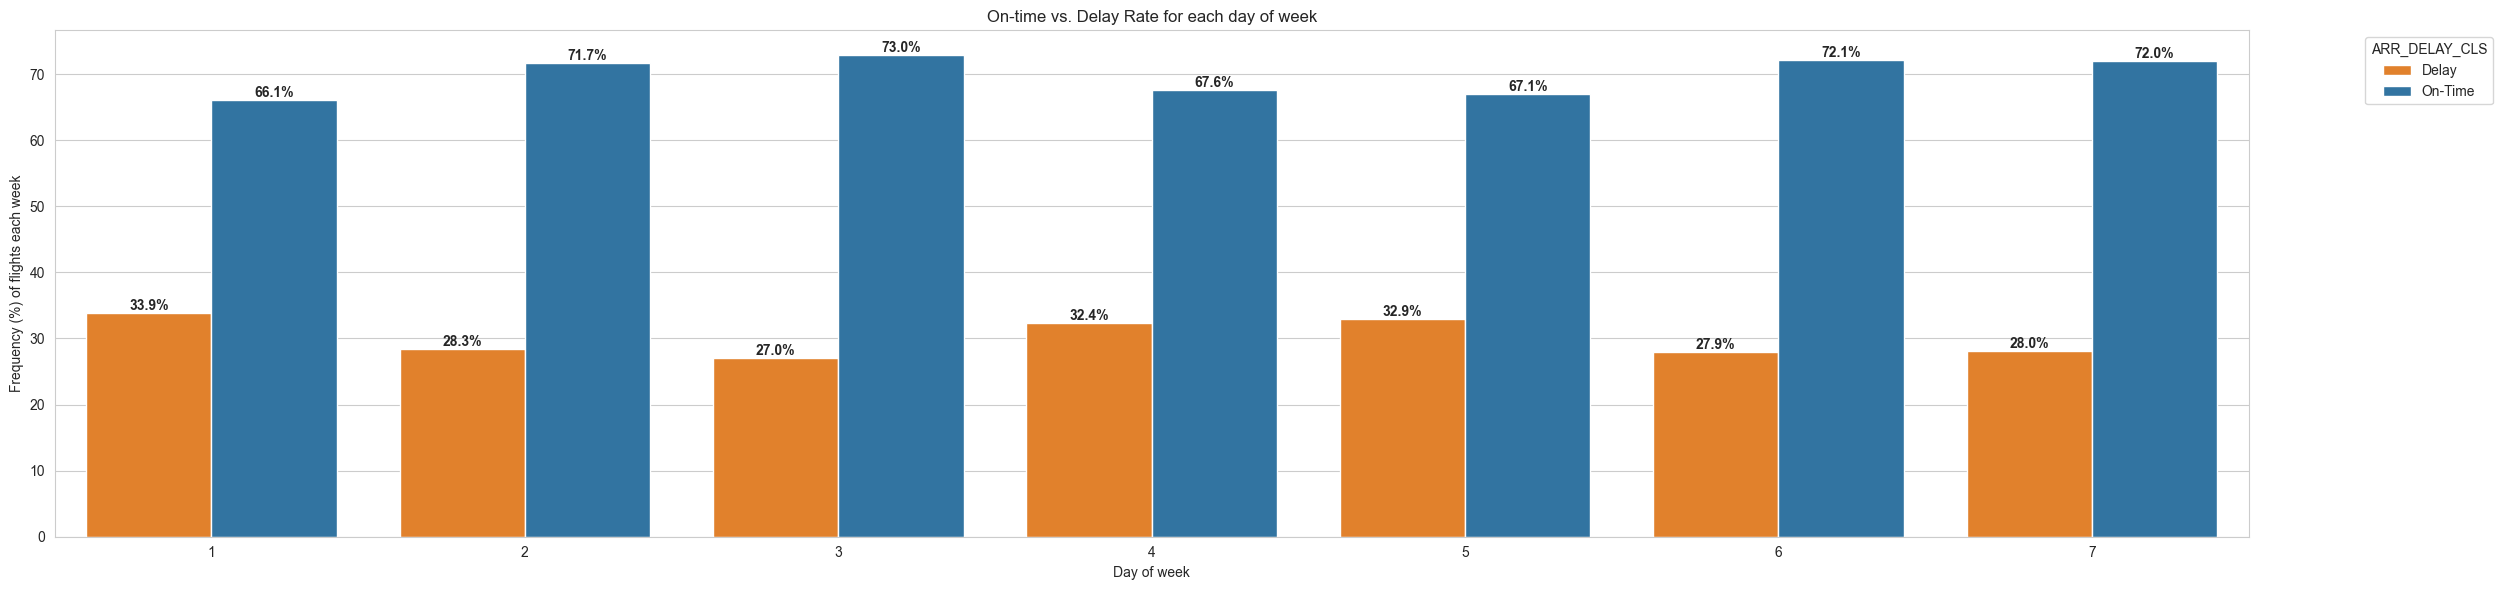

In [202]:
x='DAY_OF_WEEK'
y='DOW_COUNT'
hue='ARR_DELAY_CLS'
order = dow_cnt_per_arr_cls_df['DAY_OF_WEEK'].unique()
palette=color_mapping
figsize=(25, 6)
title = "On-time vs. Delay Rate for each day of week"
x_label = "Day of week"
y_label = "Frequency (%) of flights each week"
get_bar_plot(x,y,hue,dow_cnt_per_arr_cls_df,order,palette,title,x_label,y_label,figsize)

- Based on the above graph we can tell that the Day 1, 4 and 5 have more chances of delay compared to to others. We can see that there is dependency between day of week and delay rates
- The graph shows slight association between Day of Week and Frequency of Flights

- Hypothesis Testing - Chi-Square Test of Independence between `DAY_OF_WEEK` and `ARR_DELAY_CLS`
    - Null Hypothesis: DAY_OF_WEEK and ARR_DELAY_CLS are independent of each other.
    - Alternate Hypothesis: DAY_OF_WEEK and ARR_DELAY_CLS are dependent on each other

In [203]:
contingency_table = pd.crosstab(data['DAY_OF_WEEK'], data['ARR_DELAY_CLS'])

In [204]:
contingency_table

ARR_DELAY_CLS  Delay  On-Time
DAY_OF_WEEK                  
1               7607    14826
2               6100    15426
3               5897    15912
4               7147    14931
5               7240    14734
6               4762    12307
7               5705    14640

In [205]:
chi2, p, dof, expected = scipy.stats.chi2_contingency(contingency_table)

In [206]:
print(f"  chi2 = {chi2:.3f}, p = {p:.3f}, dof = {dof}")

  chi2 = 501.256, p = 0.000, dof = 6


- As p-value (0.000) is less than 0.05, so DAY_OF_WEEK and ARR_DELAY_CLS are dependent on each other

<Figure size 2200x2000 with 0 Axes>

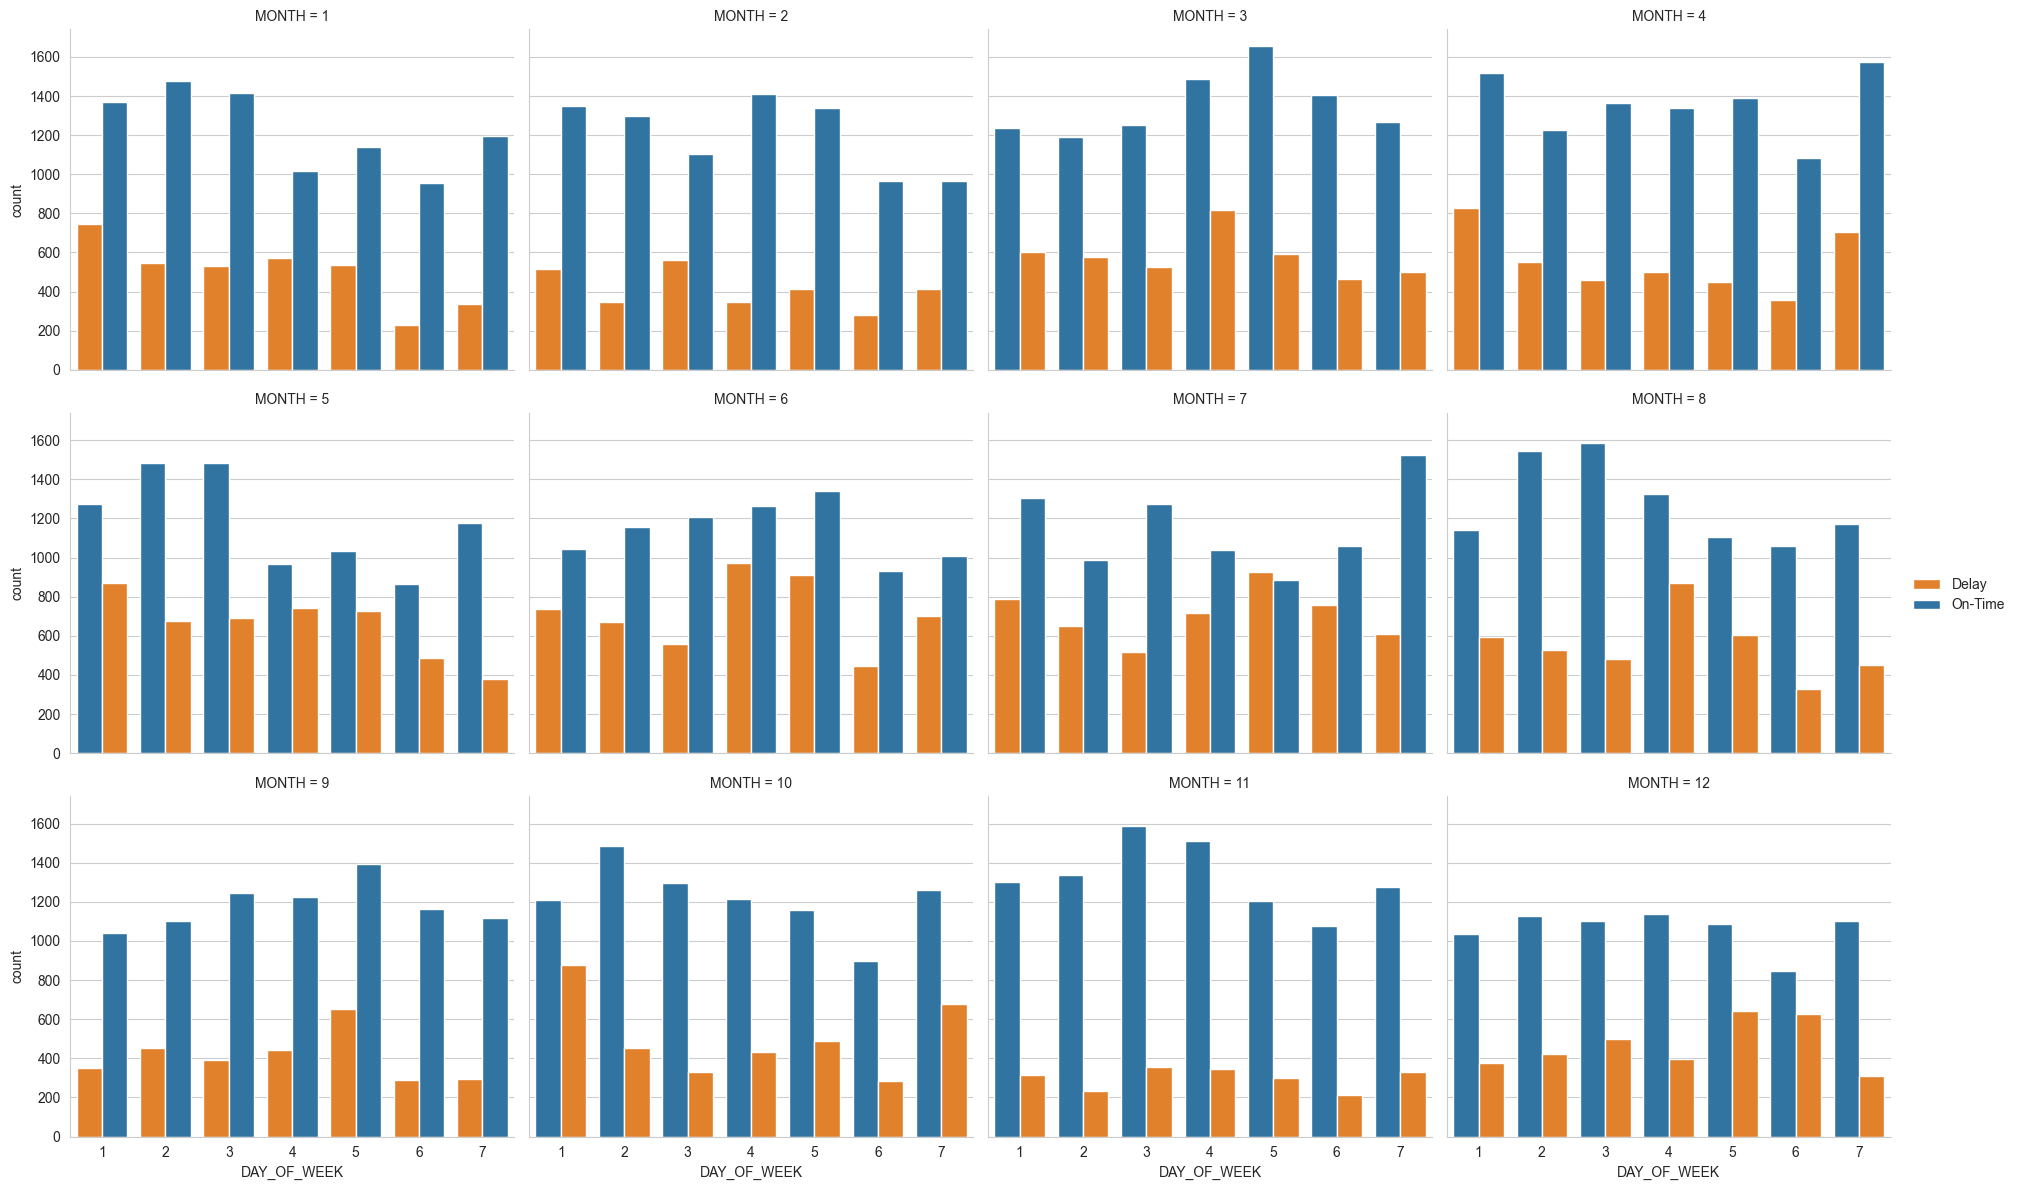

In [207]:
plt.figure(figsize=(22, 20))
g = sns.FacetGrid(
    data,
    col="MONTH",
    col_wrap=4,
    height=4,
    aspect=1.2
)
g.map_dataframe(
    sns.countplot,
    x="DAY_OF_WEEK",
    hue="ARR_DELAY_CLS",
    palette=color_mapping
)
g.add_legend()
plt.show()

- Based on the above graph in which we considered MONTH and DAY OF WEEK we can see that in `MONTH 5`,`MONTH 6` annd `MONTH 7` there are high number of delays based on day of the week
- We can also see that during `MONTH 11` Delay is less
- Based on this graph we can tell that both month and day of the week are dependent to delay

### Weekend vs Weekday Analysis

In [208]:
# filtering weekdays and weekend data
weekday_data = data[data['DAY_OF_WEEK']<6].astype('object')
weekend_data = data[data['DAY_OF_WEEK']>=6].astype('object')
weekday_data.loc[:, 'DAY_OF_WEEK'] = 'Weekday'
weekend_data.loc[:, 'DAY_OF_WEEK'] = 'Weekend'

In [209]:
# Aggregating the frequency using ARR_DELAY_CLS
weekday_data = weekday_data.groupby(['DAY_OF_WEEK','ARR_DELAY_CLS'],as_index=False).agg(frequency=('ARR_DELAY_CLS',"count"))
weekend_data = weekend_data.groupby(['DAY_OF_WEEK','ARR_DELAY_CLS'],as_index=False).agg(frequency=('ARR_DELAY_CLS',"count"))

In [210]:
weekday_data

DAY_OF_WEEK ARR_DELAY_CLS  frequency
0     Weekday         Delay      33991
1     Weekday       On-Time      75829

In [211]:
# Calculating the relative percentage of weekday
weekday_data['PERCENT'] = weekday_data.groupby("DAY_OF_WEEK")['frequency'].transform(lambda x: 100*x/x.sum())

In [212]:
weekday_data

DAY_OF_WEEK ARR_DELAY_CLS  frequency    PERCENT
0     Weekday         Delay      33991  30.951557
1     Weekday       On-Time      75829  69.048443

In [213]:
# Calculating the relative percentage of weekend
weekend_data['PERCENT'] = weekend_data.groupby("DAY_OF_WEEK")['frequency'].transform(lambda x: 100*x/x.sum())

In [214]:
weekend_data

DAY_OF_WEEK ARR_DELAY_CLS  frequency    PERCENT
0     Weekend         Delay      10467  27.976159
1     Weekend       On-Time      26947  72.023841

In [215]:
# merging the weekday and weekend data to plot
weekday_vs_weekend = pd.concat([weekday_data,weekend_data])

In [216]:
weekday_vs_weekend

DAY_OF_WEEK ARR_DELAY_CLS  frequency    PERCENT
0     Weekday         Delay      33991  30.951557
1     Weekday       On-Time      75829  69.048443
0     Weekend         Delay      10467  27.976159
1     Weekend       On-Time      26947  72.023841

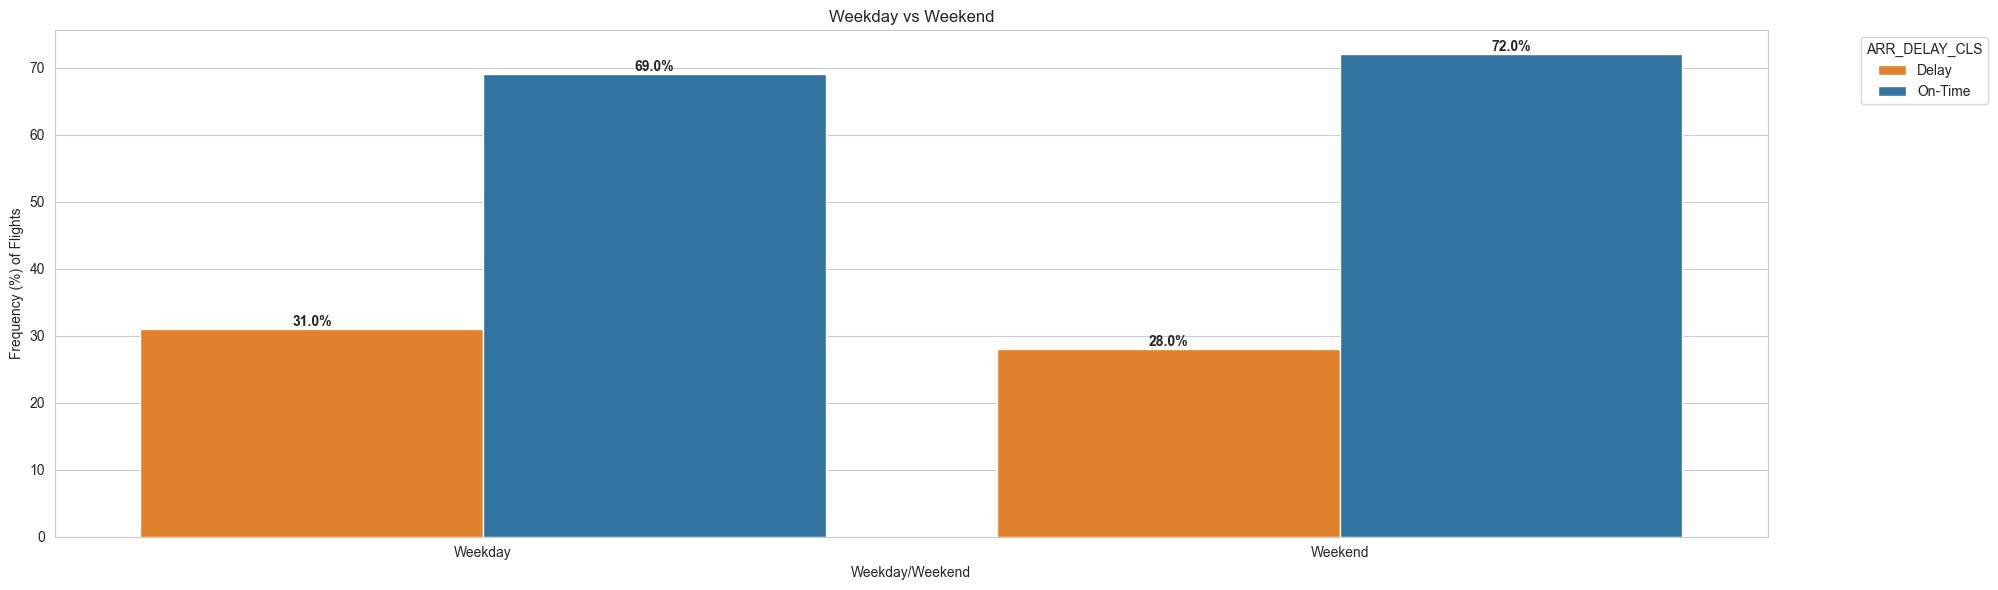

In [217]:
x='DAY_OF_WEEK'
y='PERCENT'
hue='ARR_DELAY_CLS'
order = None
palette=color_mapping
figsize=(20, 6)
title = "Weekday vs Weekend"
x_label = "Weekday/Weekend"
y_label = "Frequency (%) of Flights"
get_bar_plot(x,y,hue,weekday_vs_weekend,order,palette,title,x_label,y_label,figsize)

- Based on the above observation, we can see that on weekday and weekend the delay rates are almost similar which shows delay rates are slightly dependent on weekdays and weekends

## ORIGIN Analysis

In [218]:
data['ORIGIN'].unique()

['LIT', 'BOS', 'ATL', 'MSY', 'SAN', ..., 'FCA', 'RNO', 'LCK', 'FAR', 'RAP']
Length: 164
Categories (167, object): ['ABE', 'ABQ', 'ABY', 'ACY', ..., 'LCK', 'MTJ', 'RNO', 'RAP']

- Considering top 10 for analysis to understand the distribution

In [219]:
# identifying the top 10 origins
top_10_origin_count = data['ORIGIN'].value_counts().sort_values(ascending=False)[:10].reset_index()

In [220]:
top_10_origin_count

ORIGIN  count
0    ATL  72073
1    SAV   1975
2    LGA   1798
3    MCO   1751
4    FLL   1577
5    ORD   1571
6    BOS   1479
7    CLT   1460
8    DFW   1457
9    TPA   1360

In [221]:
top_10_origin_count['orign_percent'] = top_10_origin_count.groupby(['ORIGIN'],observed=True)['count'].transform(lambda x: 100*x/data.shape[0])

In [222]:
top_10_origin_count

ORIGIN  count  orign_percent
0    ATL  72073      48.951329
1    SAV   1975       1.341402
2    LGA   1798       1.221185
3    MCO   1751       1.189263
4    FLL   1577       1.071084
5    ORD   1571       1.067009
6    BOS   1479       1.004523
7    CLT   1460       0.991619
8    DFW   1457       0.989581
9    TPA   1360       0.923700

In [223]:
top_10_origin_count['ORIGIN'] = top_10_origin_count['ORIGIN'].astype(str)

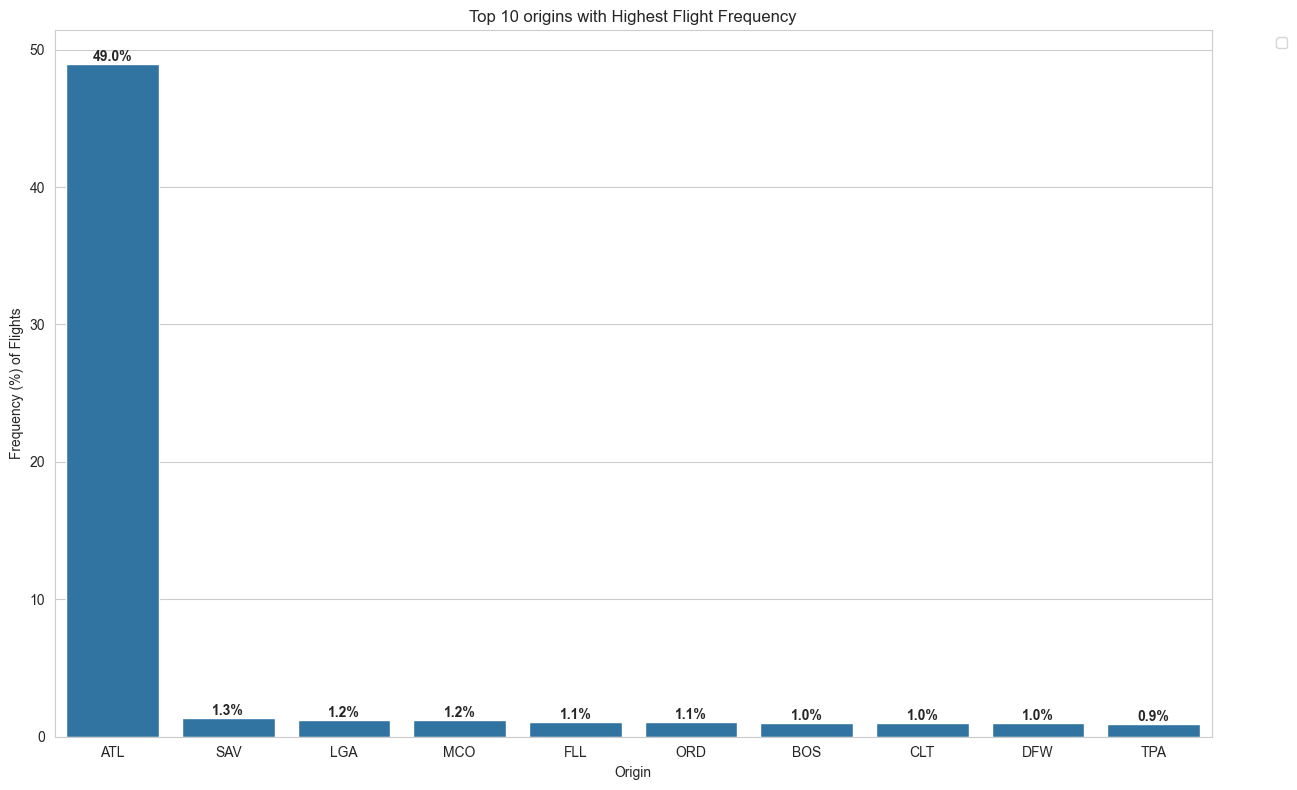

In [224]:
x='ORIGIN'
y='orign_percent'
hue=None
order = None
palette=None
figsize=(13, 8)
title = "Top 10 origins with Highest Flight Frequency"
x_label = "Origin"
y_label = "Frequency (%) of Flights"
get_bar_plot(x,y,hue,top_10_origin_count,order,palette,title,x_label,y_label,figsize)

- Based on the above observation, around 49% of the origin code is Atlanta

In [225]:
org_cnt_per_arr_cls_df = data.groupby(by=["ORIGIN","ARR_DELAY_CLS"],observed=True,as_index=False)["ORIGIN"].agg(ORG_COUNT=("count"))
org_cnt_per_arr_cls_df['ORG_COUNT'] = org_cnt_per_arr_cls_df.groupby("ORIGIN",observed=True)['ORG_COUNT'].transform(lambda x: 100*x/x.sum())

In [226]:
top_10_origin_delay_cls = pd.merge(top_10_origin_count,org_cnt_per_arr_cls_df,how="inner",on="ORIGIN")

In [227]:
top_10_origin_delay_cls

ORIGIN  count  orign_percent ARR_DELAY_CLS  ORG_COUNT
0     ATL  72073      48.951329         Delay  31.574931
1     ATL  72073      48.951329       On-Time  68.425069
2     SAV   1975       1.341402         Delay  27.594937
3     SAV   1975       1.341402       On-Time  72.405063
4     LGA   1798       1.221185         Delay  30.867631
5     LGA   1798       1.221185       On-Time  69.132369
6     MCO   1751       1.189263         Delay  29.925757
7     MCO   1751       1.189263       On-Time  70.074243
8     FLL   1577       1.071084         Delay  32.530120
9     FLL   1577       1.071084       On-Time  67.469880
10    ORD   1571       1.067009         Delay  34.436665
11    ORD   1571       1.067009       On-Time  65.563335
12    BOS   1479       1.004523         Delay  34.212306
13    BOS   1479       1.004523       On-Time  65.787694
14    CLT   1460       0.991619         Delay  34.726027
15    CLT   1460       0.991619       On-Time  65.273973
16    DFW   1457       0.989581         Delay  33.081675
17    DFW   1457       0.989581       On-Time  66.918325
18    TPA   1360       0.923700         Delay  34.411765
19    TPA   1360       0.923700       On-Time  65.588235

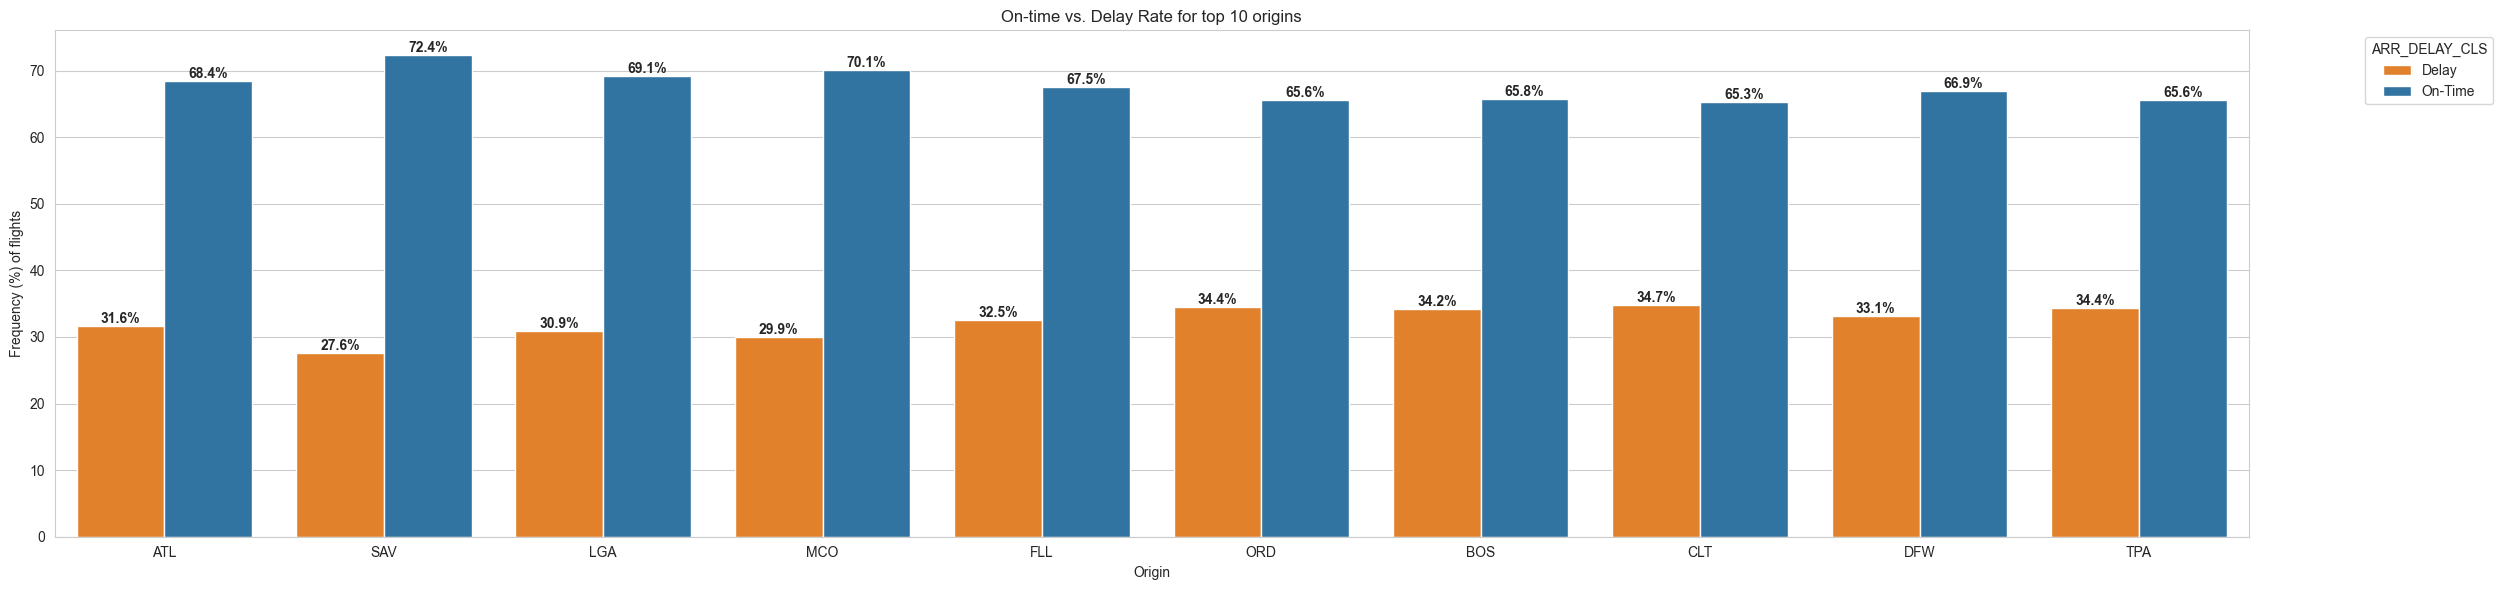

In [228]:
x='ORIGIN'
y='ORG_COUNT'
hue='ARR_DELAY_CLS'
order = top_10_origin_delay_cls['ORIGIN'].unique()
palette=color_mapping
figsize=(25, 6)
title = "On-time vs. Delay Rate for top 10 origins"
x_label = "Origin"
y_label = "Frequency (%) of flights"
get_bar_plot(x,y,hue,top_10_origin_delay_cls,order,palette,title,x_label,y_label,figsize)

 - Based on the above observation, we can see that Origin is slightly dependent with Flight Delays

In [229]:
top_10_org = list(top_10_origin_delay_cls['ORIGIN'].unique())

In [230]:
top_10_org

['ATL', 'SAV', 'LGA', 'MCO', 'FLL', 'ORD', 'BOS', 'CLT', 'DFW', 'TPA']

- Hypothesis Testing - Chi-Square Test of Independence between `ORIGIN` and `ARR_DELAY_CLS`
    - Null Hypothesis: ORIGIN and ARR_DELAY_CLS are independent of each other.
    - Alternate Hypothesis: ORIGIN and ARR_DELAY_CLS are dependent on each other

In [231]:
contingency_table = pd.crosstab(data['ORIGIN'], data['ARR_DELAY_CLS'])

In [232]:
contingency_table

ARR_DELAY_CLS  Delay  On-Time
ORIGIN                       
ABE               60      122
ABQ               26      140
ABY               51       74
ACY               13       24
AEX               37       83
AGS              207      339
ALB               46      167
ANC                2       16
ASE                3       10
ATL            22757    49316
ATW               29      111
AUS              199      503
AVL              124      279
AVP               22       49
BDL              101      363
BHM              192      463
BMI               60      121
BNA              195      495
BOS              506      973
BQK               55       94
BTR              157      317
BTV               14       43
BUF               85      217
BWI              426      873
BZN                4        7
CAE              132      385
CAK               51      175
CHA              133      317
CHO               74      148
CHS              130      575
CID               36      109
CLE              241      513
CLT              507      953
CMH              168      583
COS               16       53
CRW               72      157
CSG               60      116
CVG              137      415
DAB               73      277
DAL              254      443
DAY               64      216
DCA              382      880
DEN              286      818
DFW              482      975
DHN              116      142
DSM               54      161
DTW              405      782
ECP               79      271
ELM                1        1
ELP               35      130
EVV               37       85
EWN               35       56
EWR              415      892
EYW               81      209
FAY               94      181
FCA                2        1
FLL              513     1064
FNT               31      165
FSD               18       57
FSM               36      117
FWA              103      181
GNV               88      196
GPT               57      186
GRB               22       75
GRK               20       53
GRR               81      255
GSO              105      432
GSP              202      533
GTR               73      134
HNL                9       52
HOU              256      544
HPN              122      263
HSV               97      386
IAD              180      533
IAH              278      655
ICT               43      166
ILM               62      178
IND              256      563
ISP                0        2
JAC                5       16
JAN              107      366
JAX              274      771
JFK              264      480
LAS              228      696
LAX              486      816
LEX              114      321
LFT               76      183
LGA              555     1243
LIT               90      327
LNK               12       45
MCI              200      577
MCO              524     1227
MDT               50      168
MDW              263      553
MEM              192      523
MGM              126      219
MHT               19       60
MIA              378      780
MKE              165      506
MLB               68      252
MLI               72      115
MLU               77      133
MOB              125      239
MSN               41      171
MSO                0        1
MSP              227      768
MSY              344      779
MYR               52      202
OAJ               45      118
OAK               35       47
OKC               78      336
OMA               53      254
ORD              541     1030
ORF              154      419
PBI              211      596
PDX               55      213
PHF               53      157
PHL              445      854
PHX              162      403
PIA               49       63
PIT              178      527
PNS              116      437
PVD               44      149
PWM               34      111
RDU              337      656
RIC              242      608
ROA               99      145
ROC               42      174
RST               27       78
RSW              189      604
SAN              120      359
SAT       

In [233]:
chi2, p, dof, expected = scipy.stats.chi2_contingency(contingency_table)

In [234]:
print(f"  chi2 = {chi2:.3f}, p = {p:.3f}, dof = {dof}")

  chi2 = 1106.657, p = 0.000, dof = 163


- As p-value (0.000) is less than 0.05, so ORIGIN and ARR_DELAY_CLS are dependent on each other

## DESTINATION Analysis

In [235]:
# identifying the top 10 destinations
top_10_dest_count = data['DEST'].value_counts().sort_values(ascending=False)[:10].reset_index()

In [236]:
top_10_dest_count

DEST  count
0  ATL  72408
1  SAV   1931
2  LGA   1859
3  MCO   1818
4  ORD   1619
5  DFW   1481
6  FLL   1477
7  BOS   1472
8  CLT   1464
9  TPA   1434

In [237]:
top_10_dest_count['dest_percent'] = top_10_dest_count.groupby(['DEST'])['count'].transform(lambda x: 100*x/data.shape[0])
top_10_dest_count['DEST'] = top_10_dest_count['DEST'].astype(str)

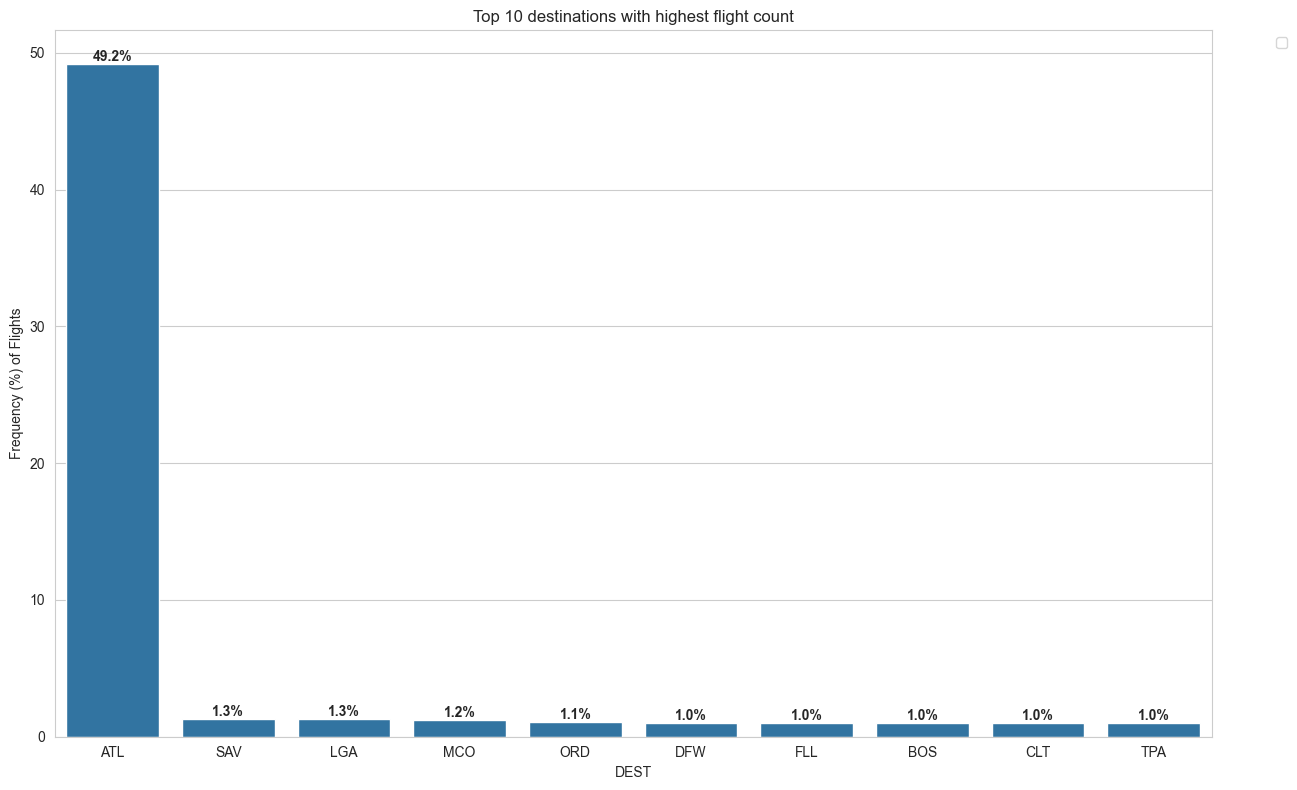

In [238]:
x='DEST'
y='dest_percent'
hue=None
order = None
palette=None
figsize=(13, 8)
title = "Top 10 destinations with highest flight count"
x_label = "DEST"
y_label = "Frequency (%) of Flights"
get_bar_plot(x,y,hue,top_10_dest_count,order,palette,title,x_label,y_label,figsize)

- Based on the above observation arounnd 49.2% of Destinnation code is Atlanta

In [239]:
dest_cnt_per_arr_cls_df = data.groupby(by=["DEST","ARR_DELAY_CLS"],observed=True,as_index=False)["DEST"].agg(DEST_COUNT=("count"))
dest_cnt_per_arr_cls_df['DEST_COUNT'] = dest_cnt_per_arr_cls_df.groupby("DEST",observed=True)['DEST_COUNT'].transform(lambda x: 100*x/x.sum())

In [240]:
top_10_dest_delay_cls = pd.merge(top_10_dest_count,dest_cnt_per_arr_cls_df,how="inner",on="DEST")

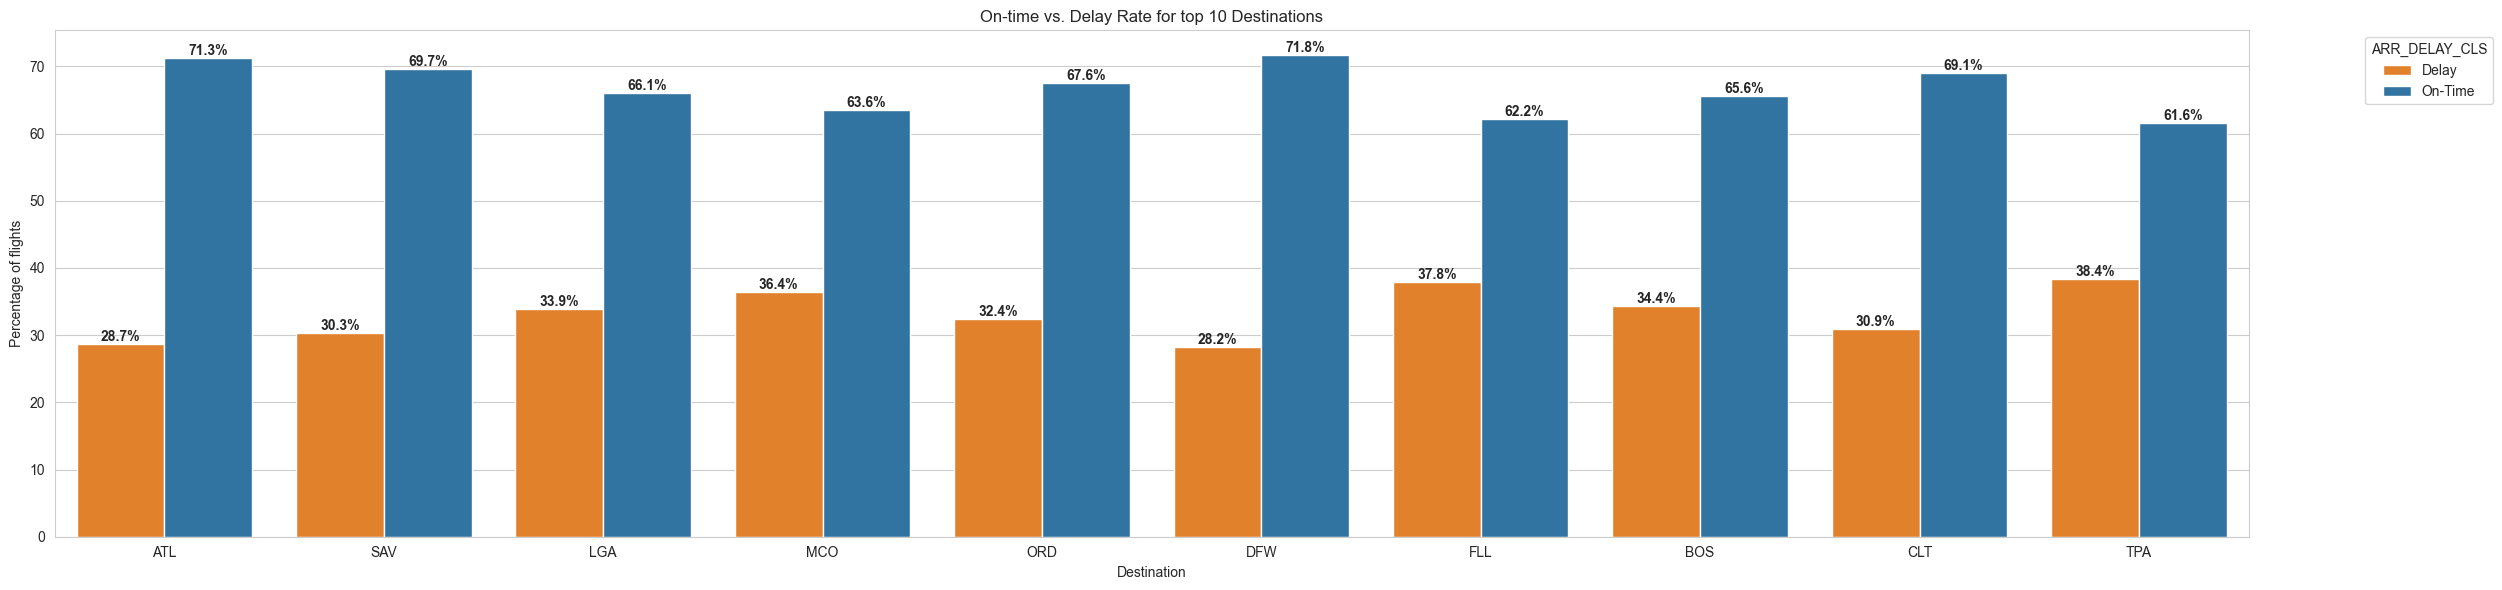

In [241]:
x='DEST'
y='DEST_COUNT'
hue='ARR_DELAY_CLS'
order = top_10_dest_delay_cls['DEST'].unique()
palette=color_mapping
figsize=(25, 6)
title = "On-time vs. Delay Rate for top 10 Destinations"
x_label = "Destination"
y_label = "Percentage of flights"
get_bar_plot(x,y,hue,top_10_dest_delay_cls,order,palette,title,x_label,y_label,figsize)

 - Based on the above analysis, we see that
    - `DFW` and `ATL` have higher on-time rate compared to other destinations
    - `TPA` and `FLL` have higher chances of Delay

- Hypothesis Testing - Chi-Square Test of Independence between `DEST` and `ARR_DELAY_CLS`
    - Null Hypothesis: DEST and ARR_DELAY_CLS are independent of each other.
    - Alternate Hypothesis: DEST and ARR_DELAY_CLS are dependent on each other

In [242]:
contingency_table = pd.crosstab(data['DEST'], data['ARR_DELAY_CLS'])

In [243]:
contingency_table

ARR_DELAY_CLS  Delay  On-Time
DEST                         
ABE               40      117
ABQ               20       84
ABY               53       89
ACY                9       24
AEX               32       72
AGS              218      356
ALB               41      152
ATL            20784    51624
ATW               31       85
AUS              241      473
AVL              143      307
AVP                9       39
BDL               98      336
BHM              201      468
BMI               57      124
BNA              240      442
BOS              506      966
BQK               37       80
BTR              162      336
BTV               20       65
BUF              100      234
BWI              414      915
BZN               18        8
CAE              130      417
CAK               68      165
CHA              162      289
CHO               74      153
CHS              169      481
CID               43      101
CLE              204      506
CLT              453     1011
CMH              225      531
COS               26       38
CRW               88      166
CSG               54      114
CVG              114      406
DAB               83      237
DAL              265      430
DAY               82      201
DCA              390      846
DEN              240      585
DFW              418     1063
DHN               91      150
DSM               47      141
DTW              367      762
ECP              103      297
EGE                4       15
ELM                1        2
ELP               18       89
EVV               37       85
EWN               21       62
EWR              525      845
EYW               73      211
FAY               78      181
FCA                3        2
FLL              559      918
FNT               55      144
FSD               11       50
FSM               41      101
FWA               91      180
GNV               96      212
GPT               75      200
GRB               19       64
GRK               33       46
GRR               88      223
GSO              107      422
GSP              233      468
GTR               70      119
HDN                9       20
HNL               19       69
HOU              279      512
HPN              151      268
HSV              131      352
IAD              189      589
IAH              282      612
ICT               52      138
ILM               72      181
IND              273      551
JAC                4       16
JAN              120      320
JAX              355      686
JFK              255      444
LAS              287      659
LAX              546      717
LCK                1        3
LEX              107      310
LFT               70      169
LGA              631     1228
LIT              118      331
LNK               17       37
MCI              270      552
MCO              662     1156
MDT               32      160
MDW              280      576
MEM              228      487
MGM              153      206
MHT               19       63
MIA              338      832
MKE              193      476
MLB               81      228
MLI               87      114
MLU               77      164
MOB              139      236
MSN               57      166
MSP              309      691
MSY              378      735
MTJ                1        5
MYR               66      218
OAJ               56      122
OAK               45       35
OKC               86      287
OMA               75      273
ORD              525     1094
ORF              135      453
PBI              310      581
PDX               98      152
PHF               57      137
PHL              382      874
PHX              230      450
PIA               40       84
PIT              181      496
PNS              145      359
PVD               56      156
PWM               31       89
RDU              352      671
RIC              233      613
RNO                1        4
ROA               77      149
ROC               42      144
RST               36       61
RSW              235      515
SAN       

In [244]:
chi2, p, dof, expected = scipy.stats.chi2_contingency(contingency_table)

In [245]:
print(f"  chi2 = {chi2:.3f}, p = {p:.3f}, dof = {dof}")

  chi2 = 1036.894, p = 0.000, dof = 164


- As p-value (0.000) is less than 0.05, so DEST and ARR_DELAY_CLS are dependent on each other

## ORIGIN_CITY_TIME_ZONE Analysis

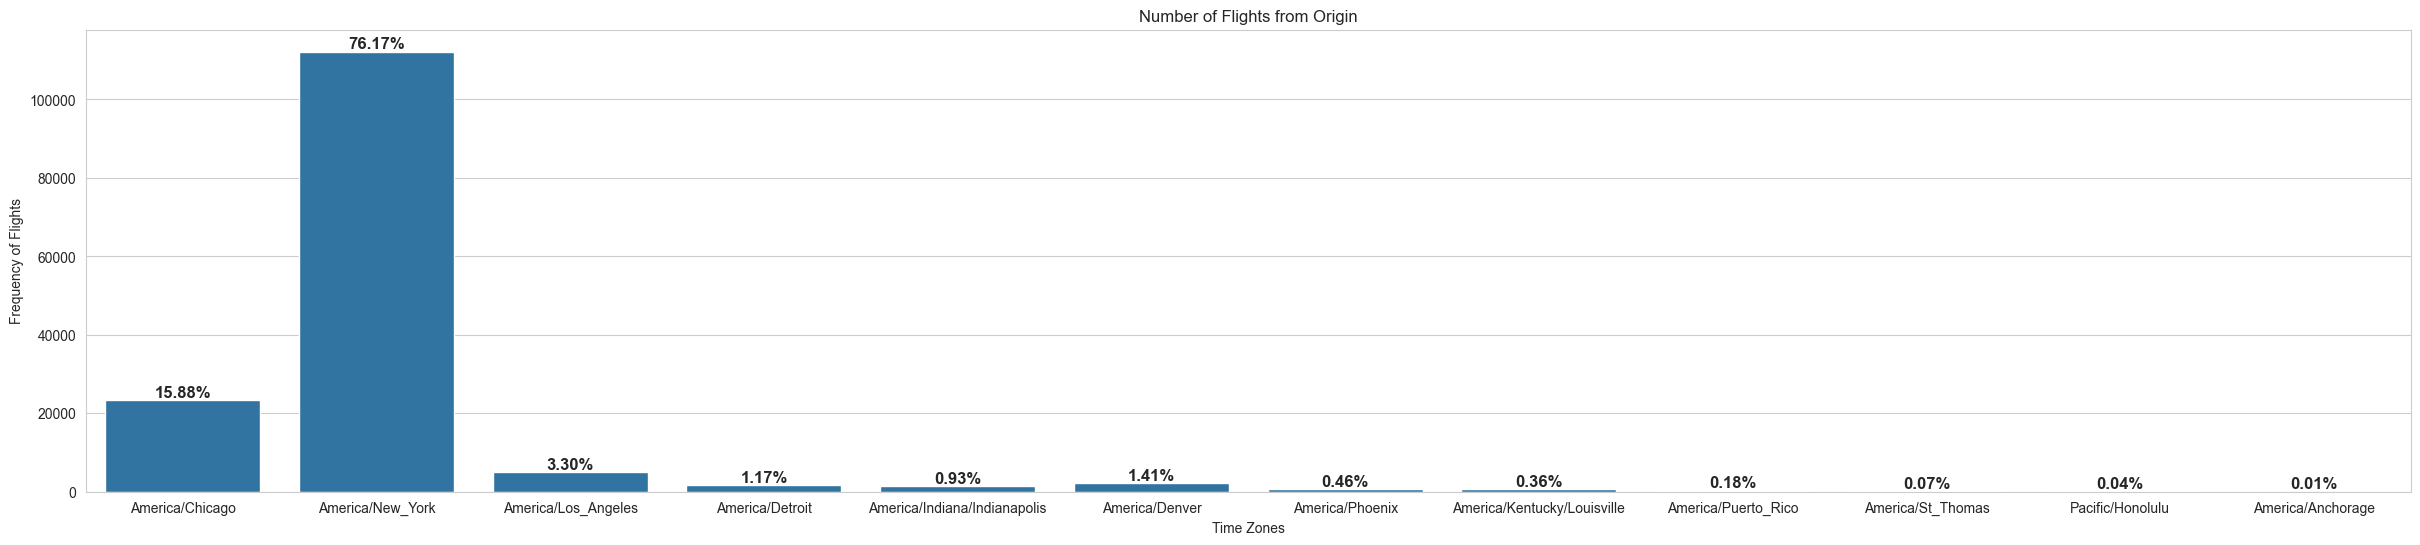

In [246]:
title = "Number of Flights from Origin"
x = "ORIGIN_CITY_TIME_ZONE"
x_label = 'Time Zones'
y_label = 'Frequency of Flights'
total = len(data)
hue=None
get_count_plot(x,data,title,x_label,y_label,hue,total,figsize=(30,6))

 - Based on the above observation, we see that the maximum number of frequency of flights are in America/New_York time zone

In [247]:
origin_tmz_cnt_per_arr_cls_df = data.groupby(by=["ORIGIN_CITY_TIME_ZONE","ARR_DELAY_CLS"],as_index=False)["ORIGIN_CITY_TIME_ZONE"].agg(ORIGIN_TMZ_COUNT=("count"))
origin_tmz_cnt_per_arr_cls_df['ORIGIN_TMZ_PERCENT'] = origin_tmz_cnt_per_arr_cls_df.groupby("ORIGIN_CITY_TIME_ZONE")['ORIGIN_TMZ_COUNT'].transform(lambda x: 100*x/x.sum())

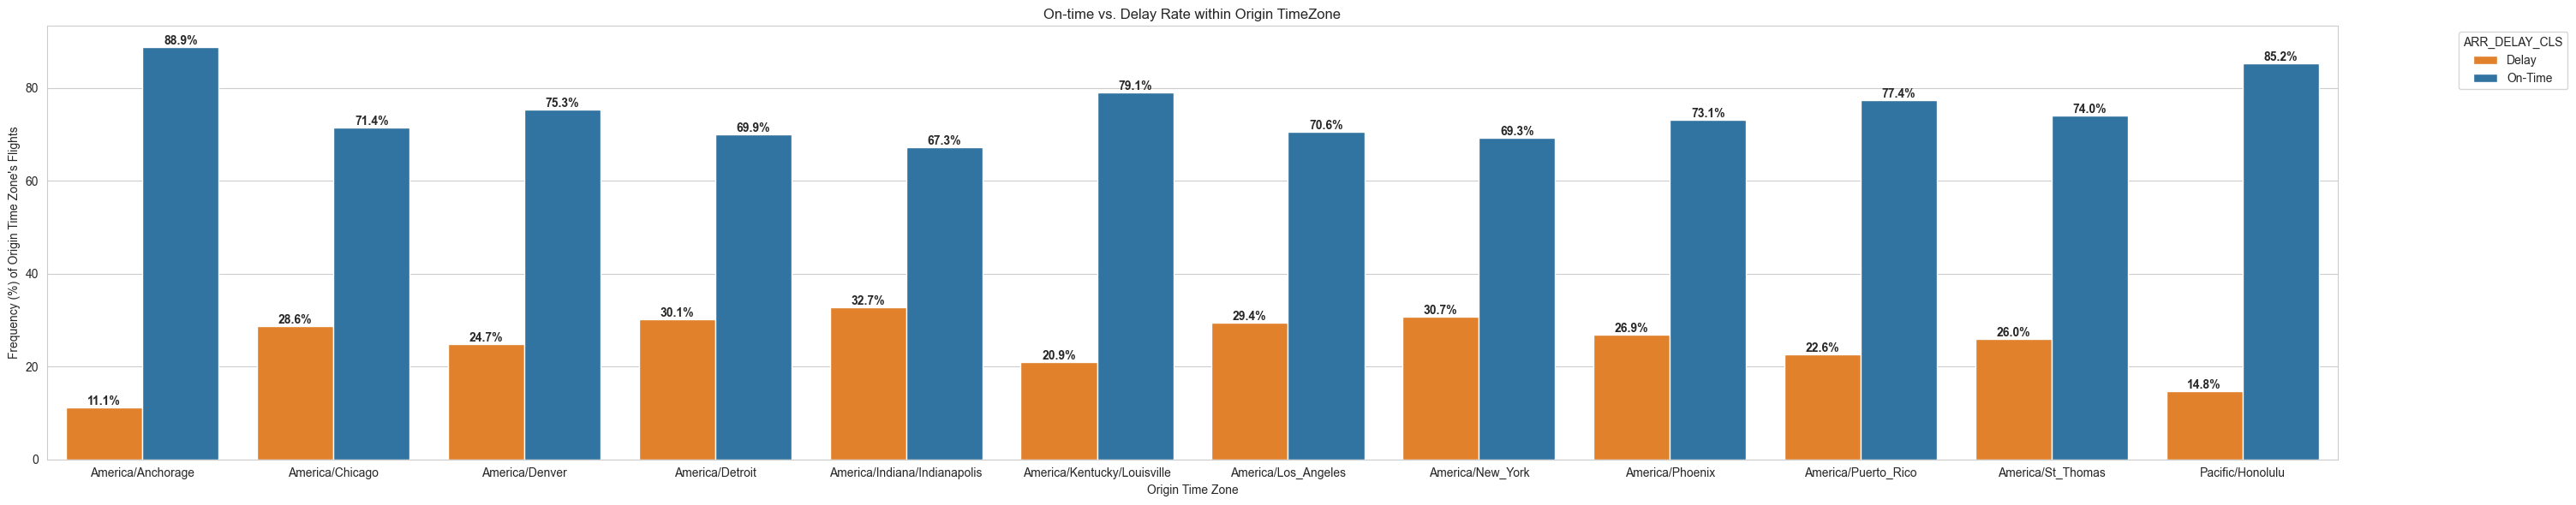

In [248]:
figsize=(30, 6)
title = "On-time vs. Delay Rate within Origin TimeZone"
x_label = "Origin Time Zone"
y_label = "Frequency (%) of Origin Time Zone's Flights"
x='ORIGIN_CITY_TIME_ZONE'
y='ORIGIN_TMZ_PERCENT'
hue='ARR_DELAY_CLS'
order=origin_tmz_cnt_per_arr_cls_df['ORIGIN_CITY_TIME_ZONE'].value_counts().index
palette=color_mapping
get_bar_plot(x,y,hue,origin_tmz_cnt_per_arr_cls_df,order,palette,title,x_label,y_label,figsize)

- We can see that time zone flying from `AMERICAN/INDIANA/INDIANAPOLIS` has more `DELAY` rate and `AMERICA/ANCHORAGE` has less `DELAY` rate
- `AMERICA/NEWYORK` is the busiest `ORIGIN_CITY_TIME_ZONE` being one of the least `ON-TIME` rate
- Based on this graph we can tell that there is dependency between Origin time zone and Delay

- Hypothesis Testing - Chi-Square Test of Independence between `ORIGIN_CITY_TIME_ZONE` and `ARR_DELAY_CLS`
    - Null Hypothesis: ORIGIN_CITY_TIME_ZONE and ARR_DELAY_CLS are independent of each other.
    - Alternate Hypothesis: ORIGIN_CITY_TIME_ZONE and ARR_DELAY_CLS are dependent on each other

In [249]:
contingency_table = pd.crosstab(data['ORIGIN_CITY_TIME_ZONE'], data['ARR_DELAY_CLS'])

In [250]:
contingency_table

ARR_DELAY_CLS                 Delay  On-Time
ORIGIN_CITY_TIME_ZONE                       
America/Anchorage                 2       16
America/Chicago                6687    16697
America/Denver                  515     1566
America/Detroit                 518     1203
America/Indiana/Indianapolis    450      926
America/Kentucky/Louisville     112      424
America/Los_Angeles            1432     3432
America/New_York              34466    77688
America/Phoenix                 181      493
America/Puerto_Rico              59      202
America/St_Thomas                27       77
Pacific/Honolulu                  9       52

In [251]:
chi2, p, dof, expected = scipy.stats.chi2_contingency(contingency_table)

In [252]:
print(f"  chi2 = {chi2:.3f}, p = {p:.3f}, dof = {dof}")

  chi2 = 121.944, p = 0.000, dof = 11


- As p-value (0.000) is less than 0.05, so ORIGIN_CITY_TIME_ZONE and ARR_DELAY_CLS are dependent on each other

## DEST_CITY_TIME_ZONE Analysis

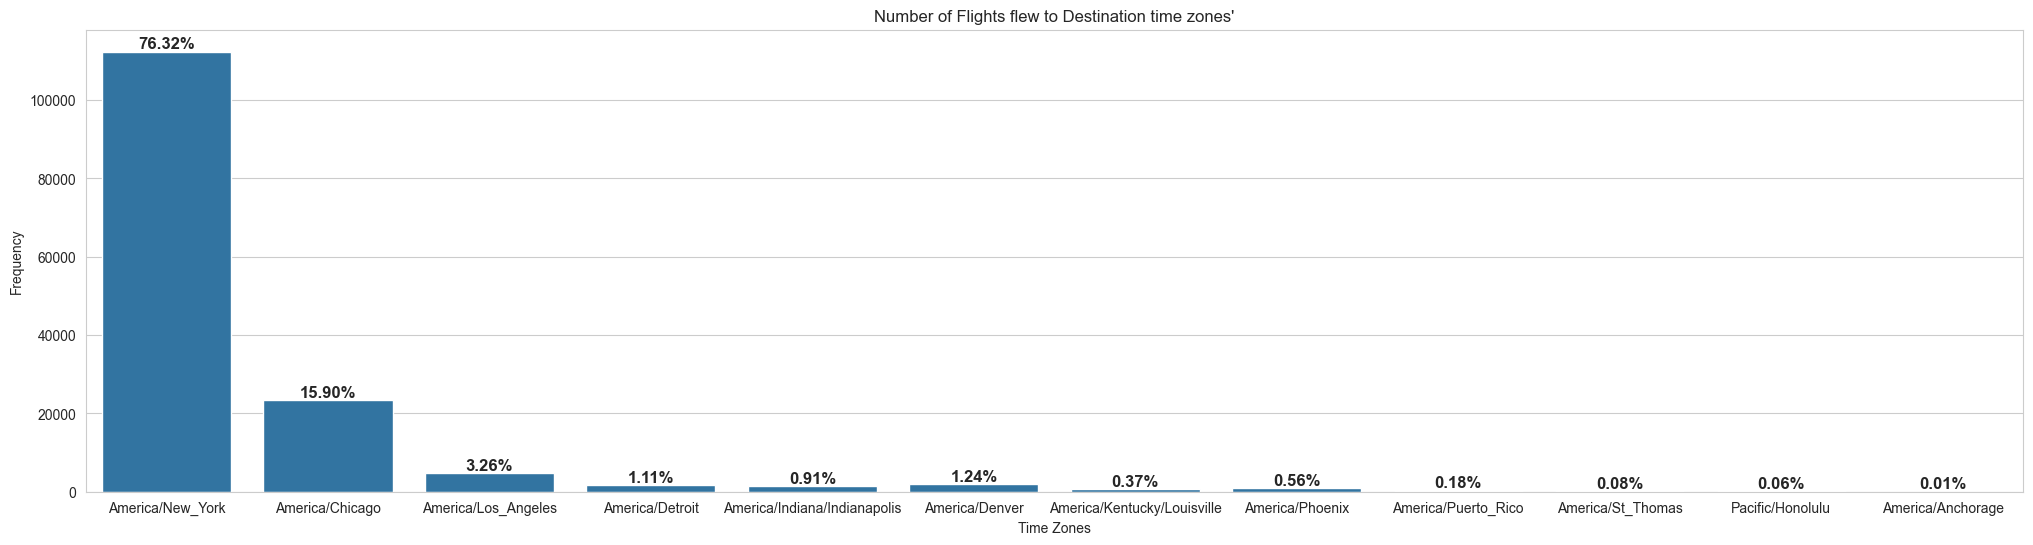

In [253]:
title = "Number of Flights flew to Destination time zones'"
x = "DEST_CITY_TIME_ZONE"
x_label = 'Time Zones'
y_label = 'Frequency'
total = len(data)
hue=None
get_count_plot(x,data,title,x_label,y_label,hue,total,figsize=(25,6))

- America/New_York has 76.32% of the total flights, making it the most common destination whereas America/Chicago is the second highest with 15.90%, but significantly less compared to New York.

In [254]:
dest_tmz_cnt_per_arr_cls_df = data.groupby(by=["DEST_CITY_TIME_ZONE","ARR_DELAY_CLS"],as_index=False)["DEST_CITY_TIME_ZONE"].agg(DEST_TMZ_COUNT=("count"))
dest_tmz_cnt_per_arr_cls_df['DEST_TMZ_PERCENT'] = dest_tmz_cnt_per_arr_cls_df.groupby("DEST_CITY_TIME_ZONE")['DEST_TMZ_COUNT'].transform(lambda x: 100*x/x.sum())

In [255]:
dest_tmz_cnt_per_arr_cls_df

DEST_CITY_TIME_ZONE ARR_DELAY_CLS  DEST_TMZ_COUNT  \
0              America/Anchorage         Delay               5   
1              America/Anchorage       On-Time              13   
2                America/Chicago         Delay            7302   
3                America/Chicago       On-Time           16114   
4                 America/Denver         Delay             556   
5                 America/Denver       On-Time            1263   
6                America/Detroit         Delay             510   
7                America/Detroit       On-Time            1131   
8   America/Indiana/Indianapolis         Delay             446   
9   America/Indiana/Indianapolis       On-Time             898   
10   America/Kentucky/Louisville         Delay             142   
11   America/Kentucky/Louisville       On-Time             398   
12           America/Los_Angeles         Delay            1773   
13           America/Los_Angeles       On-Time            3030   
14              America/New_York         Delay           33268   
15              America/New_York       On-Time           79099   
16               America/Phoenix         Delay             273   
17               America/Phoenix       On-Time             546   
18           America/Puerto_Rico         Delay             127   
19           America/Puerto_Rico       On-Time             132   
20             America/St_Thomas         Delay              37   
21             America/St_Thomas       On-Time              83   
22              Pacific/Honolulu         Delay              19   
23              Pacific/Honolulu       On-Time              69   

    DEST_TMZ_PERCENT  
0          27.777778  
1          72.222222  
2          31.183806  
3          68.816194  
4          30.566245  
5          69.433755  
6          31.078611  
7          68.921389  
8          33.184524  
9          66.815476  
10         26.296296  
11         73.703704  
12         36.914428  
13         63.085572  
14         29.606557  
15         70.393443  
16         33.333333  
17         66.666667  
18         49.034749  
19         50.965251  
20         30.833333  
21         69.166667  
22         21.590909  
23         78.409091

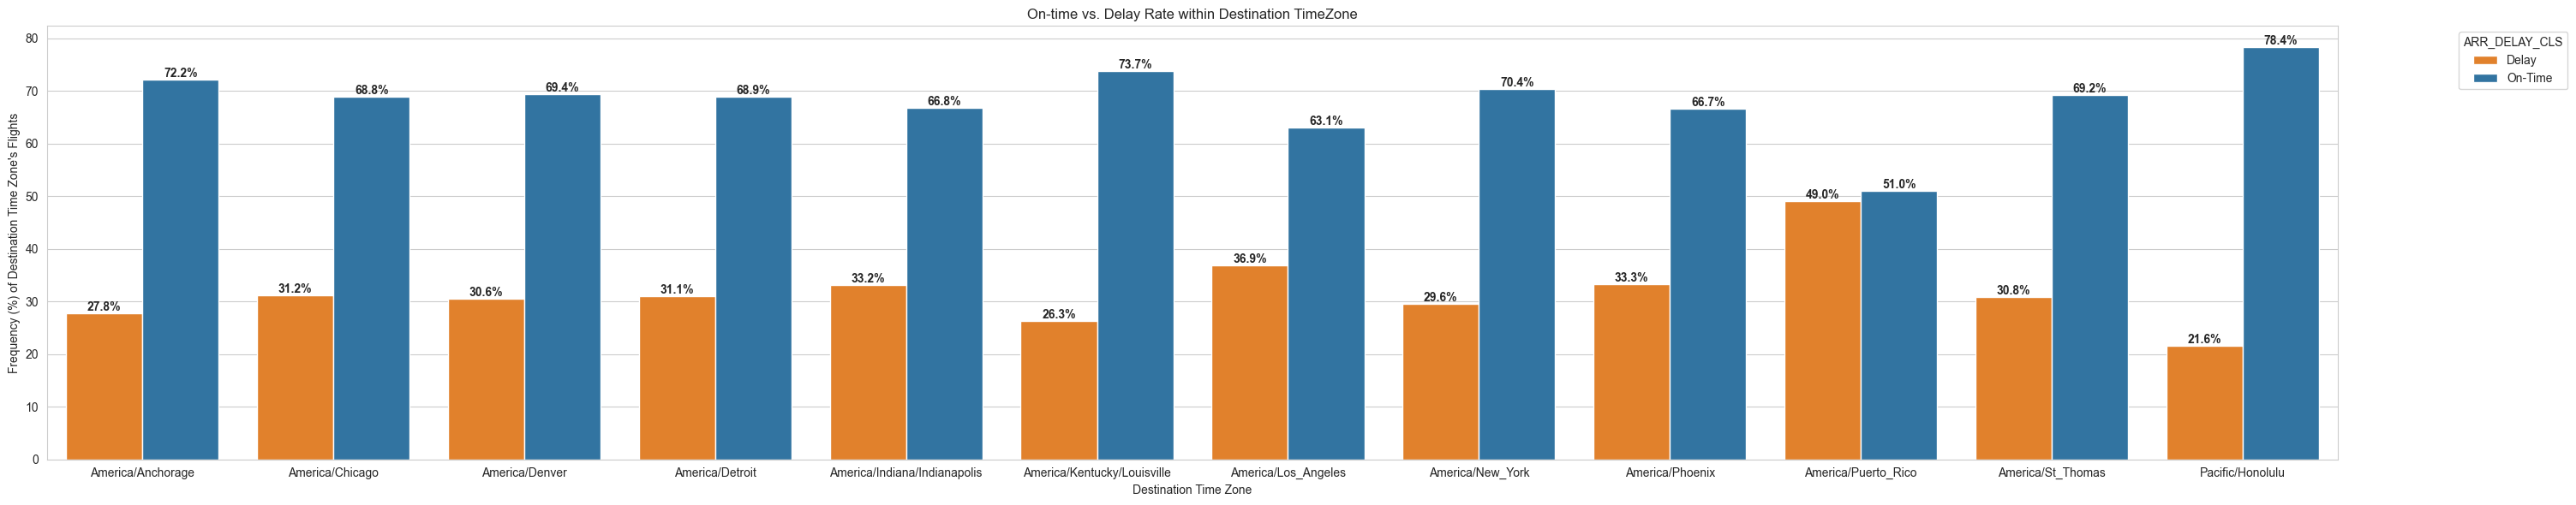

In [256]:
figsize=(30, 6)
title = "On-time vs. Delay Rate within Destination TimeZone"
x_label = "Destination Time Zone"
y_label = "Frequency (%) of Destination Time Zone's Flights"
x='DEST_CITY_TIME_ZONE'
y='DEST_TMZ_PERCENT'
hue='ARR_DELAY_CLS'
order=dest_tmz_cnt_per_arr_cls_df['DEST_CITY_TIME_ZONE'].value_counts().index
palette=color_mapping
get_bar_plot(x,y,hue,dest_tmz_cnt_per_arr_cls_df,order,palette,title,x_label,y_label,figsize)

- Based on the above observation, America/Puerto_Rico Time zone has maximum delays and Pacific/Honolulu has minimum number of delays.
- Based on this observation, Flights travelling to America/Puerto_Rico time zone has more chance of being delayed
- Based on this graph we can tell that there is dependency between Destination time zone and Delay

- Hypothesis Testing - Chi-Square Test of Independence between `DEST_CITY_TIME_ZONE` and `ARR_DELAY_CLS`
    - Null Hypothesis: DEST_CITY_TIME_ZONE and ARR_DELAY_CLS are independent of each other.
    - Alternate Hypothesis: DEST_CITY_TIME_ZONE and ARR_DELAY_CLS are dependent on each other

In [257]:
contingency_table = pd.crosstab(data['DEST_CITY_TIME_ZONE'], data['ARR_DELAY_CLS'])

In [258]:
contingency_table

ARR_DELAY_CLS                 Delay  On-Time
DEST_CITY_TIME_ZONE                         
America/Anchorage                 5       13
America/Chicago                7302    16114
America/Denver                  556     1263
America/Detroit                 510     1131
America/Indiana/Indianapolis    446      898
America/Kentucky/Louisville     142      398
America/Los_Angeles            1773     3030
America/New_York              33268    79099
America/Phoenix                 273      546
America/Puerto_Rico             127      132
America/St_Thomas                37       83
Pacific/Honolulu                 19       69

In [259]:
chi2, p, dof, expected = scipy.stats.chi2_contingency(contingency_table)

In [260]:
print(f"  chi2 = {chi2:.3f}, p = {p:.3f}, dof = {dof}")

  chi2 = 193.131, p = 0.000, dof = 11


- As p-value (0.000) is less than 0.05, so DEST_CITY_TIME_ZONE and ARR_DELAY_CLS are dependent on each other

# Feature Engineering

In [261]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 147234 entries, 0 to 148051
Data columns (total 37 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   YEAR                       147234 non-null  int64         
 1   QUARTER                    147234 non-null  int64         
 2   MONTH                      147234 non-null  int64         
 3   DAY_OF_MONTH               147234 non-null  int64         
 4   DAY_OF_WEEK                147234 non-null  int64         
 5   FL_DATE                    147234 non-null  datetime64[ns]
 6   UNIQUE_CARRIER             147234 non-null  category      
 7   ORIGIN                     147234 non-null  category      
 8   ORIGIN_CITY_NAME           147234 non-null  string        
 9   ORIGIN_STATE_ABR           147234 non-null  string        
 10  DEST                       147234 non-null  category      
 11  DEST_CITY_NAME             147234 non-null  string       

- Based on the analysis I understood that `YEAR`, `QUARTER` doesn't give much insight on determining if a `flight will be delayed or not` because `YEAR` and `QUARTER` for each year is incomplete.

- `MONTH` and `DAY_OF_MONTH` tells the month and day the flight is going to fly which is equivalent to `FL_DATE`. So, I am not considering `FL_DATE` as feature for modeling.

- `ORIGIN`, `ORIGIN_CITY_NAME` and `ORIGIN_STATE_ABR` are related to each other. `ORIGIN` is an unique airport code which is same as combined `ORIGIN_CITY_NAME` and `ORIGIN_STATE_ABR`. So, I will be considering only `ORIGIN` similarly for `DEST` as a feature for the model.

- Based on more research I understood that `AIR_TIME` is time taken between it's take off and landing which is future dependent variable. So, I will not be considering this as a feature for the model because future values are not known before.

- `DEP_TIME` and `ARR_TIME` is converted to UTC time format which is standardized using timezone based on location. So in the analysis I created `ARR_TIME_UTC_MINUTES` and `DEP_TIME_UTC_MINUTES`. But `ARR_TIME` is actual arrival time taken by the flight to arrive at destination, which is a future dependent variable. So to derive the future independent variable, I have used `ARR_DELAY` and `ARR_TIME_UTC_MINUTES` to get the scheduled arrival time (`SCHD_ARR_TIME_UTC_MINUTES`).

- I will be considering `DISTANCE` because `DISTANCE_GROUP` is created from `DISTANCE`, as mentioned in data description.

So, below are the features which I will be using for Flight Delay prediction:-

- `MONTH`- Month
- `DAY_OF_MONTH` - DayofMonth
- `DAY_OF_WEEK` - DayOfWeek
- `DISTANCE` - Distance between airports (miles)
- `DEP_TIME_UTC_MINUTES` - Actual Departure Time in UTC format in minutes
- `SCHD_ARR_TIME_UTC_MINUTES` - Scheduled Arrival Time in UTC format in minutes
- `ORIGIN_CITY_TIME_ZONE` - Origin airport time zone
- `DEST_CITY_TIME_ZONE` - Destination airport time zone
- `ARR_DELAY_CLS` -  Arrival delay class (On-Time or Delay)
- `UNIQUE_CARRIER` - Unique Marketing Carrier Code.
- `ORIGIN` - Origin Airport code
- `DEST` - Destination Airport code


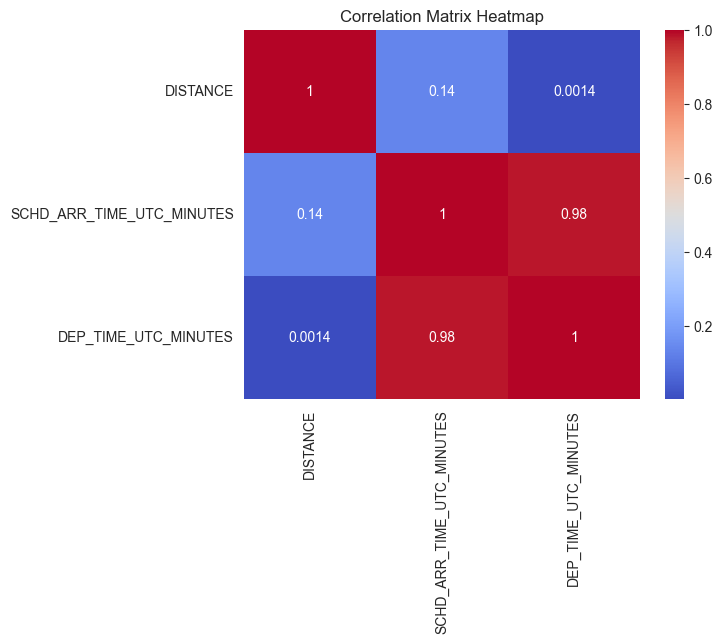

In [262]:
# Correlation between all the continuous features
corr_matrix = data[['DISTANCE', 'SCHD_ARR_TIME_UTC_MINUTES','DEP_TIME_UTC_MINUTES']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

- Transforming the correlated features `SCHD_ARR_TIME_UTC_MINUTES` and `DEP_TIME_UTC_MINUTES` into single feature to eliminate the correlation effect

In [263]:
data['EXPECTED_DURATION']=(data['SCHD_ARR_TIME_UTC_MINUTES']-data['DEP_TIME_UTC_MINUTES'])+1

- to handle cases where the difference is 0 added 1 as a factor. This happens when the departure time is equal to scheduled arrival time when a flight departs at scheduled arrival time which is a scenario of delay

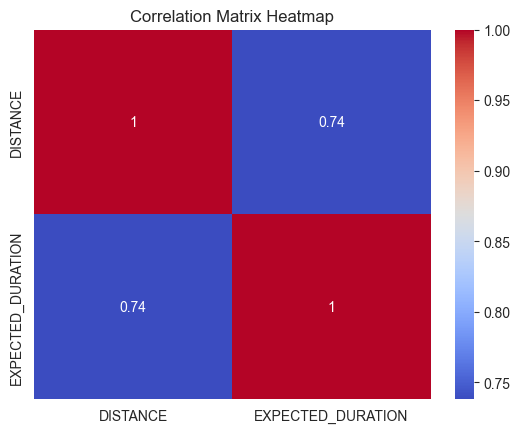

In [264]:
corr_matrix = data[['DISTANCE', 'EXPECTED_DURATION']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

- Created a new feature `EXPECTED_DURATION` because `SCHD_ARR_TIME_UTC_MINUTES` and `DEP_TIME_UTC_MINUTES` are correlated
- These `EXPECTED_DURATION` and `DISTANCE` features even though they have strong correlation, these 2 features should not be merged as both distance and expected duration both are essential to determine if Flight will be delayed or not.
- Speed can be calculated using `EXPECTED_DURATION` and `DISTANCE` features, but that would loose the interpretabilty of the model, as multiple flights can travel at same speed.

In [265]:
# Encoded On-Time and Delay classes
data['ARR_DELAY_CLS'] = data['ARR_DELAY_CLS'].map({'On-Time': 0, 'Delay': 1})

In [266]:
def group_rare_categories_series(series, threshold=0.01):
    '''
    Groups rare categories as others using threshold

    Args:
        series (pd.Series): column to perform binning of rare categories
        threshold (float): threshold to decide if its a rare category or not

    Returns:
        pd.Series: transforms the column data with less percentage than the given threshold
    '''
    # Compute the frequency counts for the series
    counts = series.value_counts(normalize=True)
    # Replace categories that occur less than threshold times with 'Other'
    return series.apply(lambda x: x if counts[x] >= threshold else 'Other')

data['NEW_ORIGIN'] = group_rare_categories_series(data['ORIGIN'], threshold=0.01)
data['NEW_DEST'] = group_rare_categories_series(data['DEST'], threshold=0.01)

`NEW_ORIGIN` and `NEW_DEST` are new features from `ORIGIN` and `DEST` . These features are engineered to create total 8 new categories. Based on frequency of ORIGIN and DESTINATION, top 7 categories are kept as it is, and remaining other categories are grouped together as one category 'OTHERS'.

In [267]:
#  converting categorical to category type
categorical_cols = ['MONTH', 'DAY_OF_WEEK','DAY_OF_MONTH','UNIQUE_CARRIER','NEW_ORIGIN', 'NEW_DEST', 'ORIGIN_CITY_TIME_ZONE', 'DEST_CITY_TIME_ZONE']
for col in categorical_cols:
    data[col] = data[col].astype('category')

In [268]:
X = data.loc[:, ~data.columns.isin(['ARR_DELAY_CLS', 'YEAR', 'QUARTER', 'FL_DATE', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR','DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEP_TIME', 'ARR_TIME',
       'ARR_DELAY', 'AIR_TIME','DISTANCE_GROUP','ARR_TIME_FORMAT_FLG', 'DEP_TIME_FORMAT_FLG', 'ARR_TIME_FRMT', 'DEP_TIME_FRMT', 'ARR_TIME_UTC', 'DEP_TIME_UTC', 'ARR_TIME_UTC_MINUTES', 'UTC_TIME_DIFFERENCE', 'DISTANCE_GROUP_CHK_FLG',
       'SCHD_ARR_TIME_FRMT', 'SCHD_ARR_UTC','DEPT_UTC_HR', 'SCHD_ARR_UTC_HR', 'ORIGIN', 'DEST', 'DEP_TIME_UTC_MINUTES'])]
y = data['ARR_DELAY_CLS']

In [269]:
X.columns

Index(['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER', 'DISTANCE',
       'ORIGIN_CITY_TIME_ZONE', 'DEST_CITY_TIME_ZONE',
       'SCHD_ARR_TIME_UTC_MINUTES', 'EXPECTED_DURATION', 'NEW_ORIGIN',
       'NEW_DEST'],
      dtype='object')

In [270]:
X.head()

MONTH DAY_OF_MONTH DAY_OF_WEEK UNIQUE_CARRIER  DISTANCE  \
0     7           11           2             DL     453.0   
1     3           14           3             DL     946.0   
2    11           12           7             WN     721.0   
3     8           22           2             EV     780.0   
4     3            2           5             DL     425.0   

  ORIGIN_CITY_TIME_ZONE DEST_CITY_TIME_ZONE  SCHD_ARR_TIME_UTC_MINUTES  \
0       America/Chicago    America/New_York                        706   
1      America/New_York    America/New_York                       1485   
2      America/New_York     America/Chicago                       1242   
3      America/New_York    America/New_York                       1067   
4       America/Chicago    America/New_York                        738   

   EXPECTED_DURATION NEW_ORIGIN NEW_DEST  
0                 69      Other      ATL  
1                137        BOS      ATL  
2                118        ATL    Other  
3                110        ATL    Other  
4                 57      Other      ATL

## Hypothesis Testing
- To check if the features are following linear model assumptions or not

In [271]:
numeric_features = ['DISTANCE','EXPECTED_DURATION']
categorical_features = ['MONTH','DAY_OF_WEEK','DAY_OF_MONTH' ,'UNIQUE_CARRIER','ORIGIN_CITY_TIME_ZONE', 'DEST_CITY_TIME_ZONE','NEW_ORIGIN', 'NEW_DEST']

##### Categorical Vs Categorical Features
- Performing Chi-Square to understand the association between categorical and categorical features
    - Null Hypothesis:- Assumes that there is no association between the two variables
    - Alternate Hypothesis:- Assumes that there is an association between the two variables

In [275]:
for i in range(len(categorical_features)):
    for j in range(i + 1, len(categorical_features)):
        cat1 = categorical_features[i]
        cat2 = categorical_features[j]

        # Create contingency table
        contingency_table = pd.crosstab(X[cat1], X[cat2])

        # Run Chi-Square test
        chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

        print(f"Chi-Square between {cat1} and {cat2}:")
        print(f"  chi2 = {chi2:.3f}, p = {p:.3f}, dof = {dof}")
        print("-" * 50)

Chi-Square between MONTH and DAY_OF_WEEK:
  chi2 = 1817.629, p = 0.000, dof = 66
--------------------------------------------------
Chi-Square between MONTH and DAY_OF_MONTH:
  chi2 = 4810.348, p = 0.000, dof = 330
--------------------------------------------------
Chi-Square between MONTH and UNIQUE_CARRIER:
  chi2 = 14838.428, p = 0.000, dof = 165
--------------------------------------------------
Chi-Square between MONTH and ORIGIN_CITY_TIME_ZONE:
  chi2 = 291.356, p = 0.000, dof = 121
--------------------------------------------------
Chi-Square between MONTH and DEST_CITY_TIME_ZONE:
  chi2 = 241.731, p = 0.000, dof = 121
--------------------------------------------------
Chi-Square between MONTH and NEW_ORIGIN:
  chi2 = 230.111, p = 0.000, dof = 77
--------------------------------------------------
Chi-Square between MONTH and NEW_DEST:
  chi2 = 189.513, p = 0.000, dof = 77
--------------------------------------------------
Chi-Square between DAY_OF_WEEK and DAY_OF_MONTH:
  chi2 =

- Based on the above `chi-square` p-value, I have observed that most of the categorical features have some associations except the below features:
  - `DAY_OF_WEEK` and `ORIGIN_CITY_TIME_ZONE`
  - `DAY_OF_MONTH` and `NEW_DEST`
  - `DAY_OF_MONTH` and `NEW_ORIGIN`
  - `DAY_OF_MONTH` and `DEST_CITY_TIME_ZONE`
  - `DAY_OF_MONTH` and `ORIGIN_CITY_TIME_ZONE`
  - `DAY_OF_MONTH` and `UNIQUE_CARRIER`

##### Categorical Vs Continuous

Performing Shapiro Wilk test to understand if the continous variable follow normal distribution with a group
  - Null Hypothesis:- The sample comes from a normal distribution.
  - Alternate Hypothesis:- The sample does not come from a normal distribution.

In [276]:
# Test of Normality
for cat in categorical_features:
  unique_levels = X[cat].dropna().unique()
  all_groups = []
  for level in unique_levels:
    for cont in numeric_features:
      group_data = X[X[cat] == level][cont].dropna()

      # Skip empty groups
      if len(group_data) == 0:
          continue

      # Shapiro–Wilk test
      stat, p_value = stats.shapiro(group_data)
      if p_value > 0.05:
        all_groups.append(group_data)
        print(f"Group = {level} | Categorical Feature = {cat} | Continuous Feature = {cont} | Shapiro–Wilk p-value = {p_value:.5f} | n = {len(group_data)}")



Group = America/Puerto_Rico | Categorical Feature = ORIGIN_CITY_TIME_ZONE | Continuous Feature = DISTANCE | Shapiro–Wilk p-value = 1.00000 | n = 261
Group = Pacific/Honolulu | Categorical Feature = ORIGIN_CITY_TIME_ZONE | Continuous Feature = DISTANCE | Shapiro–Wilk p-value = 1.00000 | n = 61
Group = America/Anchorage | Categorical Feature = ORIGIN_CITY_TIME_ZONE | Continuous Feature = DISTANCE | Shapiro–Wilk p-value = 1.00000 | n = 18
Group = America/Anchorage | Categorical Feature = ORIGIN_CITY_TIME_ZONE | Continuous Feature = EXPECTED_DURATION | Shapiro–Wilk p-value = 0.21283 | n = 18
Group = America/Puerto_Rico | Categorical Feature = DEST_CITY_TIME_ZONE | Continuous Feature = DISTANCE | Shapiro–Wilk p-value = 1.00000 | n = 259
Group = Pacific/Honolulu | Categorical Feature = DEST_CITY_TIME_ZONE | Continuous Feature = DISTANCE | Shapiro–Wilk p-value = 1.00000 | n = 88
Group = America/Anchorage | Categorical Feature = DEST_CITY_TIME_ZONE | Continuous Feature = DISTANCE | Shapiro–Wil

- Based on the observation only the above combinations went through normality test.
- Most of the categorical features fail normality test based on p-value < 0.05 with null hypothesis as each group continuous variable follows normal distribution and alternate hypothesis it does not follow a normal distribution

- So, for test of independency, I am using Kruskal–Wallis for test of independence
  - Null Hypothesis:- Distribution of all groups are equal
  - Alternate Hypothesis:- At least distribution of one group is not equal

In [277]:
for cat_col in categorical_features:
    for cont_col in numeric_features:

        # Collect the data for each unique level in the categorical column
        groups = []
        for level in X[cat_col].dropna().unique():
            group_data = X.loc[X[cat_col] == level, cont_col].dropna()
            if len(group_data) > 0:
                groups.append(group_data)

        # If fewer than 2 groups have data, skip
        if len(groups) < 2:
            continue

        # Perform Kruskal–Wallis test
        stat, p_value = stats.kruskal(*groups)

        print(f"Kruskal–Wallis between {cat_col} and {cont_col}:")
        print(f"  H-statistic = {stat:.3f}, p-value = {p_value:.3e}")
        print("-" * 50)

Kruskal–Wallis between MONTH and DISTANCE:
  H-statistic = 240.223, p-value = 3.104e-45
--------------------------------------------------
Kruskal–Wallis between MONTH and EXPECTED_DURATION:
  H-statistic = 958.859, p-value = 1.365e-198
--------------------------------------------------
Kruskal–Wallis between DAY_OF_WEEK and DISTANCE:
  H-statistic = 48.078, p-value = 1.140e-08
--------------------------------------------------
Kruskal–Wallis between DAY_OF_WEEK and EXPECTED_DURATION:
  H-statistic = 148.327, p-value = 1.747e-29
--------------------------------------------------
Kruskal–Wallis between DAY_OF_MONTH and DISTANCE:
  H-statistic = 32.440, p-value = 3.473e-01
--------------------------------------------------
Kruskal–Wallis between DAY_OF_MONTH and EXPECTED_DURATION:
  H-statistic = 419.782, p-value = 2.773e-70
--------------------------------------------------
Kruskal–Wallis between UNIQUE_CARRIER and DISTANCE:
  H-statistic = 15166.107, p-value = 0.000e+00
---------------

- Based on the above `Kruskal-Wallis` test, I have observed that at least one category’s distribution differs significantly from the others for the corresponding continuous variable as p-value is less than 0.05
- This proves that atleast one group is dependent on the corresponding continous variable

# Model Implementation

I will be using 3 models for classifying whether a flight will be on-time or delay. The positive case is Delay (1) and Negative case is On-Time(0)
  - Logistic Regression
  - Random Forest
  - XGBoost


#### Train and Test Split

- Considering `MONTH`, `DAY_OF_WEEK` and `DAY_OF_MONTH` as ordinal features

In [278]:
model_numeric_features = ['DISTANCE','EXPECTED_DURATION']
model_ordinal_features = ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK'] #Features with ordinal characterstics
model_categorical_features = ['UNIQUE_CARRIER','ORIGIN_CITY_TIME_ZONE', 'DEST_CITY_TIME_ZONE','NEW_ORIGIN', 'NEW_DEST']# Features where one-hot encoding is required

In [279]:
#  performed train and test split with test size of 20% with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y,shuffle=True)

In [280]:
X_train.columns

Index(['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER', 'DISTANCE',
       'ORIGIN_CITY_TIME_ZONE', 'DEST_CITY_TIME_ZONE',
       'SCHD_ARR_TIME_UTC_MINUTES', 'EXPECTED_DURATION', 'NEW_ORIGIN',
       'NEW_DEST'],
      dtype='object')

In [281]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117787 entries, 82370 to 1889
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   MONTH                      117787 non-null  category
 1   DAY_OF_MONTH               117787 non-null  category
 2   DAY_OF_WEEK                117787 non-null  category
 3   UNIQUE_CARRIER             117787 non-null  category
 4   DISTANCE                   117787 non-null  float64 
 5   ORIGIN_CITY_TIME_ZONE      117787 non-null  category
 6   DEST_CITY_TIME_ZONE        117787 non-null  category
 7   SCHD_ARR_TIME_UTC_MINUTES  117787 non-null  int64   
 8   EXPECTED_DURATION          117787 non-null  int64   
 9   NEW_ORIGIN                 117787 non-null  category
 10  NEW_DEST                   117787 non-null  category
dtypes: category(8), float64(1), int64(2)
memory usage: 4.5 MB


In [282]:
# created column transformer to perform onehot encoding on categorial features and scaling numerical features using MinMax scaler
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(), model_ordinal_features),
        ('cat', OneHotEncoder(), model_categorical_features),
        ('num',MinMaxScaler(),model_numeric_features),
    ]
)

In [283]:
def get_model_pipeline(classifier_model,preprocessor):
    """ Function to create scikit-learn pipeline

    Args:
        classifier_model: model
        preprocessor: preprocessor pipeline

    Returns:
        pipeline: pipeline with preprocessor and model steps
    """
    pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # ('hybrid_fs', hybrid_fs),
    ('classifier',classifier_model)])
    return pipeline

In [284]:
#  calculating scale_pos_weight for xgboost
on_time_cls = np.sum(y_train == 0)
delay_cls = np.sum(y_train == 1)
scale_pos_weight = on_time_cls / delay_cls

In [285]:
#  dictionary with model name and model
models = {
    'Logistic Regression': LogisticRegression(random_state=42,class_weight='balanced',penalty='l2'), #using L2 penalty to handle multicollinearity
    'Random Forest': RandomForestClassifier(random_state=42,class_weight='balanced'),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42,scale_pos_weight=scale_pos_weight, enable_categorical=False)
}

### Baseline Model implementation and Results

In [286]:
#  to store base results of all models trained
model_output = {}

Logistic Regression Results:
              precision    recall  f1-score   support

     On-Time       0.91      0.86      0.88     20555
       Delay       0.71      0.79      0.75      8892

    accuracy                           0.84     29447
   macro avg       0.81      0.83      0.82     29447
weighted avg       0.85      0.84      0.84     29447



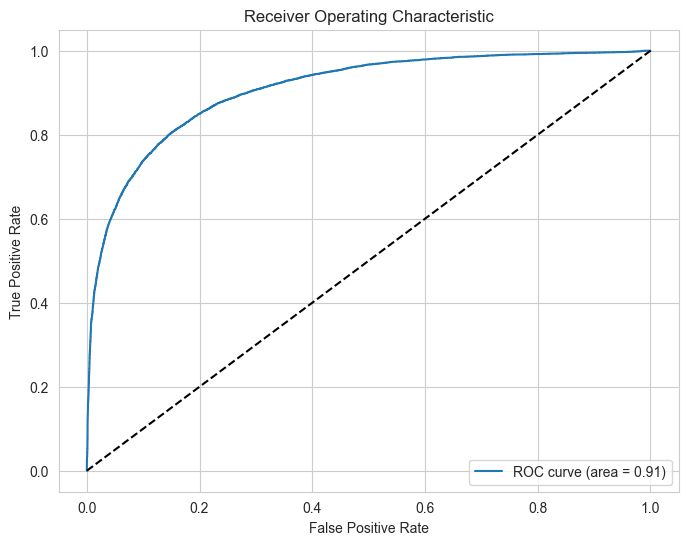

Average Precision Score: 0.8355255224375966


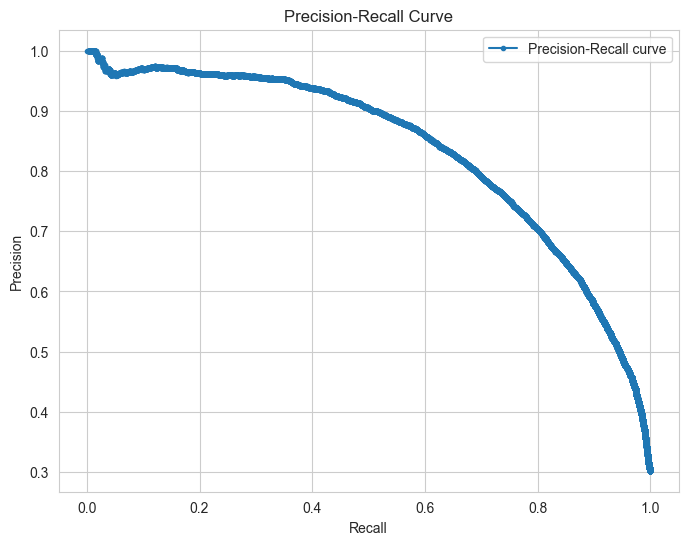

Random Forest Results:
              precision    recall  f1-score   support

     On-Time       0.92      0.96      0.94     20555
       Delay       0.90      0.82      0.86      8892

    accuracy                           0.92     29447
   macro avg       0.91      0.89      0.90     29447
weighted avg       0.92      0.92      0.92     29447



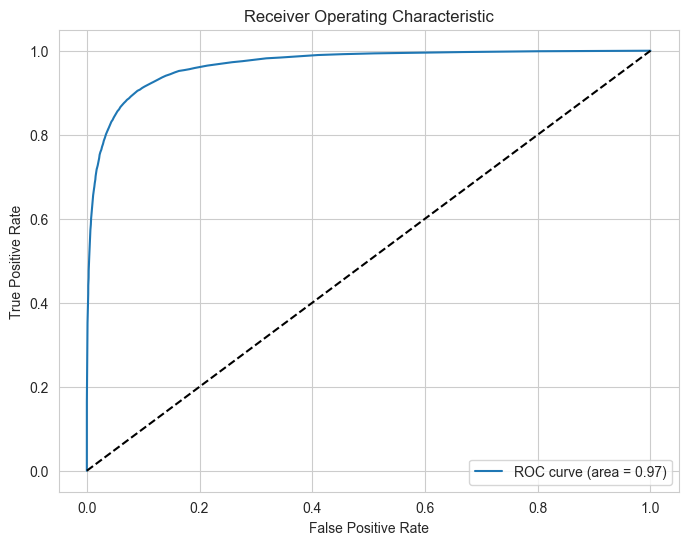

Average Precision Score: 0.9381862656647457


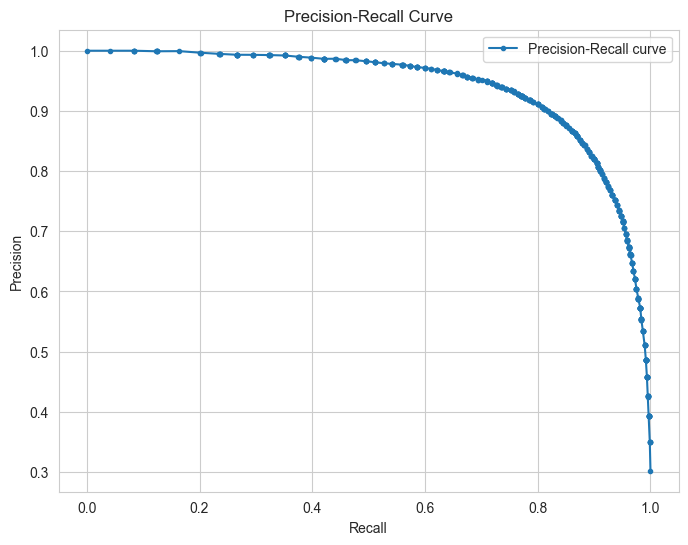

XGBoost Results:
              precision    recall  f1-score   support

     On-Time       0.96      0.92      0.94     20555
       Delay       0.83      0.92      0.87      8892

    accuracy                           0.92     29447
   macro avg       0.90      0.92      0.91     29447
weighted avg       0.92      0.92      0.92     29447



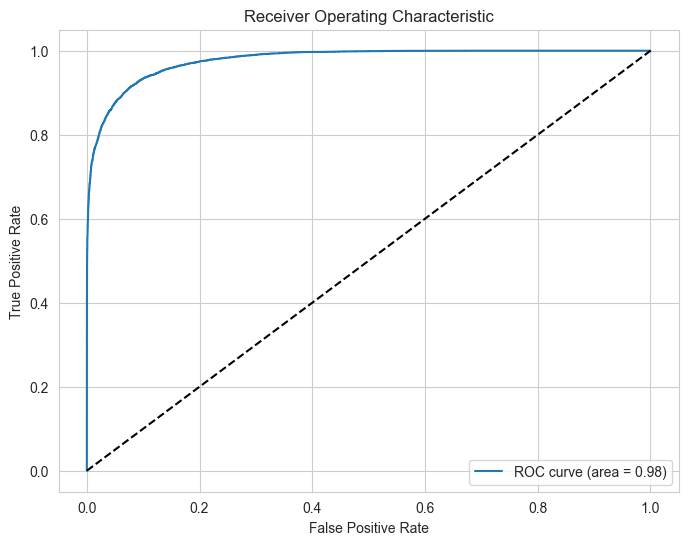

Average Precision Score: 0.9584888168033319


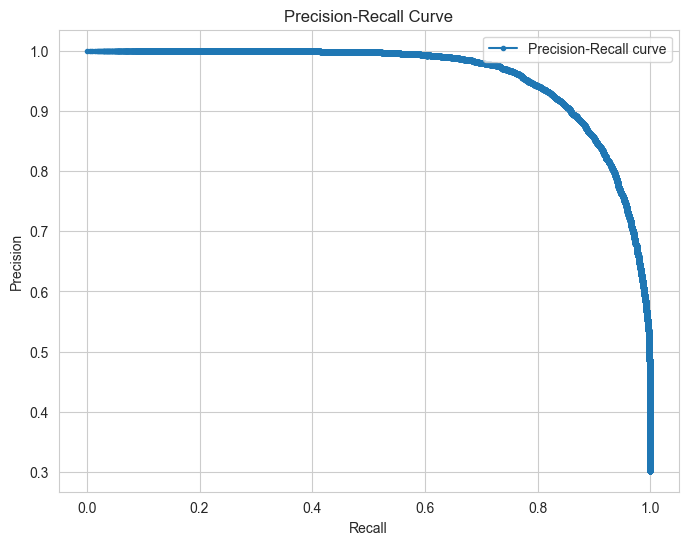

In [287]:
for model_name, model in models.items():
    model_output[model_name]={}
    print(f'{model_name} Results:')
    pipeline = get_model_pipeline(model,preprocessor) # custom function get_model_pipeline to generate pipeline
    pipeline.fit(X_train,y_train) # Training the pipeline on training data
    y_pred = pipeline.predict(X_test) # Predict the labels for test set
    print(classification_report(y_test, y_pred, target_names=["On-Time","Delay"]))
    y_proba = pipeline.predict_proba(X_test)[:, 1] # probability estimates for the positive class from the pipelin
    fpr, tpr, thresholds = roc_curve(y_test, y_proba) # ROC curve by comparing the true labels to the predicted probabilities
    roc_auc = auc(fpr, tpr)
    #  Storing the pipeline, predictions, and metrics to the model_output dictionary
    model_output[model_name]['Pipeline'] = pipeline
    model_output[model_name]['y_pred'] = y_pred
    model_output[model_name]['Classification_report'] = classification_report(y_test, y_pred, target_names=[ "On-Time","Delay"])
    model_output[model_name]['predicted_proba'] = y_proba
    model_output[model_name]['FPR'] = fpr
    model_output[model_name]['TPR'] = tpr
    model_output[model_name]['ROC_AUC_threshold'] = thresholds
    model_output[model_name]['ROC_AUC'] = roc_auc

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-recall curve using the predicted probabilities
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    model_output[model_name]['Precision'] = precision
    model_output[model_name]['Recall'] = recall
    model_output[model_name]['PR_Threshold'] = thresholds

    # Calculate the average precision score
    avg_precision = average_precision_score(y_test, y_proba)

    model_output[model_name]['AvgPrecision'] = avg_precision
    print("Average Precision Score:", avg_precision)

    # Plot the precision-recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

## Baseline Model Interpretability

##### Logistic Regression

In [288]:
print(model_output['Logistic Regression']['Classification_report'])

              precision    recall  f1-score   support

     On-Time       0.91      0.86      0.88     20555
       Delay       0.71      0.79      0.75      8892

    accuracy                           0.84     29447
   macro avg       0.81      0.83      0.82     29447
weighted avg       0.85      0.84      0.84     29447



- Based on the classification matrix of logistic regression the model classifies about 84% of the flights whether they will be On-Time or Delay
- The model predicts delay correctly 71% of the time
- The model is able to identify 79% of the flights that are actually delayed correctly.

In [289]:
log_reg = model_output['Logistic Regression']['Pipeline'].named_steps['classifier']
coefficients = log_reg.coef_[0]
feature_names = model_output['Logistic Regression']['Pipeline'].named_steps['preprocessor'].get_feature_names_out()
indices = np.argsort(np.abs(coefficients))[::-1]
sorted_features = [(feature_names[i], coefficients[i]) for i in indices]
sorted_coefs = coefficients[indices]

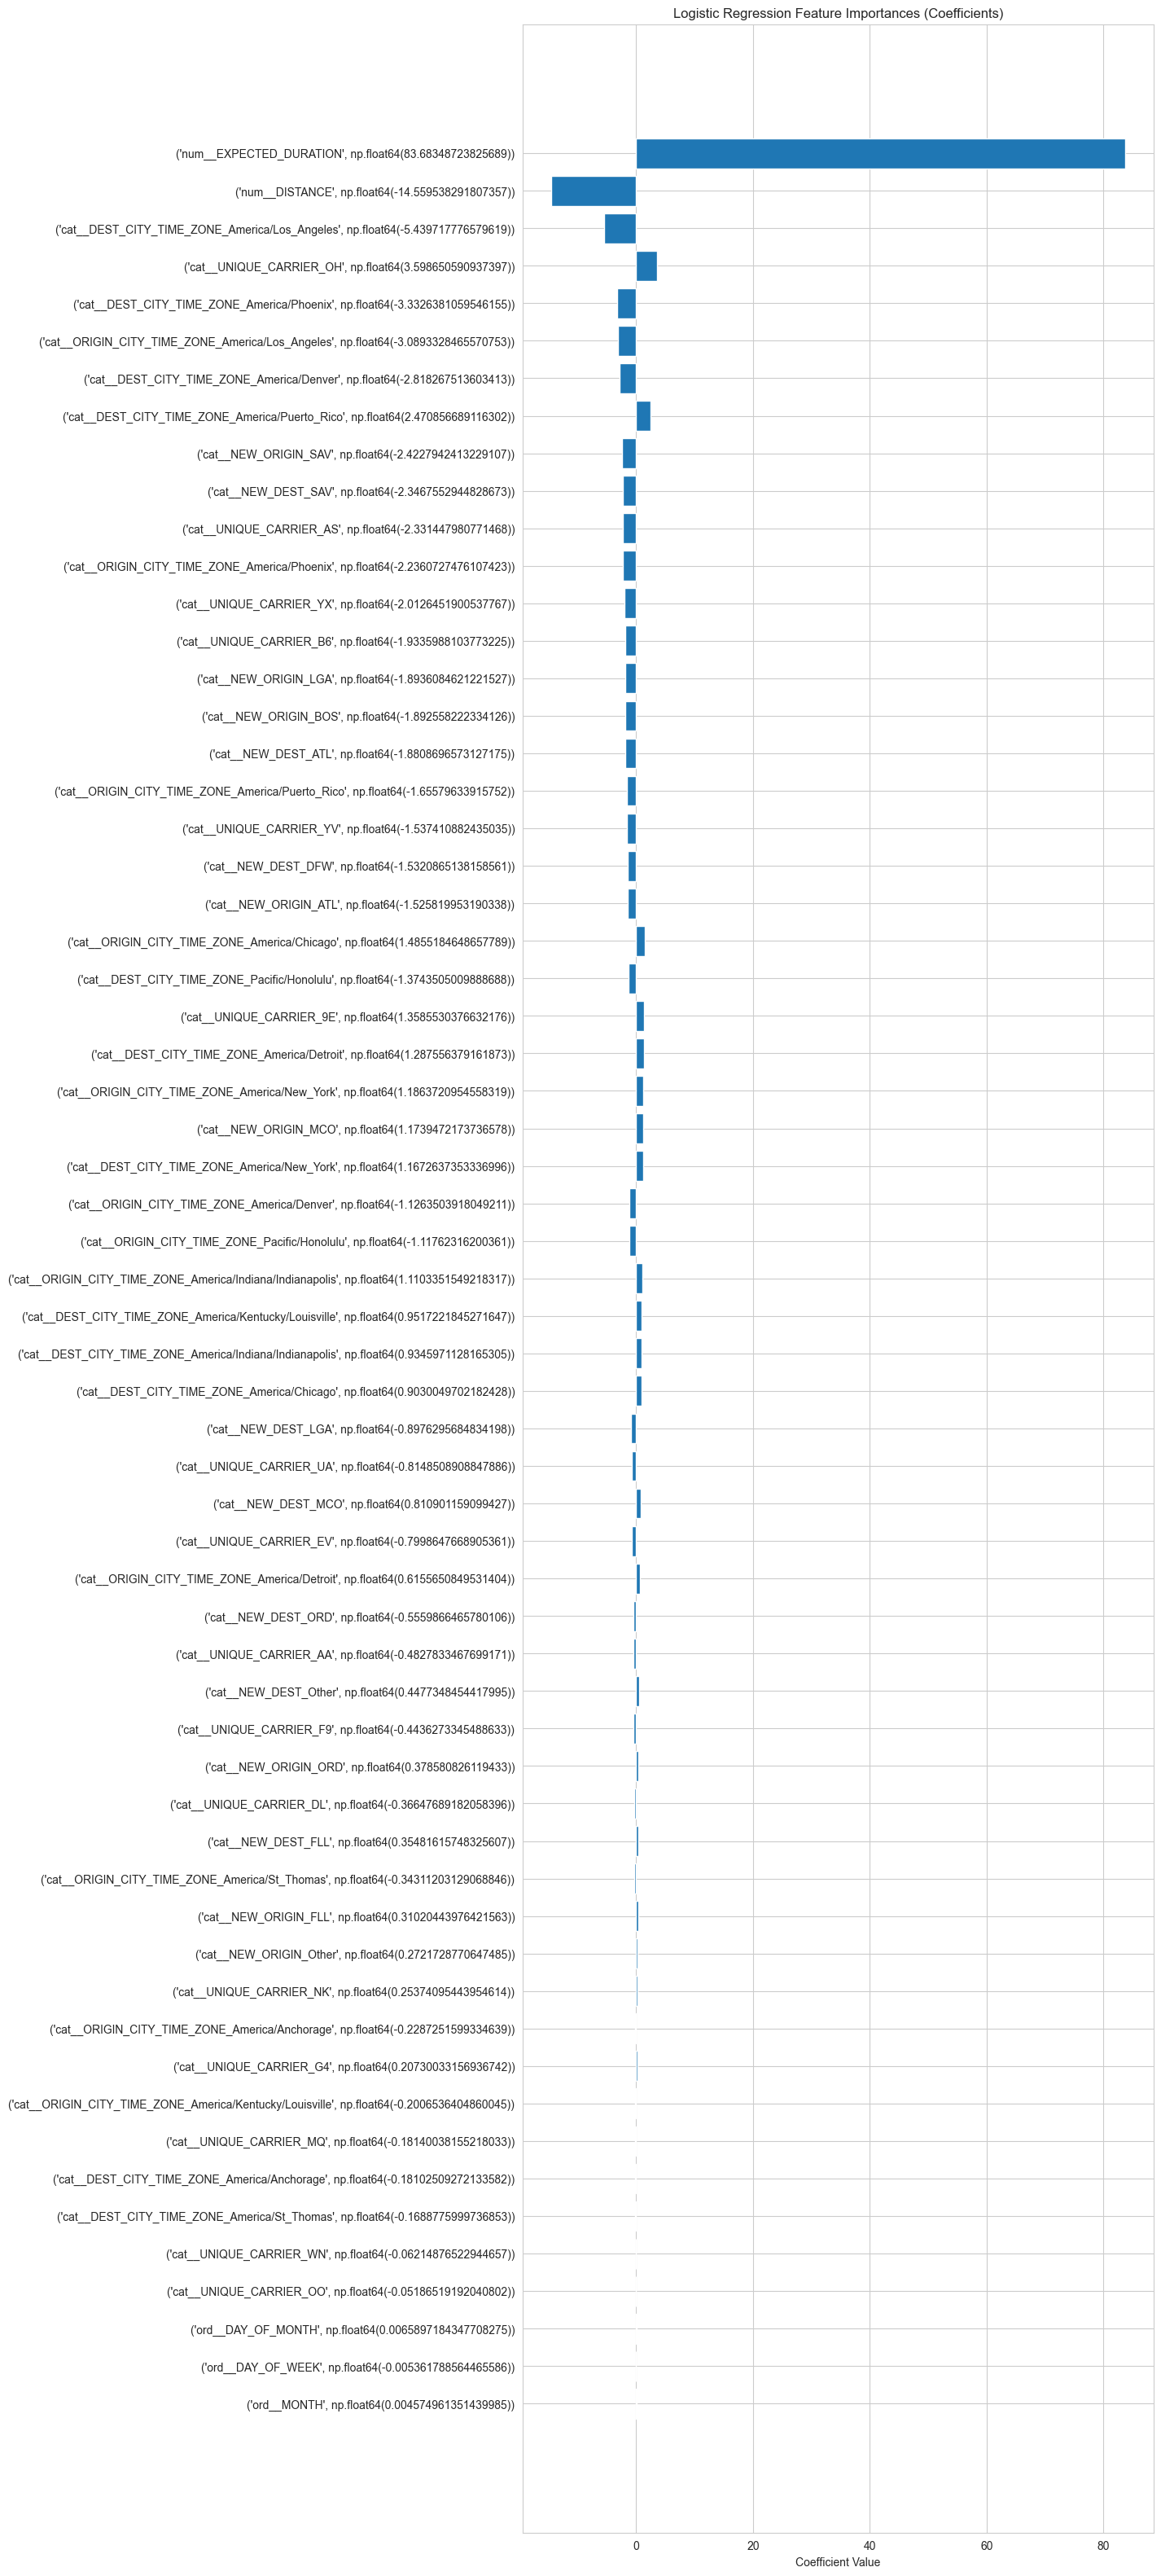

In [290]:
plt.figure(figsize=(10, 40))
plt.barh(range(len(sorted_coefs)), sorted_coefs, align='center')
plt.yticks(range(len(sorted_coefs)), sorted_features)
plt.xlabel("Coefficient Value")
plt.title("Logistic Regression Feature Importances (Coefficients)")
plt.gca().invert_yaxis()
plt.show()

#### Random Forest

In [291]:
print(model_output['Random Forest']['Classification_report'])

              precision    recall  f1-score   support

     On-Time       0.92      0.96      0.94     20555
       Delay       0.90      0.82      0.86      8892

    accuracy                           0.92     29447
   macro avg       0.91      0.89      0.90     29447
weighted avg       0.92      0.92      0.92     29447



- Based on the classification matrix of Random Forest the model classifies about 92% of the flights whether they will be On-Time or Delay
- Model predictes delay 90% of the times correctly
- Model is able to identify 82% of flights that are actually delayed correctly

In [317]:
rf_model = model_output['Random Forest']['Pipeline'].named_steps['classifier']
importances_rf = rf_model.feature_importances_
feature_names_rf = model_output['Random Forest']['Pipeline'].named_steps['preprocessor'].get_feature_names_out()
indices_rf = np.argsort(importances_rf)[::-1]
sorted_features_rf = [(feature_names_rf[i], importances_rf[i]) for i in indices_rf]

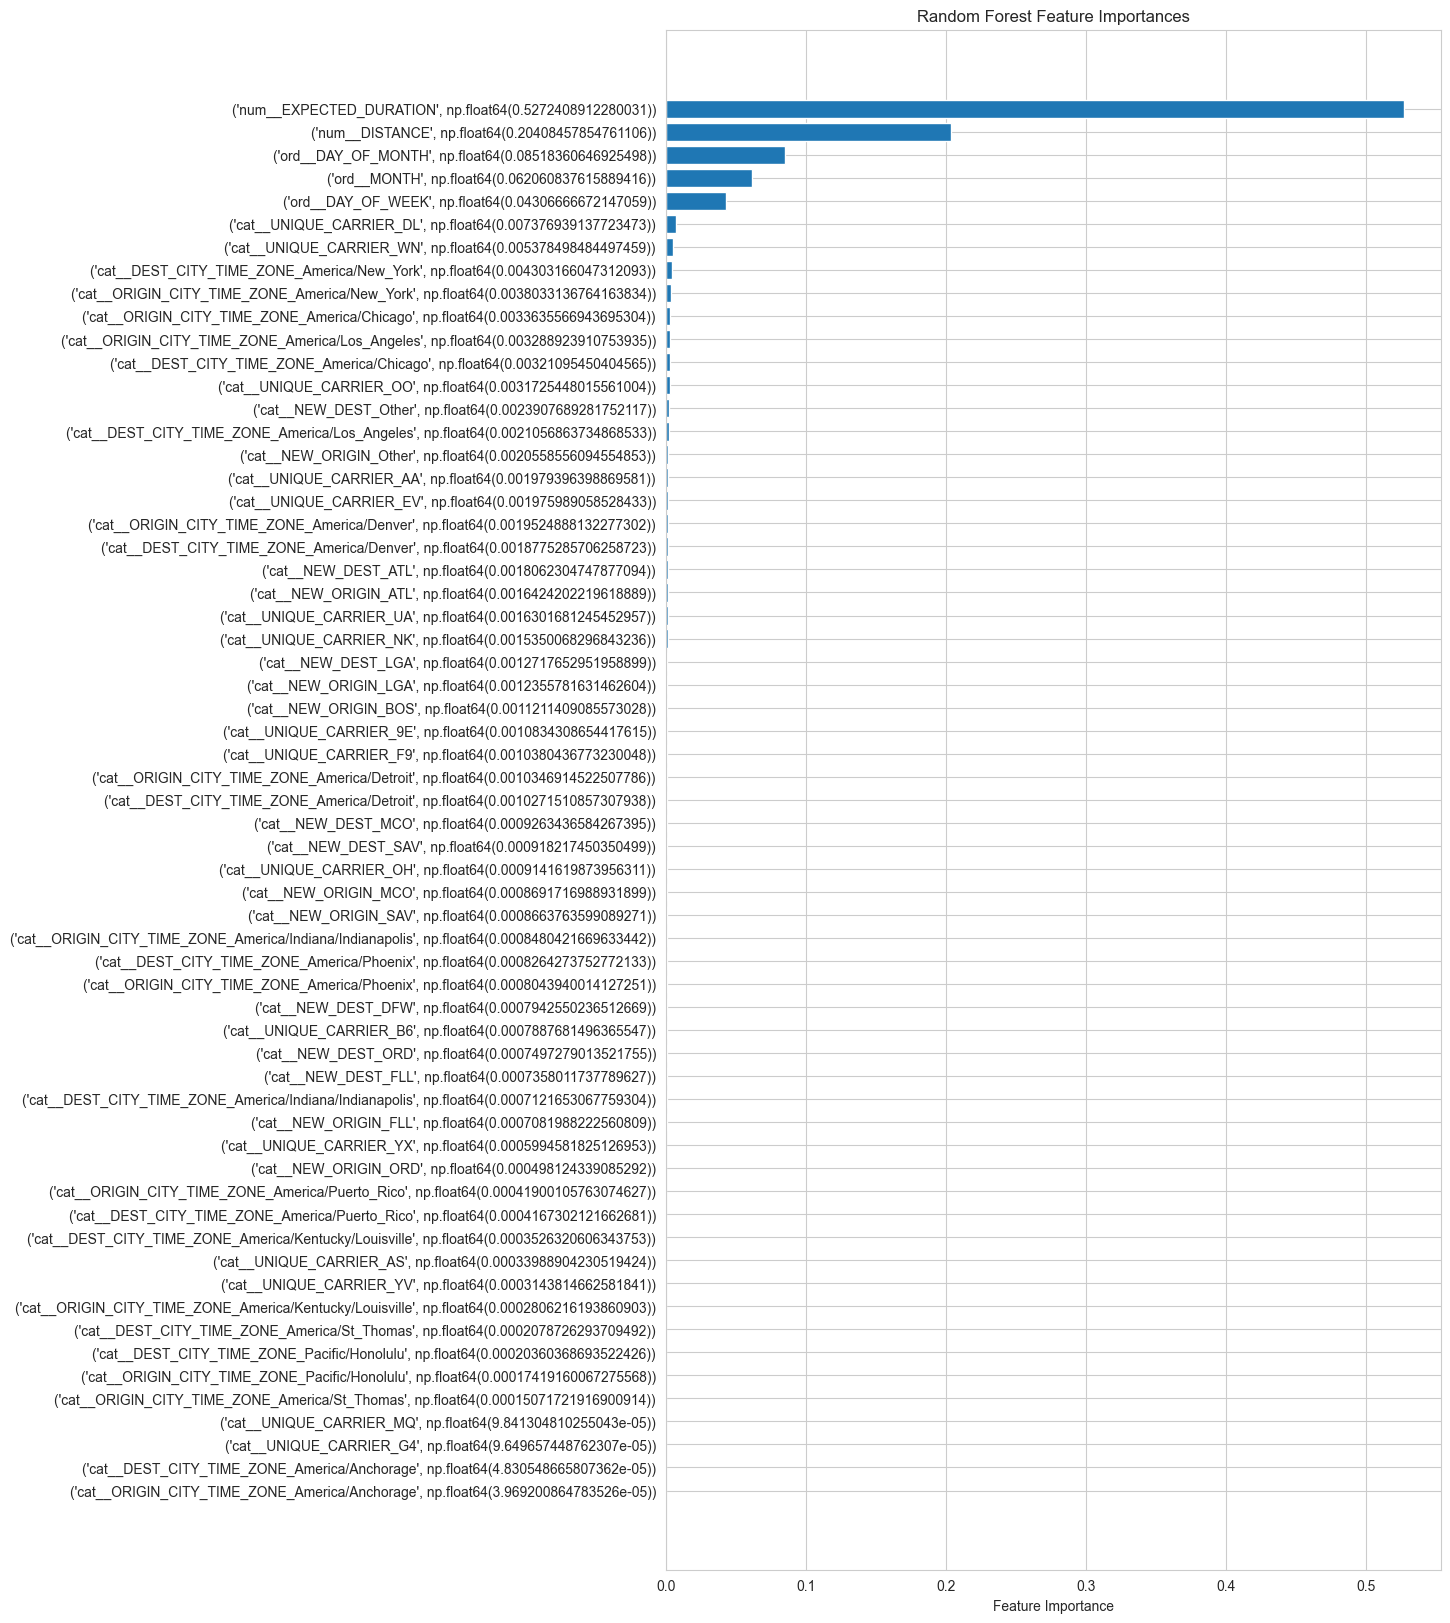

In [318]:
sorted_importances_rf = importances_rf[indices_rf]
plt.figure(figsize=(10, 20))
plt.barh(range(len(sorted_importances_rf)), sorted_importances_rf, align='center')
plt.yticks(range(len(sorted_importances_rf)), sorted_features_rf)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.show()

#### Xgboost

In [314]:
print(model_output['XGBoost']['Classification_report'])

              precision    recall  f1-score   support

     On-Time       0.96      0.92      0.94     20555
       Delay       0.83      0.92      0.87      8892

    accuracy                           0.92     29447
   macro avg       0.90      0.92      0.91     29447
weighted avg       0.92      0.92      0.92     29447



- Based on the classification matrix of XGBoost the model classifies about 92% of the flights whether they will be On-Time or Delay
- Model predictes delay 83% of the times correctly
- Model is able to identify 92% of flights that are actually delayed correctly

In [315]:
xgb_model = model_output['XGBoost']['Pipeline'].named_steps['classifier']
importances_xgb = xgb_model.feature_importances_
feature_names_xgb = model_output['XGBoost']['Pipeline'].named_steps['preprocessor'].get_feature_names_out()
indices_xgb = np.argsort(importances_xgb)[::-1]
sorted_features_xgb = [(feature_names_xgb[i], importances_xgb[i]) for i in indices_xgb]

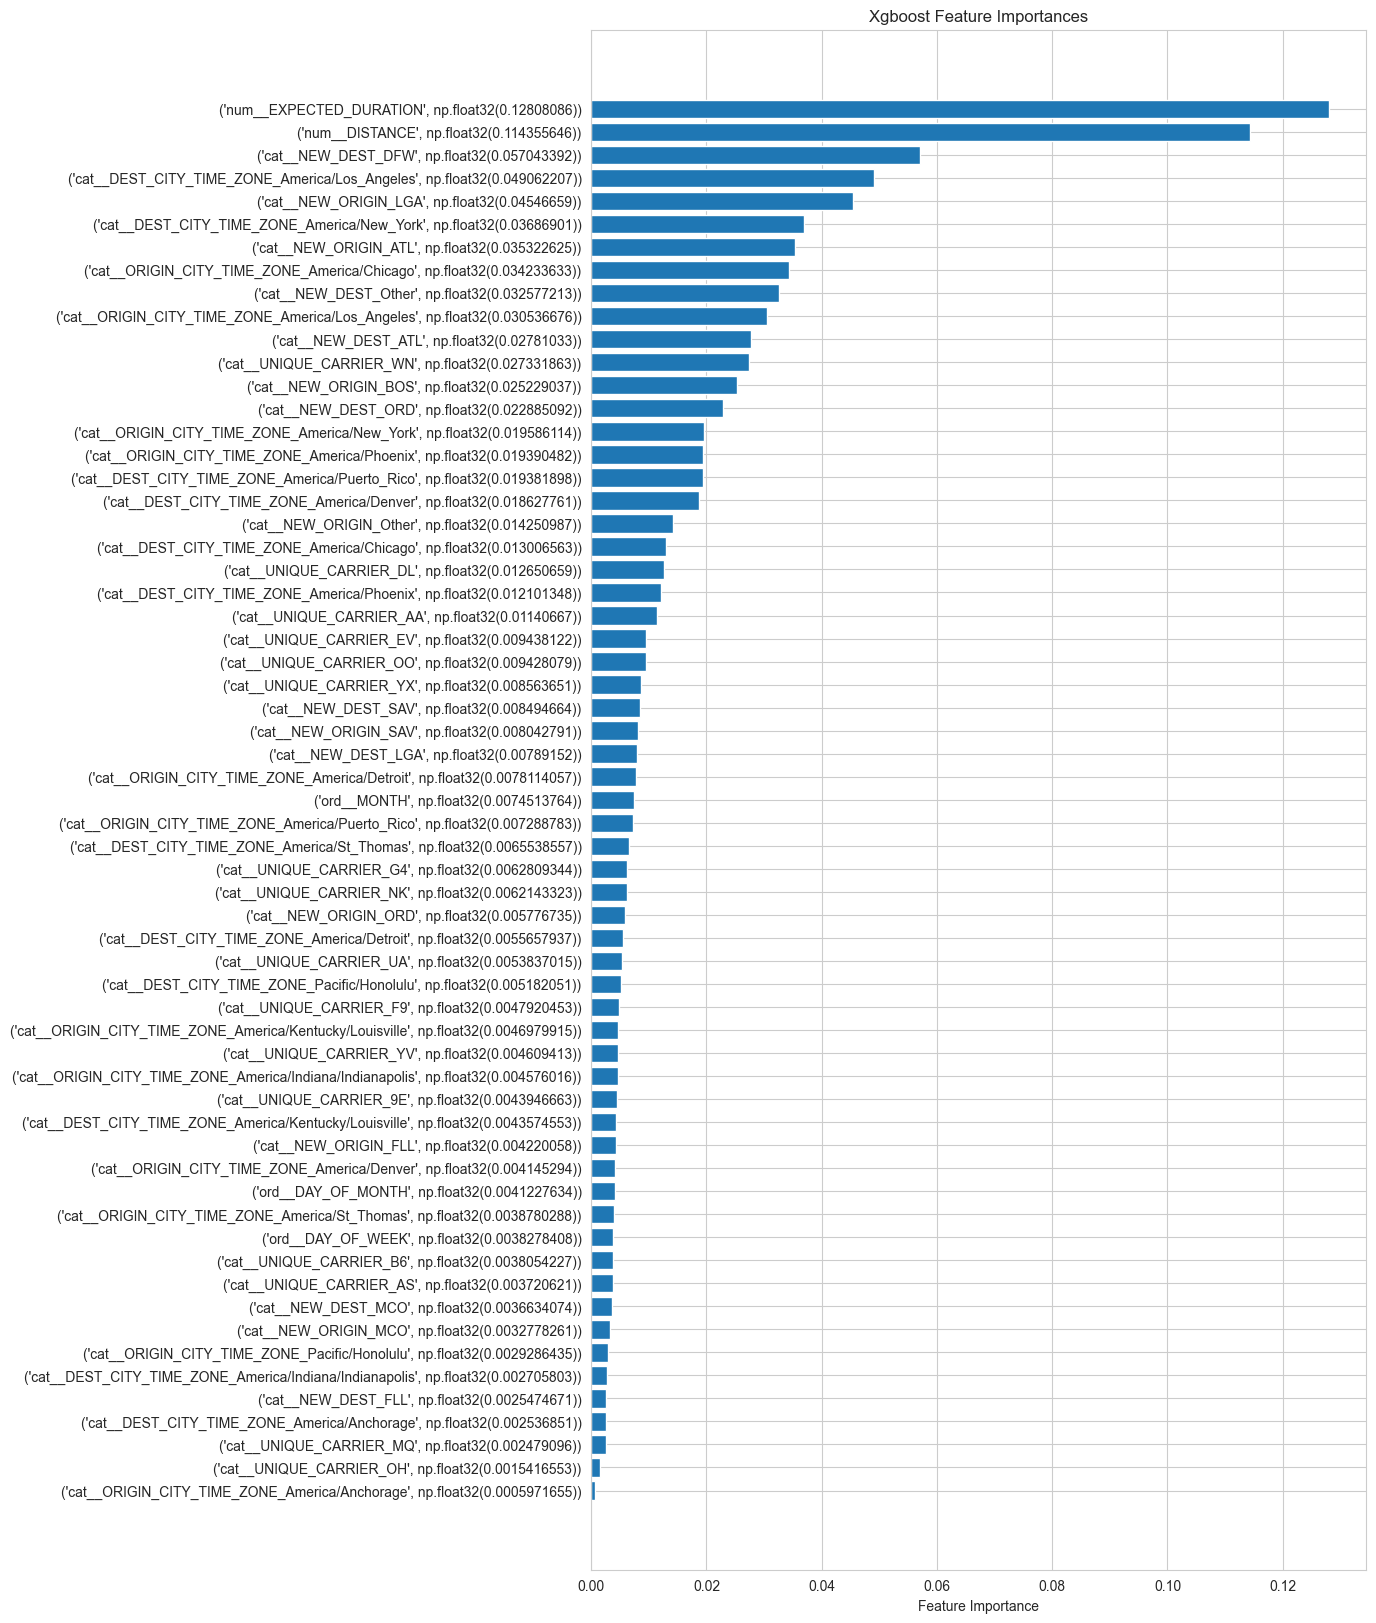

In [316]:
sorted_importances_xgb = importances_xgb[indices_xgb]
plt.figure(figsize=(10, 20))
plt.barh(range(len(sorted_importances_xgb)), sorted_importances_xgb, align='center')
plt.yticks(range(len(sorted_importances_xgb)), sorted_features_xgb)
plt.xlabel("Feature Importance")
plt.title("Xgboost Feature Importances")
plt.gca().invert_yaxis()
plt.show()

- Based on the intial results XGBoost and Random Forest have performed better compared to Logistic Regression.
- XGBoost has outperformed than the other two models.
- We can also infer from the feature importance is that the `EXPECTED_DURATION` and `DISTANCE` are key features in classifying delay or On time.
- To improve the model performance I will be perform Grid Search and Cross validation

## Grid Search Implementation and Results

In [299]:
grid_search_op = {}
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__solver':['liblinear']

    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'classifier__max_depth': [3, 5, 7],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__n_estimators': [100, 200],
        'classifier__subsample': [0.8, 1.0]
    }
}

Logistic Regression Results:
Best Parameters Found:
{'classifier__C': 10, 'classifier__solver': 'liblinear'}

Best Cross-Validation Score: 0.857
              precision    recall  f1-score   support

     On-Time       0.96      0.91      0.93     20555
       Delay       0.82      0.90      0.86      8892

    accuracy                           0.91     29447
   macro avg       0.89      0.91      0.90     29447
weighted avg       0.91      0.91      0.91     29447



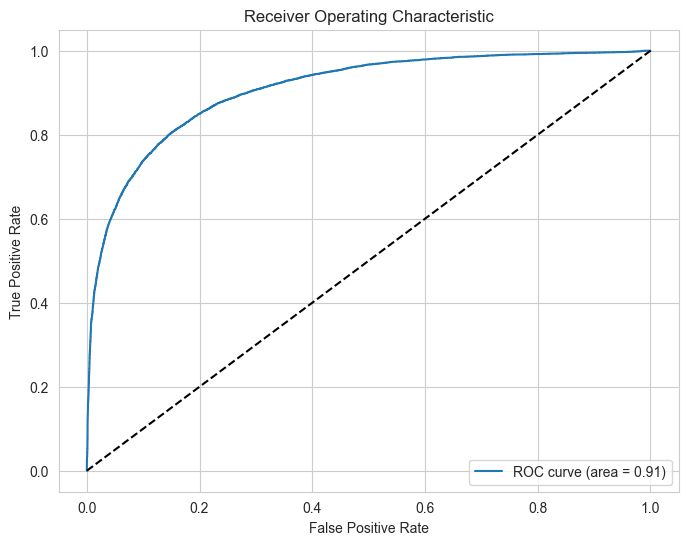

Average Precision Score: 0.8355255224375966


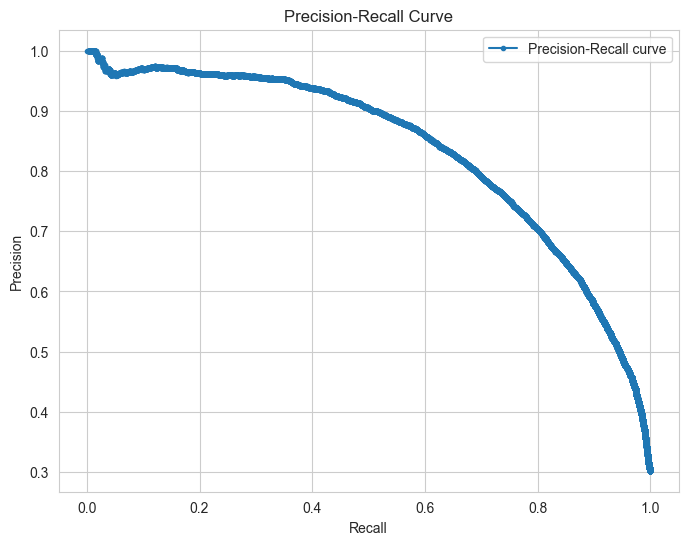

Random Forest Results:
Best Parameters Found:
{'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}

Best Cross-Validation Score: 0.863
              precision    recall  f1-score   support

     On-Time       0.94      0.95      0.94     20555
       Delay       0.88      0.85      0.87      8892

    accuracy                           0.92     29447
   macro avg       0.91      0.90      0.90     29447
weighted avg       0.92      0.92      0.92     29447



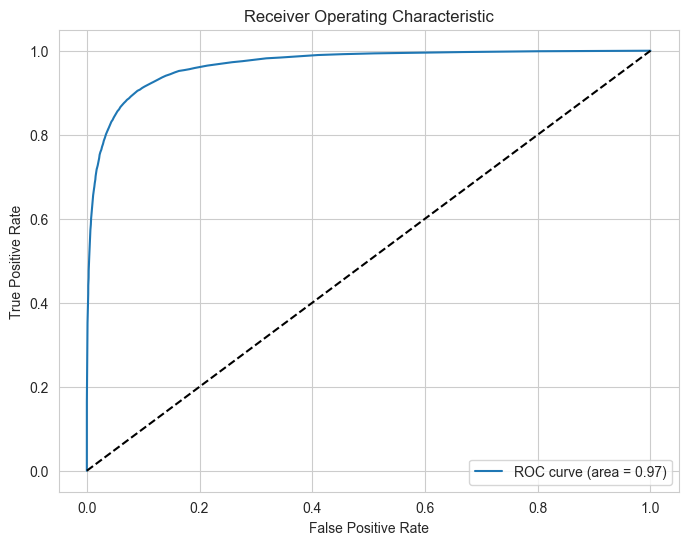

Average Precision Score: 0.9381862656647457


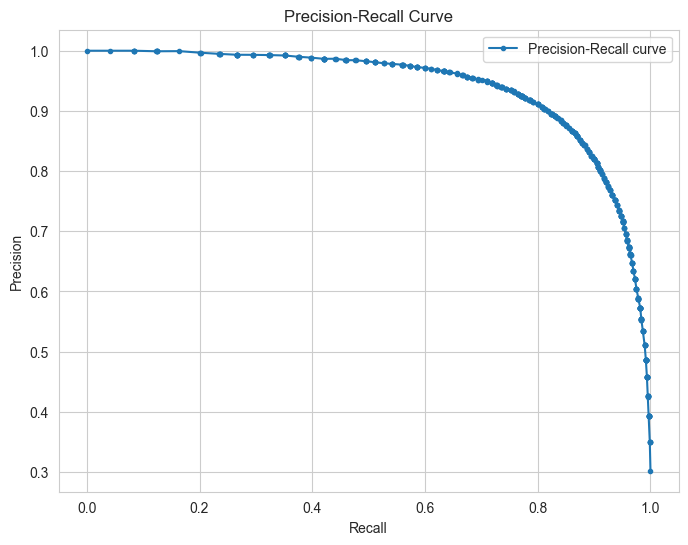

XGBoost Results:
Best Parameters Found:
{'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}

Best Cross-Validation Score: 0.869
              precision    recall  f1-score   support

     On-Time       0.96      0.92      0.94     20555
       Delay       0.83      0.92      0.87      8892

    accuracy                           0.92     29447
   macro avg       0.90      0.92      0.91     29447
weighted avg       0.92      0.92      0.92     29447



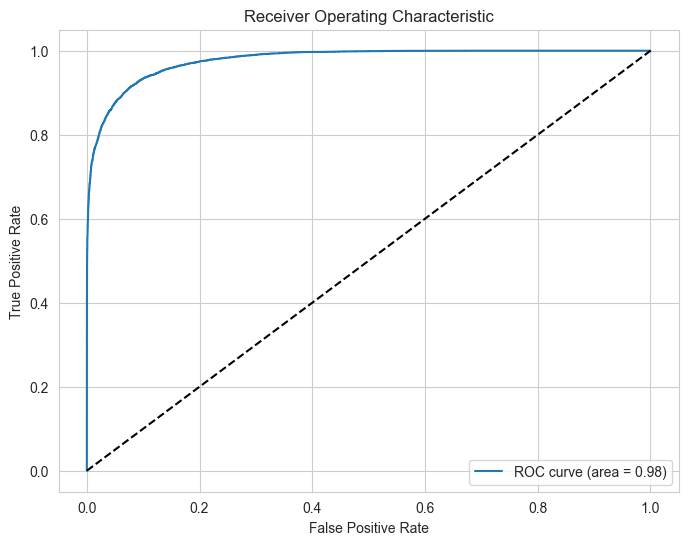

Average Precision Score: 0.9584888168033319


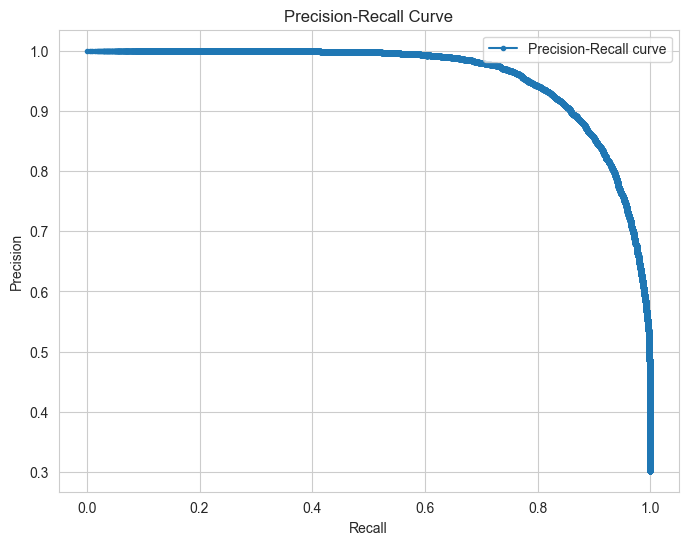

In [300]:
for model_name, model in models.items():
    print(f'{model_name} Results:')
    grid_search_op[model_name]={}
    pipeline = get_model_pipeline(model,preprocessor) # custom function get_model_pipeline to generate pipeline
    grid_search = GridSearchCV(pipeline, param_grids[model_name], scoring='f1', cv=StratifiedKFold(n_splits=5), n_jobs=-1) #GridSearchCV to tune the hyperparameters for the pipeline
    grid_search.fit(X_train, y_train) # Training the pipeline on training data
    print("Best Parameters Found:")
    print(grid_search.best_params_) # best parameters found during grid search
    print("\nBest Cross-Validation Score: {:.3f}".format(grid_search.best_score_)) # best cross-validation F1 score achieved with the best parameters

    y_pred = grid_search.predict(X_test) # Predict the labels for test set
    print(classification_report(y_test, y_pred, target_names=[ "On-Time","Delay"]))

    # Get predicted probabilities for the positive class
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_proba) # ROC curve by comparing the true labels to the predicted probabilities
    roc_auc = auc(fpr, tpr)
    #  Storing the pipeline, predictions, and metrics to the grid_search_op dictionary
    grid_search_op[model_name]['Pipeline'] = pipeline
    grid_search_op[model_name]['y_pred'] = y_pred
    grid_search_op[model_name]['Classification_report'] = classification_report(y_test, y_pred, target_names=[ "On-Time","Delay"])
    grid_search_op[model_name]['predicted_proba'] = y_proba
    grid_search_op[model_name]['FPR'] = fpr
    grid_search_op[model_name]['TPR'] = tpr
    grid_search_op[model_name]['ROC_AUC_threshold'] = thresholds
    grid_search_op[model_name]['ROC_AUC'] = roc_auc

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-recall curve using the predicted probabilities
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    avg_precision = average_precision_score(y_test, y_proba)
    grid_search_op[model_name]['Precision'] = precision
    grid_search_op[model_name]['Recall'] = recall
    grid_search_op[model_name]['PR_Threshold'] = thresholds

    # Calculate the average precision score
    print("Average Precision Score:", avg_precision)
    grid_search_op[model_name]['AvgPrecision'] = avg_precision

    # Plot the precision-recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

####  Grid Search based Model Interpretability

##### Logistic Regression Interpretability

In [301]:
print(grid_search_op['Logistic Regression']['Classification_report'])

              precision    recall  f1-score   support

     On-Time       0.96      0.91      0.93     20555
       Delay       0.82      0.90      0.86      8892

    accuracy                           0.91     29447
   macro avg       0.89      0.91      0.90     29447
weighted avg       0.91      0.91      0.91     29447



- Grid Search based Logistic Regression model performed better than baseline logistic model
- It has significant improvement in F1-Score, Precision and Recall but still Xgboost and Random Forest perform better in terms of all metrics

In [319]:
log_reg = grid_search_op['Logistic Regression']['Pipeline'].named_steps['classifier']
coefficients = log_reg.coef_[0]
feature_names = grid_search_op['Logistic Regression']['Pipeline'].named_steps['preprocessor'].get_feature_names_out()
indices = np.argsort(np.abs(coefficients))[::-1]
sorted_features = [(feature_names[i], coefficients[i]) for i in indices]
sorted_coefs = coefficients[indices]

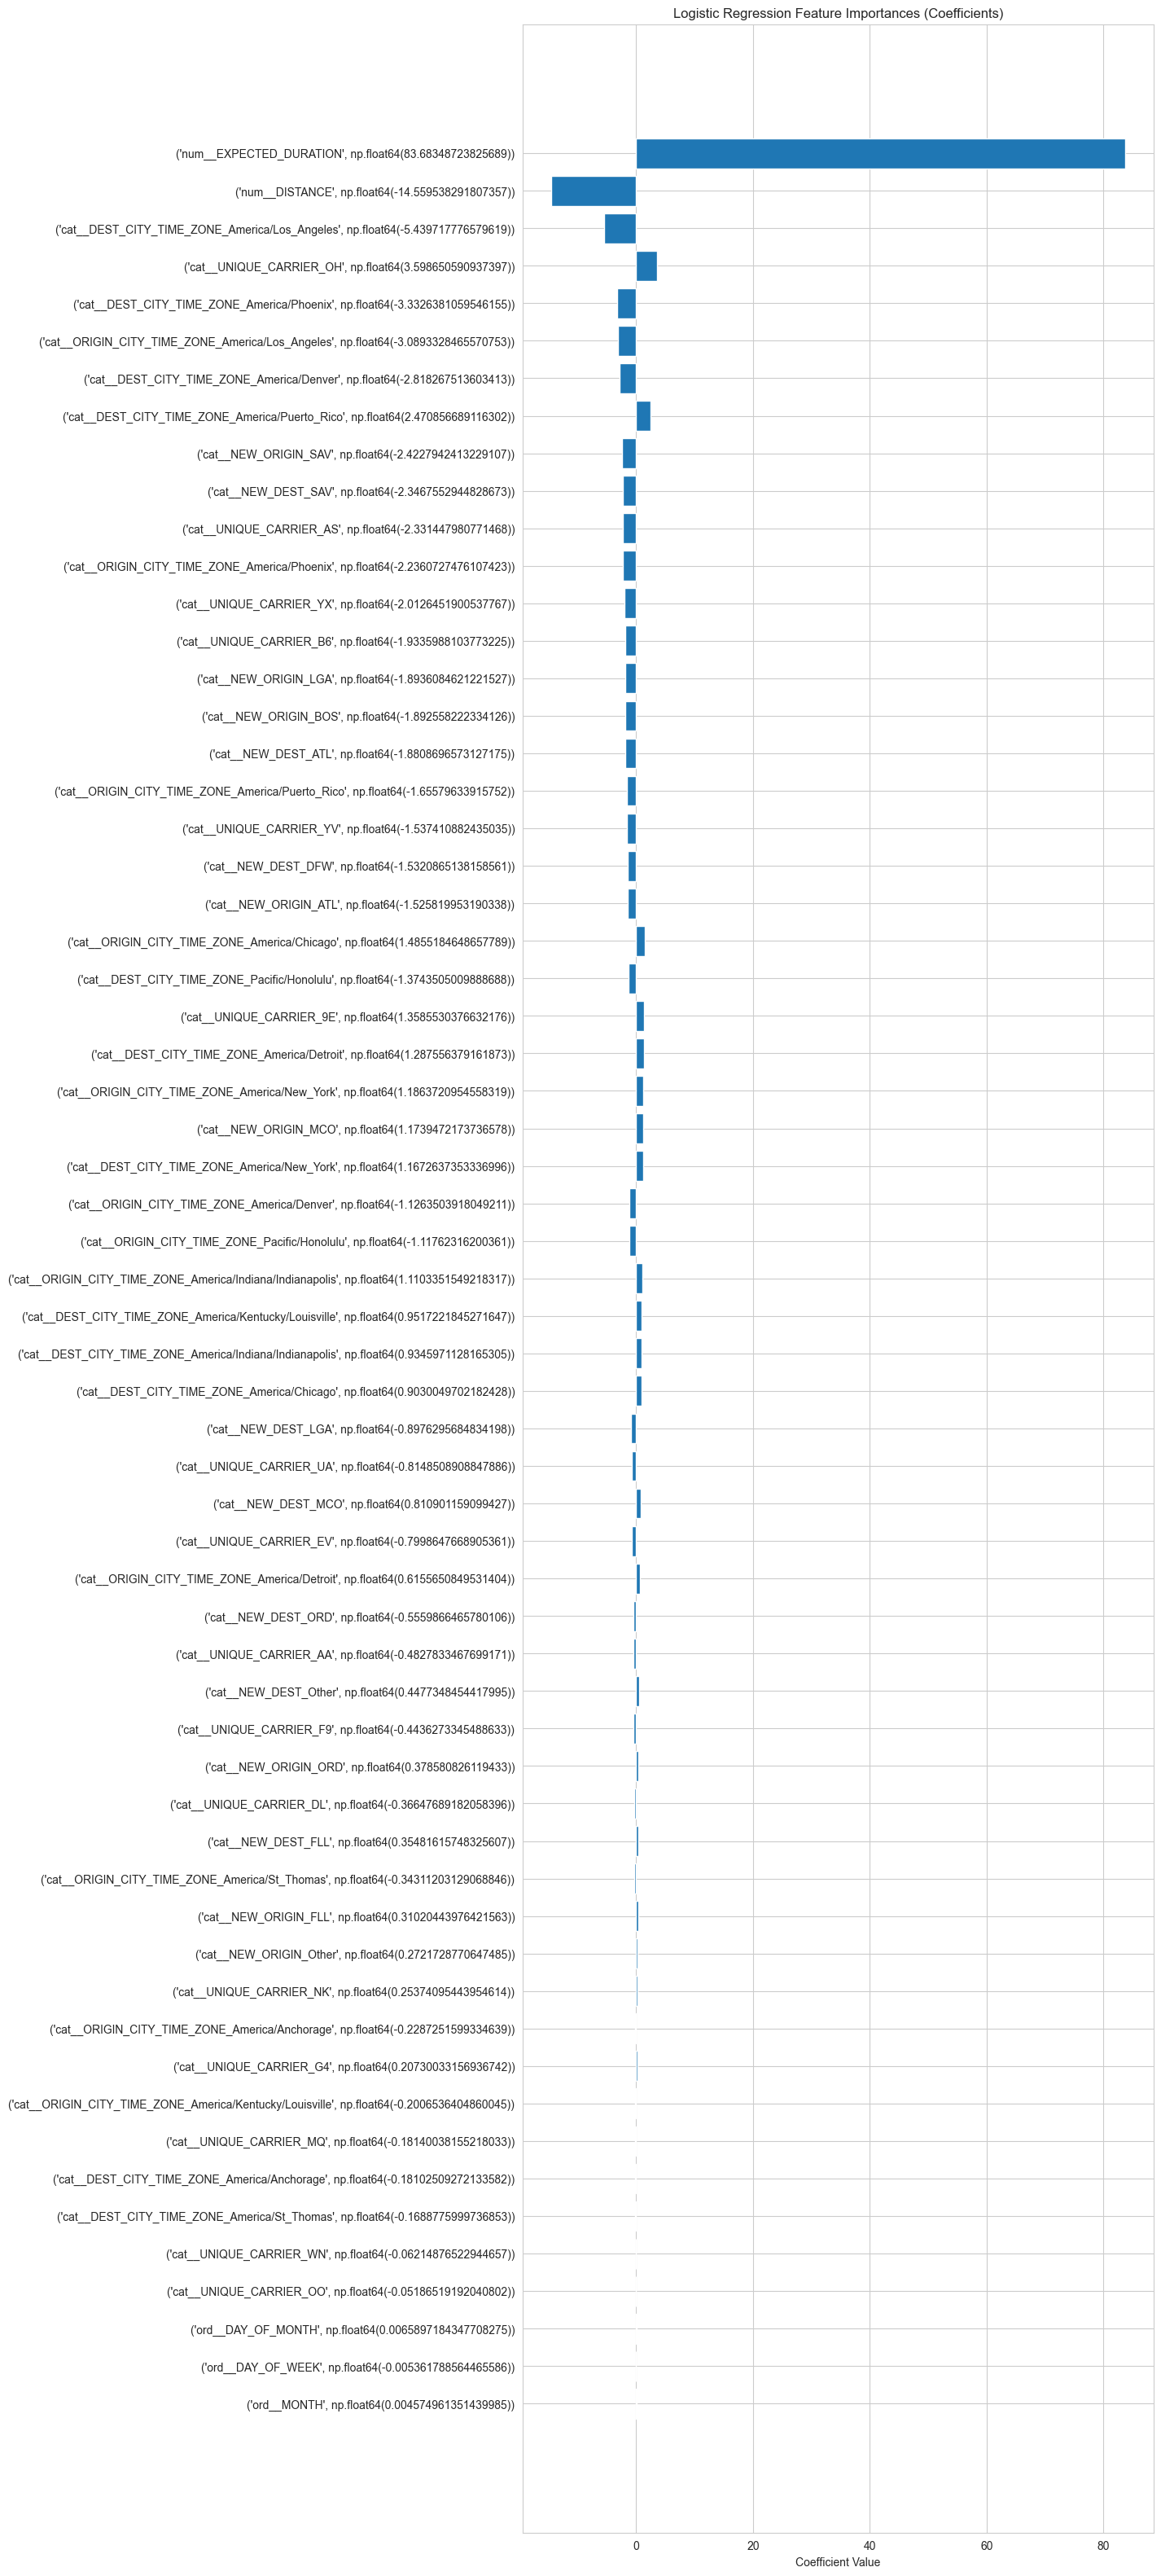

In [320]:
plt.figure(figsize=(10, 40))
plt.barh(range(len(sorted_coefs)), sorted_coefs, align='center')
plt.yticks(range(len(sorted_coefs)), sorted_features)
plt.xlabel("Coefficient Value")
plt.title("Logistic Regression Feature Importances (Coefficients)")
plt.gca().invert_yaxis()
plt.show()

##### Random Forest

In [321]:
print(grid_search_op['Random Forest']['Classification_report'])

              precision    recall  f1-score   support

     On-Time       0.94      0.95      0.94     20555
       Delay       0.88      0.85      0.87      8892

    accuracy                           0.92     29447
   macro avg       0.91      0.90      0.90     29447
weighted avg       0.92      0.92      0.92     29447



- Compared to baseline random forest the precision of On-Time increase by 2% but reduction of 2% in Delay.
- There is increase in recall of delay and 1% reduction in On-Time recall
- Random Forest overall has same accuracy but increase of 1% f1-score for Delay

In [322]:
rf_model = grid_search_op['Random Forest']['Pipeline'].named_steps['classifier']
importances_rf = rf_model.feature_importances_
feature_names_rf = grid_search_op['Random Forest']['Pipeline'].named_steps['preprocessor'].get_feature_names_out()
indices_rf = np.argsort(importances_rf)[::-1]
sorted_features_rf = [(feature_names_rf[i], importances_rf[i]) for i in indices_rf]

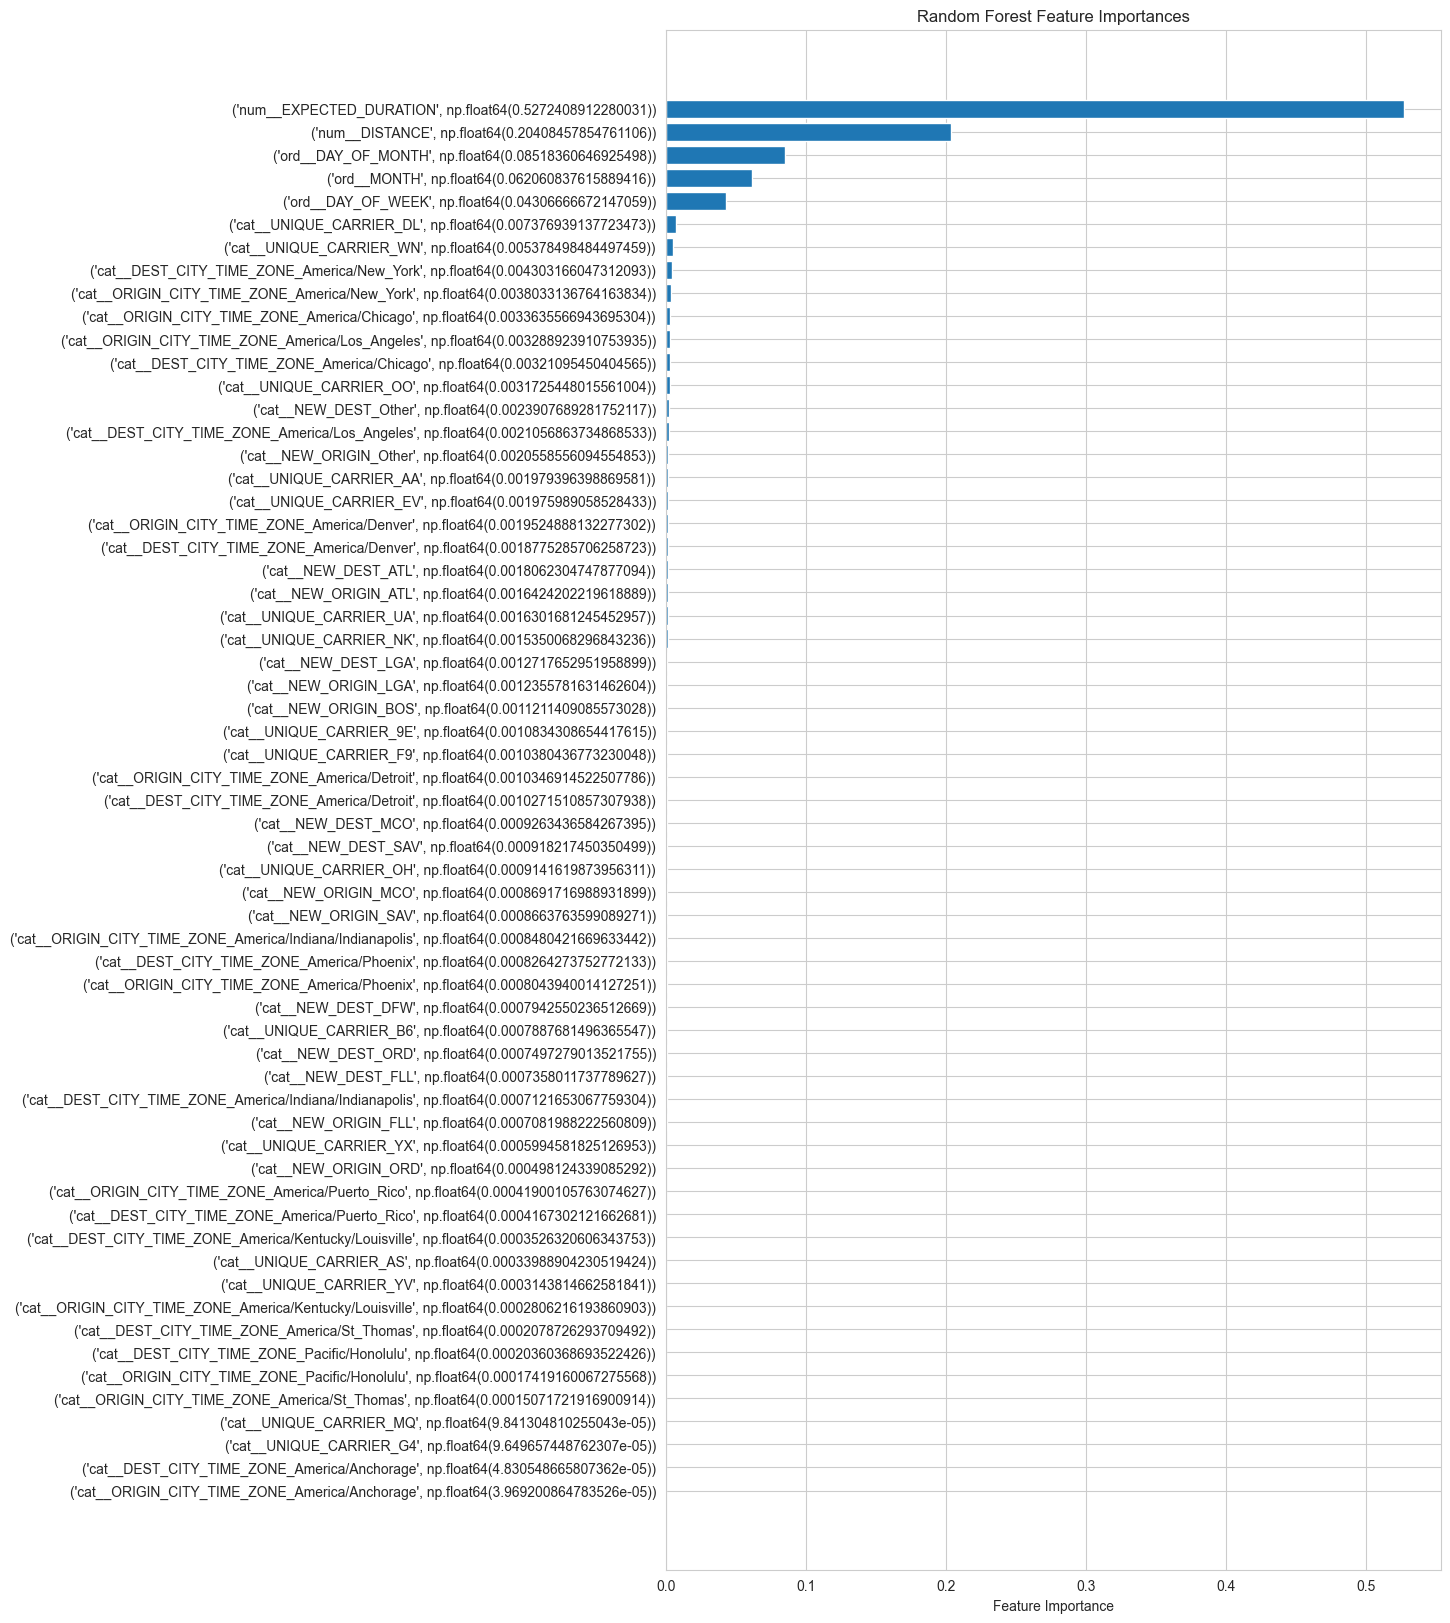

In [323]:
sorted_importances_rf = importances_rf[indices_rf]
plt.figure(figsize=(10, 20))
plt.barh(range(len(sorted_importances_rf)), sorted_importances_rf, align='center')
plt.yticks(range(len(sorted_importances_rf)), sorted_features_rf)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.show()

##### Xgboost

In [324]:
print(grid_search_op['XGBoost']['Classification_report'])

              precision    recall  f1-score   support

     On-Time       0.96      0.92      0.94     20555
       Delay       0.83      0.92      0.87      8892

    accuracy                           0.92     29447
   macro avg       0.90      0.92      0.91     29447
weighted avg       0.92      0.92      0.92     29447



- Performed similar to the baseline version but outperformed random forest because it has balance of On-Time and Delay recall factor

In [325]:
xgb_model = grid_search_op['XGBoost']['Pipeline'].named_steps['classifier']
importances_xgb = xgb_model.feature_importances_
feature_names_xgb = grid_search_op['XGBoost']['Pipeline'].named_steps['preprocessor'].get_feature_names_out()
indices_xgb = np.argsort(importances_xgb)[::-1]
sorted_features_xgb = [(feature_names_xgb[i], importances_xgb[i]) for i in indices_xgb]

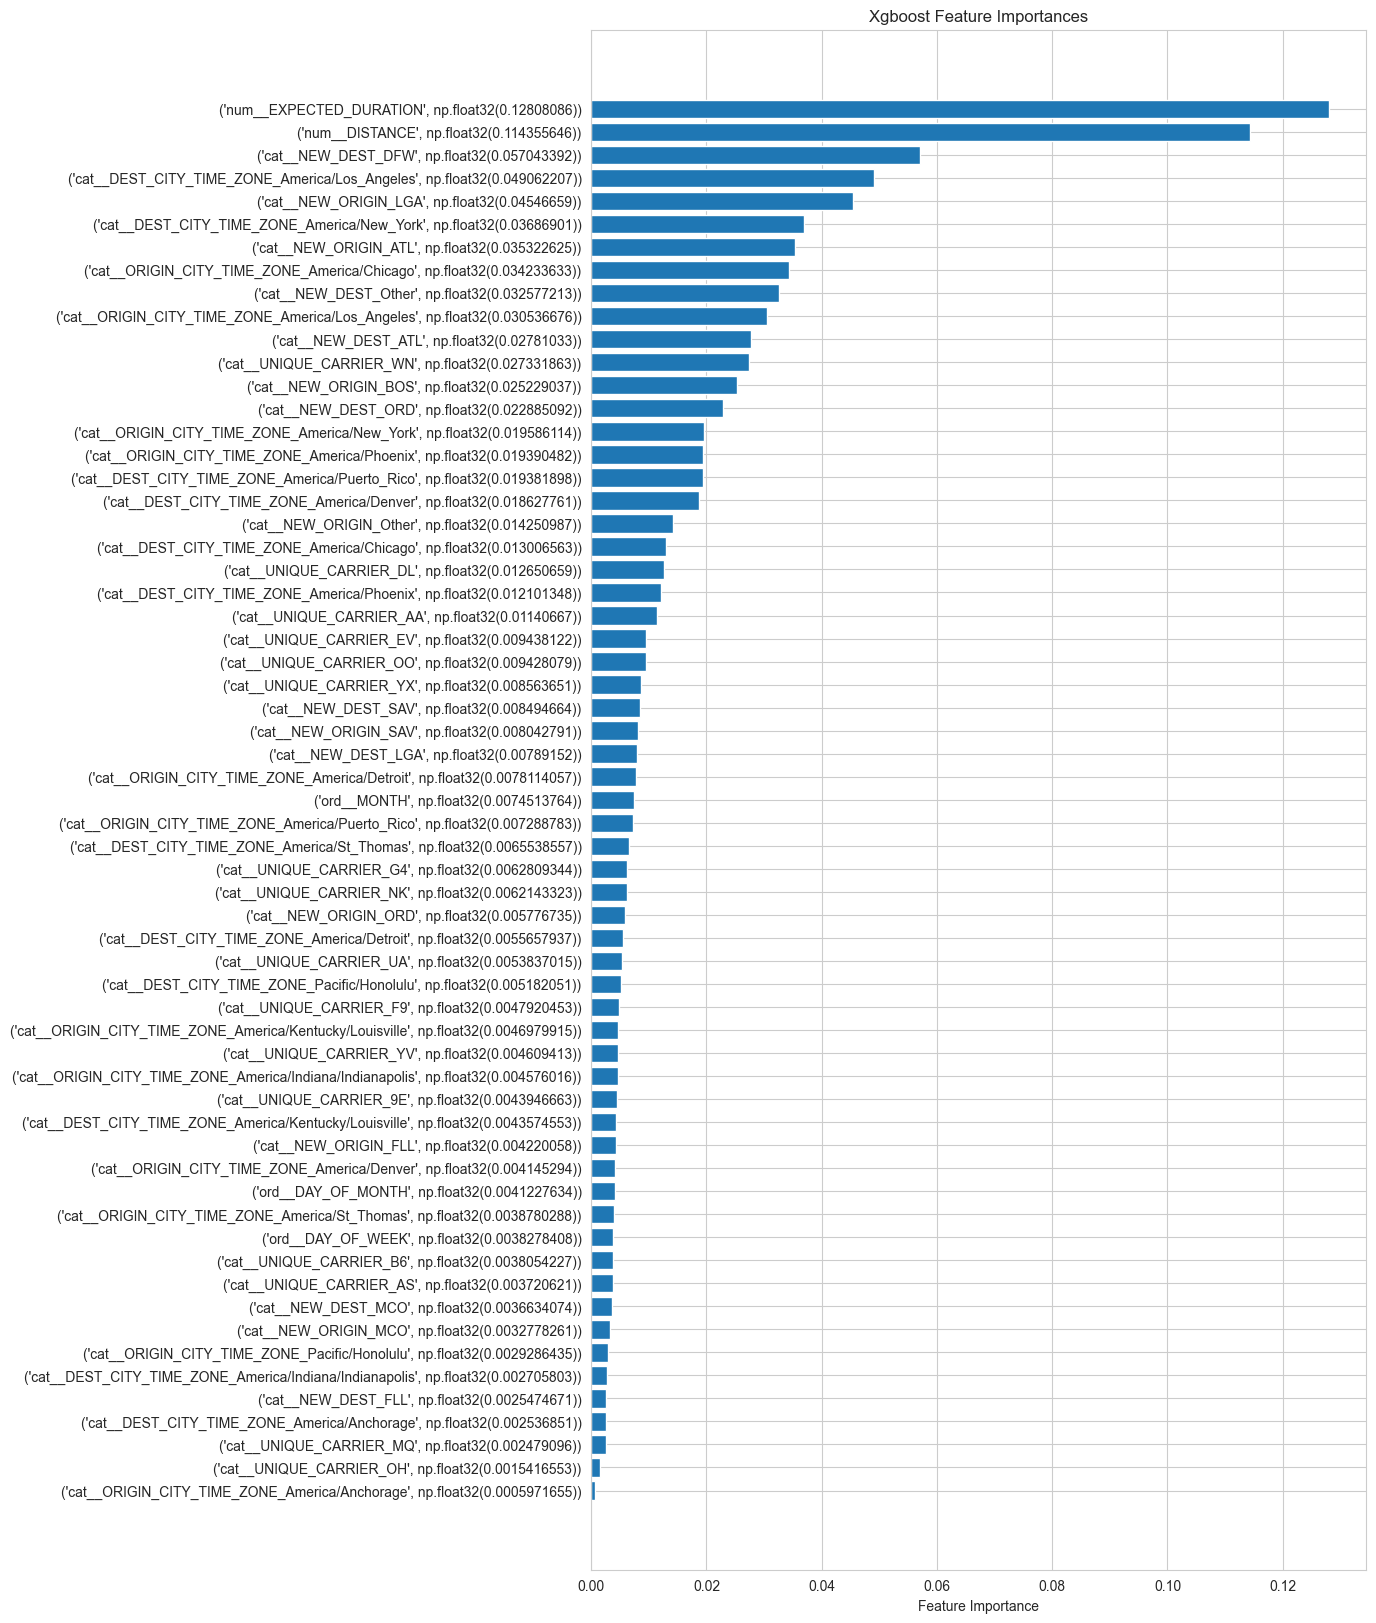

In [326]:
sorted_importances_xgb = importances_xgb[indices_xgb]
plt.figure(figsize=(10, 20))
plt.barh(range(len(sorted_importances_xgb)), sorted_importances_xgb, align='center')
plt.yticks(range(len(sorted_importances_xgb)), sorted_features_xgb)
plt.xlabel("Feature Importance")
plt.title("Xgboost Feature Importances")
plt.gca().invert_yaxis() 
plt.show()

# Conclusion

- Xgboost has outperformed Logistic Regression and Random Forest

- Looking at the feature importance of all the models in baseline and grid search. Common pattern is that EXPECTED_DURATION (calculated from scheduled arrival and destination time) and DISTANCE are key features.

- The data indicate that longer flights are far more prone to delay than shorter ones. We also see slight effects from airport‐specific factors and carriers, though the important ones consistently come from distance and flight duration.

- Based on the given use case we can use XgBoost to determine which flights will be on-time or delay. This can be used as a feature to help the travel company to inform users